In [1]:
# 看看 get_state_history 的返回值以设计 DocumentNode

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-max-latest',
    # model='qwen-max-2025-01-25',
    # model='qwen2.5-7b-instruct',  # 小模型会有同样的效果吗  ->  不太好
    temperature=0.0
)

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [3]:
# 定义向量数据库
from langchain_milvus import Milvus, BM25BuiltInFunction

vector_store = Milvus(
    collection_name='hybrid_hotpotqa500_hnsw',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

In [4]:
import sys

sys.path.append('../')

In [5]:
# 获得 RAG with Judge 图，使用 rrf reranker
from rag_with_judge.workflow import get_rag_with_judge_workflow
from modules.retriever import Retriever

from langgraph.checkpoint.memory import MemorySaver

# 获得带有短期记忆的 RAG with Judge 图
memory = MemorySaver()
rag_with_judge_wf = get_rag_with_judge_workflow()
rag_with_judge = rag_with_judge_wf.compile(checkpointer=memory)

# 定义检索器
rrf_retriever = Retriever(
    vector_store=vector_store,
    topk=3,
    search_fields=['dense', 'sparse'],
    search_type='hybrid',
    search_params=[
        {'metric_type': 'L2', 'params': {'ef': 21}},
        {'params': {'drop_ratio_search': 0.2}}
    ],
    ranker_type='rrf',
    ranker_params={'k': 60}
)

# 定义运行时配置
config = {
    'configurable': {
        'retriever': rrf_retriever,
        'llm': llm,
        'thread_id': '1',
        'graph': rag_with_judge,
        'recursion_depth': 0,
        'max_rec_depth': 5
    }
}

In [6]:
query = 'Which suburb of Adelaide in the City of Norwood Payneham St Peters is included in the electoral district of Dunstan?'

res = rag_with_judge.invoke(
    input={'query': query},
    config=config
)

使用 b2ce7930-34ec-4c2e-b8d6-33aeae534c5f 调用 RAG，问题为 Which suburbs in the City of Norwood Payneham St Peters are included in the electoral district of Dunstan?，当前递归深度为 1使用 7dad1a55-ebca-45dd-a094-c429c1601da6 调用 RAG，问题为 Which suburb within the City of Norwood Payneham St Peters is part of Dunstan?，当前递归深度为 1
使用 ec567e7b-7e5d-4c03-be40-2283fbdb65ad 调用 RAG，问题为 Which electoral district includes the suburb of College Park?，当前递归深度为 1

使用 7aac64cd-11d9-4b98-ab34-5b47367977bd 调用 RAG，问题为 Which parts of Klemzig and Payneham are included in Dunstan?，当前递归深度为 2
使用 e330f24e-febb-4b86-af06-98b8d2ede59e 调用 RAG，问题为 Which electoral district do Marryatville and Heathpool belong to?，当前递归深度为 2
使用 ccada89b-e2f0-447f-ab73-6c10ceb95db2 调用 RAG，问题为 Which suburbs in the City of Norwood Payneham St Peters are included in the Dunstan electoral district?，当前递归深度为 2
使用 9c8089a3-0f67-49ef-8d39-a3856a541787 调用 RAG，问题为 What are the exact boundaries of Dunstan in Klemzig and Payneham?，当前递归深度为 3
使用 a31577e6-ad5e-4c55-9aad-2

In [7]:
type(res)

langgraph.pregel.io.AddableValuesDict

In [10]:
res['similar_chunks'][0]

Document(metadata={'title': 'St Peters, South Australia', 'page': 0, 'dataset': 'HotpotQA', 'question': 'Dunstan is an electoral district that includes which suburb of Adelaide in the City of Norwood Payneham St Peters?', 'source': 'HotpotQA_St Peters, South Australia_5ac3a47f554299391541386d', 'pk': 'e19443b4-ab54-43e3-8625-9bd657c178a3', 'start_index': 0, 'hotpotqa_id': '5ac3a47f554299391541386d', 'recursion_depth': 0, 'next_rag_thread_id': 'b2ce7930-34ec-4c2e-b8d6-33aeae534c5f', 'score': 1, 'reason': 'Knowledge lacks electoral district info.', 'next_query': 'Which suburbs in the City of Norwood Payneham St Peters are included in the electoral district of Dunstan?'}, page_content='St Peters is a suburb of Adelaide in the City of Norwood Payneham St Peters.\n[question]: Which suburbs in the City of Norwood Payneham St Peters are included in the electoral district of Dunstan?\n[answer]: Beulah Park, College Park, Evandale, Firle, Hackney, Joslin, Kensington, Kent Town, Marden, Maylands

In [20]:
history = list(rag_with_judge.get_state_history(config={'configurable': {'thread_id': '1'}}))

In [21]:
type(history)

list

In [25]:
print(history[0].values['messages'][1].content)


[Knowledge]
knowledge 0: St Peters is a suburb of Adelaide in the City of Norwood Payneham St Peters.
[question]: Which suburbs in the City of Norwood Payneham St Peters are included in the electoral district of Dunstan?
[answer]: Beulah Park, College Park, Evandale, Firle, Hackney, Joslin, Kensington, Kent Town, Marden, Maylands, Norwood, Payneham South, Royston Park, St Morris, St Peters, Stepney, Trinity Gardens, Vale Park, parts of Klemzig and Payneham.

knowledge 1: Dunstan is an electoral district of the House of Assembly in the Australian state of South Australia, covering the inner eastern suburbs of Beulah Park, College Park, Evandale, Firle, Hackney, Joslin, Kensington, Kent Town, Marden, Maylands, Norwood, Payneham South, Royston Park, St Morris, St Peters, Stepney, Trinity Gardens and Vale Park and parts of Klemzig and Payneham.
[question]: Which suburb within the City of Norwood Payneham St Peters is part of Dunstan?
[answer]: College Park

knowledge 2: College Park (previ

In [32]:
history[3].next

('call_new_rag', 'call_new_rag', 'call_new_rag')

In [33]:
history[0].values

{'messages': [SystemMessage(content='You are a RAG Q&A assistant that operates strictly according to the following rules:\n1. Use only the knowledge provided by the user to answer questions, including the retrieved raw knowledge snippets and the added Q&A pairs (the **answer part is considered supplementary knowledge**, and only the content of the answer should be used). Do not use any external knowledge.\n2. If there is no information in all the knowledge (raw snippets + answers from Q&A pairs) that can answer the question, you must respond with "I cannot answer this question."\n3. The response must be concise and direct: output only the final answer, without explanations, references to the knowledge, or polite language.\n4. If the knowledge is irrelevant to the question, immediately trigger rule 2.', additional_kwargs={}, response_metadata={}, id='21058e98-21ac-411e-a9c2-9d74bec92734'),
  HumanMessage(content='[Knowledge]\nknowledge 0: St Peters is a suburb of Adelaide in the City of

In [35]:
list(rag_with_judge.get_state_history(config={'configurable': {'thread_id': '2'}}))

[]

In [36]:
a = rrf_retriever.get_similar_chunk_with_score(query='hello')

In [43]:
a[0][0].metadata['next_rag_thread_id'] = '3'

In [44]:
a

[(Document(metadata={'question': 'Who produced a 1999 fantasy-comedy directed by Spike Jonze?', 'pk': '776a4e83-9973-4d13-ab1b-268f5b21675f', 'start_index': 445, 'page': 0, 'source': 'HotpotQA_Hello Tomorrow_5a80993d5542996402f6a589', 'hotpotqa_id': '5a80993d5542996402f6a589', 'title': 'Hello Tomorrow', 'dataset': 'HotpotQA', 'next_rag_thread_id': '3'}, page_content=', Karen O of the Grammy-nominated rock band Yeah Yeah Yeahs. Proving to be an incredibly successful commercial, "Hello Tomorrow" received many honors; these include two Gold Lions at the 2005 Cannes Lions International Advertising Festival, three 2006 Silver Clio Awards, and a 2006 Gold EFFIE Award.'),
  0.032522473484277725),
 (Document(metadata={'question': 'Name the movie that was cowritten by Paul Rudd and the director of the 2011 British science fiction horror comedy film written and directed by Joe Cornish and starring John Boyega, Nick Frost, Jodie Whittaker and Luke Treadaway.', 'pk': 'b0d4b4e0-e036-44a7-8959-96688

In [45]:
b = rrf_retriever.get_similar_chunk_with_score(query='hello')

In [46]:
b

[(Document(metadata={'pk': '776a4e83-9973-4d13-ab1b-268f5b21675f', 'hotpotqa_id': '5a80993d5542996402f6a589', 'dataset': 'HotpotQA', 'title': 'Hello Tomorrow', 'question': 'Who produced a 1999 fantasy-comedy directed by Spike Jonze?', 'start_index': 445, 'page': 0, 'source': 'HotpotQA_Hello Tomorrow_5a80993d5542996402f6a589'}, page_content=', Karen O of the Grammy-nominated rock band Yeah Yeah Yeahs. Proving to be an incredibly successful commercial, "Hello Tomorrow" received many honors; these include two Gold Lions at the 2005 Cannes Lions International Advertising Festival, three 2006 Silver Clio Awards, and a 2006 Gold EFFIE Award.'),
  0.032522473484277725),
 (Document(metadata={'pk': 'b0d4b4e0-e036-44a7-8959-96688aa7b4da', 'hotpotqa_id': '5ac2eaab5542990b17b154a4', 'dataset': 'HotpotQA', 'title': 'Hello Carter', 'question': 'Name the movie that was cowritten by Paul Rudd and the director of the 2011 British science fiction horror comedy film written and directed by Joe Cornish an

*2025.06.04*

在测试时应当追加着来，一批一批的来，不然一旦崩溃就损失了所有数据

*2025.07.25*

测试 Milvus 贡献者提出的[方法](https://github.com/milvus-io/milvus/discussions/43264#discussioncomment-13877400)

### 使用 HNSW 索引会让搜索结果尽量一致吗  ->  会的


~~把数据写入 csv 文件里，然后导入进新的数据库里面就好了~~

把数据写入 JSON 文件里，csv 文件在写入时会有些小问题（分隔符导致的）

导入之前，新数据库里面要有添加一个包含一致字段的实体，不然 attu 里面找不到，准备导入时删掉就好了

导出时要注意导出的数据 dense 要是原始的数据，而不是 np 的表示 -> 使用 `client.search` 就行了

在 Milvus 等向量数据库中，[索引](https://milvus.io/docs/zh/v2.5.x/index-explained.md#Index-Explained) 是建立在数据之上的 **附加结构**

因此，只要有数据，你就可以更改索引，甚至在[这篇文档](https://milvus.io/docs/zh/v2.5.x/index-vector-fields.md?tab=floating#Drop-an-Index)中，你还可以删除一个索引。当然，之后如果有需要，你还可以对相同的字段[重新建立索引](https://milvus.io/docs/zh/v2.5.x/index-vector-fields.md#Index-a-Collection)

这么一看，自己刚刚把一个向量数据库中的所有数据都导出来、存到 JSON 里、通过 attu 再导入不同的向量数据库的行为有点憨憨的。你可以直接在原始数据库上进行删除、新建索引的操作，因为「索引是建立在数据上的 **附加结构**」

In [ ]:
# 创建单密集嵌入、混合嵌入的向量数据库
from langchain_milvus import Milvus, BM25BuiltInFunction


# 定义向量场的索引参数
dense_index_parma = {
    "metric_type": "L2",
    "index_type": "HNSW",
    "params": {
        "M": 64,
        "efConstruction": 400
    }
}

sparse_index_param = {
    "metric_type": "BM25",
    "index_type": "AUTOINDEX",
    "params": {}
}

# 单密集嵌入
dense_vs_hnsw = Milvus(
    collection_name='dense_hotpotqa500_hnsw',
    embedding_function=embed_model,
    vector_field='dense',
    index_params=dense_index_parma
)

# 混合嵌入

hybrid_vs_hnsw = Milvus(
    collection_name='hybrid_hotpotqa500_hnsw',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse'],
    index_params=[dense_index_parma, sparse_index_param]  # 顺序关系是对应的
)

In [ ]:
# 加载 hybrid_hotpotqa_500 使用 search_iterator 将所有数据导出到 json 文件中
# csv 文件的格式和 attu 导出的一致

hybrid_vs = Milvus(
    collection_name='hybrid_hotpotqa_500',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

# 定义任何一个问题都可以
query_embedding = embed_model.embed_query('What is the name of the restaurant?')

In [17]:
from typing import List, Dict
from pymilvus.client.search_result import Hit
from pymilvus.orm.iterator import SearchPage

iterator = hybrid_vs.client.search_iterator(
    collection_name='hybrid_hotpotqa_500',
    data=[query_embedding],
    anns_field='dense',
    batch_size=1000,
    output_fields=['*']
)

# 使用 search_iterator 得到数据库中的所有数据
total = 0
res: List[Dict] = []
while True:
    result: SearchPage = iterator.next()
    if not result:
        iterator.close()
        break
    
    for hit in result:  # hit type: Hit
        hit_dict = {
            'dataset': hit['dataset'],
            'source': hit['source'],
            'page': hit['page'],
            'start_index': hit['start_index'],
            'question': hit['question'],
            'title': hit['title'],
            'dense': hit['dense'],
            'hotpotqa_id': hit['hotpotqa_id'],
            'text': hit['text'],
            'pk': hit['pk']
        }
        res.append(hit_dict)
    
    total += len(result)
    print(total)

print(f'Total results: {total}')

1000
2000
3000
4000
5000
6000
7000
8000
8293
Total results: 8293


In [40]:
# 将 res 导出到 json 文件中，之后可以用 attu 导入到数据库中
import json

output_filename1 = r'../../hybrid_hotpotqa_500_1.json'
with open(output_filename1, 'w', encoding='utf-8') as f:
    json.dump(res[:4000], f, ensure_ascii=False, indent=4)

output_filename2 = r'../../hybrid_hotpotqa_500_2.json'
with open(output_filename2, 'w', encoding='utf-8') as f:
    json.dump(res[4000:8000], f, ensure_ascii=False, indent=4)

output_filename3 = r'../../hybrid_hotpotqa_500_3.json'
with open(output_filename3, 'w', encoding='utf-8') as f:
    json.dump(res[8000:], f, ensure_ascii=False, indent=4)

In [ ]:
# 先向 dense_hotpotqa500_hnsw 和 hybrid_hotpotqa500_hnsw 中导入一条数据
# 不然在 attu 中找不到，导入之后删掉
hybrid_vs.similarity_search(query='What is the name of the restaurant?', k=1)

[Document(metadata={'title': 'List of casual dining restaurant chains', 'start_index': 0, 'pk': '5b8f0b10-c321-4c35-9f41-ad6bce42e9bb', 'page': 0, 'hotpotqa_id': '5ae4932855429970de88d9b8', 'dataset': 'HotpotQA', 'source': 'HotpotQA_List of casual dining restaurant chains_5ae4932855429970de88d9b8', 'question': "Which  American chain of bakery-café fast casual restaurants sponsored Bill Steers Men's 4-Miler"}, page_content='This is a list of casual dining restaurant chains around the world, arranged in alphabetical order. A casual dining restaurant is a restaurant that serves moderately priced food in a casual atmosphere. Except for buffet-style restaurants and, more recently, fast casual restaurants, casual dining restaurants usually provide table service.')]

In [38]:
from langchain_core.documents import Document

insert_enity = [
    Document(
        page_content='This is a list of casual dining restaurant chains around the world, arranged in alphabetical order. A casual dining restaurant is a restaurant that serves moderately priced food in a casual atmosphere. Except for buffet-style restaurants and, more recently, fast casual restaurants, casual dining restaurants usually provide table service.',
        metadata={'title': 'List of casual dining restaurant chains', 'start_index': 0, 'page': 0, 'hotpotqa_id': '5ae4932855429970de88d9b8', 'dataset': 'HotpotQA', 'source': 'HotpotQA_List of casual dining restaurant chains_5ae4932855429970de88d9b8', 'question': "Which  American chain of bakery-café fast casual restaurants sponsored Bill Steers Men's 4-Miler"}
    )
]

In [39]:
from uuid import uuid4

dense_vs_hnsw.add_documents(documents=insert_enity, ids=[str(uuid4())])
hybrid_vs_hnsw.add_documents(documents=insert_enity, ids=[str(uuid4())])

['7e608905-ab91-43de-9b81-e91a30a74559']

之后：

1. 把刚刚插入的数据从 `dense_hotpotqa500_hnsw` 和 `hybrid_hotpotqa500_hnsw` 中删除

2. 在 attu 上将 JSON 文件导入到 `dense_hotpotqa500_hnsw` 和 `hybrid_hotpotqa500_hnsw` 中

In [4]:
dense_vs_hnsw.client.describe_index(
    collection_name='dense_hotpotqa500_hnsw',
    index_name='dense'
)

{'metric_type': 'L2',
 'index_type': 'HNSW',
 'params': {'M': 64, 'efConstruction': 400},
 'field_name': 'dense',
 'index_name': 'dense',
 'total_rows': 8293,
 'indexed_rows': 8293,
 'pending_index_rows': 0,
 'state': 'Finished'}

In [5]:
hybrid_vs_hnsw.client.describe_index(
    collection_name='hybrid_hotpotqa500_hnsw',
    index_name='dense'
)

{'metric_type': 'L2',
 'index_type': 'HNSW',
 'params': {'M': 64, 'efConstruction': 400},
 'field_name': 'dense',
 'index_name': 'dense',
 'total_rows': 8293,
 'indexed_rows': 8293,
 'pending_index_rows': 0,
 'state': 'Finished'}

In [6]:
# 定义判断检索结果是否一致的函数
from typing import Tuple, List
from langchain_core.documents import Document

def is_same_result(
        dense_res: List[Tuple[Document, float]],
        hybrid_res: List[Tuple[Document, float]]
) -> bool:
    """
    比较两个向量数据库进行密集检索的结果是否一致

    Args:
        dense_res (List[Tuple[Document, float]]): 密集检索的结果
        hybrid_res (List[Tuple[Document, float]]): 混合检索的结果

    Returns:
        bool: 检索结果是否一致
    """
    # 检查两个结果的数量是否一致
    if len(dense_res) != len(hybrid_res):
        return False

    # 检查两个结果里面的具体内容是否一样
    for d_res, h_res in zip(dense_res, hybrid_res):
        if (
            d_res[1] != h_res[1]  # 比较分数
            or d_res[0].page_content != h_res[0].page_content  # 比较文档内容
        ):
            return False

    return True

In [7]:
# 加载问题和对应的嵌入
import json
from loguru import logger as log
import pprint

all_questions = []
question_path = r'../../evaluation/hotpotqa/hybrid_test_data_w_embedding_500.json'
with open(question_path, 'r', encoding='utf-8') as f:
    all_questions = json.load(f)

log.info(f'加载了 {len(all_questions)} 个问题')
pprint.pprint(all_questions[0])

# 定义查询的参数
top_k = 10
search_params = {
    'metric_type': 'L2',
    'params': {'ef': 21}
}

2025-07-28 14:43:05.128 | INFO     | __main__:<module>:11 - 加载了 500 个问题


{'_id': '5a8ba761554299240d9c2066',
 'answer': 'nearly 80 years',
 'context': [['Bus Stop (TV series)',
              ['Bus Stop is a 26-episode American drama which aired on ABC '
               'from October 1, 1961, until March 25, 1962, starring Marilyn '
               'Maxwell as Grace Sherwood, the owner of a bus station and '
               'diner in the fictitious town of Sunrise in the Colorado '
               'Rockies.',
               ' The program was adapted from William Inge\'s play, "Bus '
               'Stop", and Inge was a script consultant for the series, which '
               'followed the lives of travelers passing through the bus '
               'station and the diner.',
               " Maxwell's co-stars were Richard Anderson as District Attorney "
               'Glenn Wagner, Rhodes Reason as Sheriff Will Mayberry, Joan '
               'Freeman as waitress Elma Gahrigner, Bernard Kates as Ralph the '
               'coroner, and Buddy Ebsen as Virge Bles

In [9]:
# 在两个向量数据库上使用 client.search 进行检索
from tqdm import tqdm

diff_res = []
same_res_num = 0

for question in tqdm(all_questions):
    raw_dense_res = dense_vs_hnsw.client.search(
        collection_name='dense_hotpotqa500_hnsw',
        data=[question['embedding']],
        anns_field='dense',  # 在 dense_hotpotqa_500 向量数据库中，密集嵌入的索引为 'vector'
        limit=top_k,
        search_params=search_params,
        output_fields=["*"]
    )
    dense_res = dense_vs_hnsw._parse_documents_from_search_results(raw_dense_res)


    raw_hybrid_res = hybrid_vs_hnsw.client.search(
        collection_name='hybrid_hotpotqa500_hnsw',
        data=[question['embedding']],
        anns_field='dense',
        limit=top_k,
        search_params=search_params,
        output_fields=["*"]
    )
    hybrid_res = hybrid_vs_hnsw._parse_documents_from_search_results(raw_hybrid_res)

    # 比较检索结果
    if is_same_result(dense_res, hybrid_res):
        same_res_num += 1
    else:
        tmp = {
            'question': question['question'],
            'dense_res': dense_res,
            'hybrid_res': hybrid_res
        }
        diff_res.append(tmp)

        # log.info(f'{question["question"]} 检索结果不一致')
        tqdm.write(f'{question["question"]} 检索结果不一致')
# 输出结果
log.info(f'检索结果一致的问题数量：{same_res_num} / {len(all_questions)}')
log.info(f'检索结果不一致的问题数量：{len(diff_res)}')

  2%|▏         | 9/500 [00:00<00:06, 80.52it/s]

How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits? 检索结果不一致


  6%|▌         | 28/500 [00:00<00:05, 82.12it/s]

Spider9 was founded in 2011 by the head of which subsidiary of Wanxiang Group? 检索结果不一致
ICI House is now named after the company that provides what type of item? 检索结果不一致


 13%|█▎        | 65/500 [00:00<00:05, 83.06it/s]

When is the football club which Stan Spinks played for founded 检索结果不一致
Which German project recorded a song that featured vocals by a duo from Silverdale, England? 检索结果不一致
Erica Packer was the second wife of what Australian businessman? 检索结果不一致


 21%|██        | 104/500 [00:01<00:04, 91.07it/s]

Which of the people featured on Wall of Fame is the daughter of Bernie Ecclestone? 检索结果不一致


 25%|██▌       | 125/500 [00:01<00:04, 86.94it/s]

In what county did Michael Ola attend high school? 检索结果不一致


 43%|████▎     | 213/500 [00:02<00:03, 92.37it/s]

What was Randy Shughart's rank when he died? 检索结果不一致


 51%|█████     | 253/500 [00:02<00:02, 91.25it/s]

What production company is owned by the director of "She Hate Me"? 检索结果不一致


 65%|██████▍   | 323/500 [00:03<00:01, 91.45it/s]

What was the formal name of the building that housed the scene that formed the band Hjertestop? 检索结果不一致


 68%|██████▊   | 342/500 [00:03<00:01, 85.24it/s]

Scout Tufankjian and Daron Malakian are both what? 检索结果不一致


 74%|███████▍  | 371/500 [00:04<00:01, 86.35it/s]

Which writer of French descent actually lived in France, Maurice Level or John Dufresne? 检索结果不一致
By what name is the King that Gothard Wilhelm Butler was captain of the guard for known in Poland? 检索结果不一致


 82%|████████▏ | 408/500 [00:04<00:01, 82.20it/s]

What did Karan Kapoor's maternal grandfather deliver? 检索结果不一致


 85%|████████▌ | 426/500 [00:04<00:00, 79.84it/s]

Do The Importance of Being Icelandic and The Five Obstructions belong to different film genres ? 检索结果不一致


 91%|█████████ | 455/500 [00:05<00:00, 84.42it/s]

What album succeeded Kendrick Lamar's album that had the song Money Trees in it? 检索结果不一致


100%|██████████| 500/500 [00:05<00:00, 86.81it/s]
2025-07-28 14:45:13.309 | INFO     | __main__:<module>:43 - 检索结果一致的问题数量：483 / 500
2025-07-28 14:45:13.309 | INFO     | __main__:<module>:44 - 检索结果不一致的问题数量：17


In [10]:
# 统计 500 个问题中，top_1 到 top_10 中不一样的分别有多少
from collections import defaultdict

res = defaultdict(int)
less_3 = 0

for diff in diff_res:
    d_res = diff['dense_res']
    h_res = diff['hybrid_res']

    i = 0
    for d_r, h_r in zip(d_res, h_res):
        if d_r[1] != h_r[1]:
            res[str(i)] += 1
            if i < 3:
                log.info(f'{i}: {diff['question']}')
                less_3 += 1
            break
        i += 1

In [11]:
res

defaultdict(int, {'9': 5, '7': 3, '8': 2, '4': 3, '6': 2, '5': 2})

不一致的结果小了很多，500 个问题中只有 17 个 top-10 不一样了，且所有问题的 top-3 都一样

加载一个创建好的向量数据库并不需要传入那么多的参数

对于混合嵌入和单密集嵌入向量数据库，

- 必须参数：`collection_name`、`embedding_function`、`builtin_function`、`vector_field`

- 非必须参数：`index_params`

此外，如果你传入了错位的 `index_params` 参数，Milvus 会正常加载原先创建的向量数据库，不会报错。这一点你可以在下面的代码中看到

In [ ]:
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [6]:
hybrid_vs_hnsw1 = Milvus(
    collection_name='hybrid_hotpotqa500_hnsw',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

dense_vs_hnsw1 = Milvus(
    collection_name='dense_hotpotqa500_hnsw',
    embedding_function=embed_model,
    vector_field='dense'
)

In [7]:
hybrid_vs_hnsw1.client.describe_index(
    collection_name='hybrid_hotpotqa500_hnsw',
    index_name='dense'
)

{'metric_type': 'L2',
 'index_type': 'HNSW',
 'params': {'M': 64, 'efConstruction': 400},
 'field_name': 'dense',
 'index_name': 'dense',
 'total_rows': 8293,
 'indexed_rows': 8293,
 'pending_index_rows': 0,
 'state': 'Finished'}

In [8]:
dense_vs_hnsw1.client.describe_index(
    collection_name='dense_hotpotqa500_hnsw',
    index_name='dense'
)

{'metric_type': 'L2',
 'index_type': 'HNSW',
 'params': {'M': 64, 'efConstruction': 400},
 'field_name': 'dense',
 'index_name': 'dense',
 'total_rows': 8293,
 'indexed_rows': 8293,
 'pending_index_rows': 0,
 'state': 'Finished'}

In [9]:
from langchain_milvus import Milvus, BM25BuiltInFunction

hybrid_vs_hnsw2 = Milvus(
    collection_name='hybrid_hotpotqa500_hnsw',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse'],
    index_params=[
        {
            "metric_type": "L2",
            "index_type": "HNSW",
            "params": {
                "M": 10,
                "efConstruction": 40
            }
        },
        {
            "metric_type": "BM25",
            "index_type": "AUTOINDEX",
            "params": {}
        }
    ]
)

In [10]:
hybrid_vs_hnsw2.client.describe_index(
    collection_name='hybrid_hotpotqa500_hnsw',
    index_name='dense'
)

{'metric_type': 'L2',
 'index_type': 'HNSW',
 'params': {'M': 64, 'efConstruction': 400},
 'field_name': 'dense',
 'index_name': 'dense',
 'total_rows': 8293,
 'indexed_rows': 8293,
 'pending_index_rows': 0,
 'state': 'Finished'}

*2025.07.25*

在使用 langchain_milvus 时，如何指定向量的索引类型？

在使用 `Milvus()` 初始化一个向量数据库时，`__init__` 方法会调用 `_check_vector_field`，在这个方法中会将 `vector_filed（来自 Milvus()）` 与 `index_parmas（来自 Milvus()）` 中的字段按照「顺序关系」建立映射关系，如果 `index_parmas` 为空，这个映射关系会是一个空字典。与 Qwen 的讨论在[这里](https://chat.qwen.ai/s/6846658f-26f5-47b7-85b2-6569891ebef9?fev=0.0.166)。具体代码如下：

```python
        for field, index_params in zip(
            self._as_list(vector_field), self._as_list(self.index_params)
        ):
            self._index_param_map[field] = index_params
else:
    self._index_param_map = {
        field: {} for field in self._as_list(self._vector_field)
    }
```

这样就实现了「为不同字段设置不同 `index parma`」，在之后调用的 `_create_index` 中就会按照上面的映射关系创建索引

向量默认的 `index parma` 在 `_create_index` 中定义如下：

```python
default_index_params = {
    "metric_type": "L2",
    "index_type": "AUTOINDEX",
    "params": {},
}
```

Milvus 2.5 HNSW 文档：

1. https://milvus.io/docs/zh/v2.5.x/hnsw.md#Index-building-params

2. https://milvus.org.cn/ai-quick-reference/what-are-the-key-configuration-parameters-for-an-hnsw-index-such-as-m-and-efconstructionefsearch-and-how-does-each-influence-the-tradeoff-between-index-size-build-time-query-speed-and-recall

在讨论中，Milvus 的贡献者提到了要「Use the HNSW index and increase the efConstruction and efSearch parameters to improve search accuracy.」

其中的 `efConstruction` 和 `M` 是构建 HNSW 索引所需的参数

而 `efSearch` 是在 HNSW 索引上进行搜索所需的参数（你可以使用 `client.search` 来传递这个 `ef` 参数）

有关 `M`、`efConstruction`、`efSearch` 各自的意义你可以在篇[文档](https://milvus.io/docs/zh/v2.5.x/hnsw.md#Index-params)中找到

一个具体的例子如下：

In [14]:
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [15]:
# 加载向量数据库
from langchain_milvus import Milvus, BM25BuiltInFunction

dense_index_parma = {
    "metric_type": "L2",
    "index_type": "HNSW",
    "params": {
        "M": 64,
        "efConstruction": 100
    }
}

sparse_index_param = {
    "metric_type": "BM25",
    "index_type": "AUTOINDEX",
    "params": {}
}

vs = Milvus(
    collection_name='HNSW_test',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse'],
    index_params=[dense_index_parma, sparse_index_param]  # 顺序关系是对应的
)

In [17]:
from uuid import uuid4
from langchain_core.documents import Document

doc1 = Document(
    page_content='我知道怎么在 Milvus 中为向量指定索引类型了！',
    metadata={
        'id': 1
    }
)

vs.add_documents(documents=[doc1], ids=[str(uuid4())])

['2c2bea37-befa-4dc6-a723-1d6f7378c589']

In [23]:
# 可以看到现在的 dense 嵌入的索引类型为 HNSW

vs.client.describe_index(collection_name='HNSW_test', index_name='dense')

{'metric_type': 'L2',
 'index_type': 'HNSW',
 'params': {'M': 64, 'efConstruction': 100},
 'field_name': 'dense',
 'index_name': 'dense',
 'total_rows': 0,
 'indexed_rows': 0,
 'pending_index_rows': 0,
 'state': 'Finished'}

*2025.07.08*

如何实现稀疏检索、密集检索、混合检索？

首先需要创建一个包含稀疏嵌入、密集嵌入的混合嵌入向量数据库，可以参考[这篇文档](https://milvus.io/docs/zh/milvus_hybrid_search_retriever.md#Dense-embedding-+-Sparse-embedding)

简单来说，我们需要在创建一个 Milvus 实例时，向如下的三个参数传递对应的值即可：

1. 通过 `embedding_function` 定义将文本转化为密集嵌入的方法

2. 通过 `builtin_function` 定义将文本转化为稀疏嵌入的方法

   你可以像这个参数传递一个 langchain_milvue 封装好的 `BM25BuiltInFunction` 实例 或 [一个自定义的稀疏嵌入（链接所指向的 option 2）](https://milvus.io/docs/milvus_hybrid_search_retriever.md#Dense-embedding-+-Sparse-embedding)

   在使用封装好的 `BM25BuiltInFunction` 实例时，还需要注意其中的一些[参数](https://milvus.io/docs/full_text_search_with_langchain.md#Initialization-with-BM25-Function)，包括：

   - `input_field_names` (str): 输入字段的名称，默认为 `text` 。它表示此函数作为输入读取的字段（MIlvus 默认存储文本的字段就是 `text`）
   - `output_field_names` (str): 输出字段的名称，默认为 `sparse` 。它表示此函数将计算结果输出到哪个字段

   在实践中，如果存在多个嵌入函数组合时，对每个函数清晰定义其输入字段和输出字段可以避免歧义。在当前的实践例子中，上面参数的默认值就已经能够区分了

3. 通过 `vector_field` 来指定前面定义的不同嵌入函数所输出的字段，其类型为 `List[str]`

   当然，输出字段的名称是可以随意定义的。不过，当你更改名称后需要同时修改前面嵌入函数的输出字段

通过向上面的参数传递对应的值，我们就创建了一个可以进行<font color='blue'>密集 + 稀疏混合搜索 Milvus 向量存储实例</font>

接下来的问题就是如何使用这个混合嵌入的实例进行单稀疏搜索、单密集搜索、混合搜索了

具体来说有下面几种方式：

1. ~~在混合搜索时使用 [weight ranker（链接下方的「对候选数据重新排名」部分的内容）](https://milvus.io/docs/zh/milvus_hybrid_search_retriever.md#Define-multiple-arbitrary-vector-fields)，通过 weights 参数设置为 [1, 0]、[0, 1] 可以分别实现单密集搜索、单稀疏搜索~~

    ~~不过这中方法的缺点是，没有办法获得各自的分数（距离）~~

    通过控制 weighted reranker 的 weights 参数分别为 [1, 0]、[0, 1]，来实现单密集搜索、单稀疏搜索的思路是没问题的

    ~~但是由于 langchain_milvus 的实现问题，即使传入了正确的 weights 参数，结果也不会像预期那样，和密集嵌入向量数据库的结果一致。你可以在下面的代码中观察到这一现象~~

    这是由于我自己的失误，similarity_search_with_score 需要的是 `ranker_params`，我给写成了 `ranker_parmas`！！！

    但是，当仿照方法3，绕过 langchain_milvus 封装好的 `similarity_search_with_score` 函数，直接使用 [client.hybrid_search](https://milvus.io/api-reference/pymilvus/v2.5.x/ORM/Collection/hybrid_search.md) 函数，使用 weighted reranker 并传入正确的 weights 参数，结果就会和密集嵌入向量数据库的结果一致（自然，这里和方法3一样，也需要去除 client.fileds 中的 'sparse' 变量并在之后解析 hybrid_search 的返回结果）

    有关 client.hybrid_search 的使用方法，可以参考 langchain_milvus 的实现和 [这篇](https://milvus.io/docs/zh/multi-vector-search.md#Perform-Hybrid-Search) 和 [这篇](https://milvus.io/docs/zh/hybrid_search_with_milvus.md#Hybrid-Search-with-Milvus) 文档

    当然，你可以按照上面的想法，直接使用 client.hybrid_search 来实现混合检索，那样不是更复杂些。不过这样你可以控制自己仅在一些向量场上进行搜索和重排

2. 还可以通过在加载混合嵌入向量数据库实例时，不向其传递对应的嵌入函数来实现。具体来说：

    1. 将 `embedding_function` 或  `builtin_function` 分别设置为 None，对应着 单密集检索 或 单稀疏检索
    
    2. 并将 `vector_filed` 设置为对应的值（`dense` 或 `sparse`）

    3. 之后可以通过 langchain_milvus 封装好的 `similarity_search_with_score` 方法进行搜索，并分别获得各自的分数（距离）

    这种方法可行的原因是，在 langchain_milvus 有关 `similarity_search_with_score` 的实现中，会通过判断当前 Milvus 实例中是否包含 `embedding_function` 或  `builtin_function` 来决定是使用
    
    1. 单稀疏检索（当前实例的 `embedding_function` 为 None）
    
    2. 单密集检索（当前实例的 `builtin_function` 为 None）

        单稀疏检索和单密集检索之后都会调用 langchain_milvus 封装的 `_collection_search` 函数，该函数会使用 Milvus 中的 [search](https://milvus.io/api-reference/pymilvus/v2.5.x/ORM/Collection/search.md) 方法
    
    3. 混合检索（当前实例两种嵌入函数都存在）

        混合检索之后会调用 langchain_milvus 封装的 `_collection_hybrid_search` 函数，该函数会使用 Milvus 中的 [hybrid_search](https://milvus.io/api-reference/pymilvus/v2.5.x/ORM/Collection/hybrid_search.md) 方法
    
    该方法还需要注意的一点是：在单密集检索的情况下，需要将 Milvus 实例的 fileds 属性中的 `sparse` 变量从 list 中给 remove 掉，否则会报错 `RPC error: [search], <MilvusException: (code=65535, message=not allowed to retrieve raw data of field sparse)>`

    该错误的一个解决方法是：向 `similarity_search_with_score` 函数中添加一个 `output_fileds` 参数，该参数的值为 `vs_hy_500.fileds[:].remove('sparse)`，但是由于 langchain_milvus 封装的原因，当试图向该函数传递 `output_fileds` 参数时，会提示[类似](https://github.com/langchain-ai/langchain/issues/18580)这样的错误

    因此，只能选择「将 Milvus 实例的 fileds 属性中的 `sparse` 变量从 list 中给 remove 掉」这个方法，才能使得方法 2 在单密集检索的情况下正常

3. 最后，比较好的方法是「绕过 langchain_milvus 实现的 `similarity_search_with_score`，直接使用 Milvus 提供的 `search` 函数来实现单稀疏检索、单密集检索」，可以参考 [search 方法](https://milvus.io/api-reference/pymilvus/v2.5.x/ORM/Collection/search.md) 和 langchain_milvus 中的 `_collection_search` 函数的实现

    ~~通过 client.search 函数，我们就可以在进行单稀疏检索或单密集搜索时，都需向其中的 `output_fileds` 参数传递 remove 掉 `sparse` 变量的 `vs_hy_500.fileds`，从而避免方法 2 在单密集检索时出现的错误~~

    ~~*2025.07.23 更新：*~~
    
    ~~在使用方法 3 时，由于是直接调用的 client.search，所以不需要向 `output_fileds` 参数传递 remove 掉 `sparse` 变量的 `vs_hy_500.fileds`，即使输出全部的 fields 也不会报错。因为这是直接调用的 Milvus 的 search。你可以在上面的代码中观察到这一现象~~

    *2025.07.29 更新：*

    在使用方法 3 时，如果是在密集嵌入上进行搜索，则不必 remove `sparse` 变量。但是，当在稀疏嵌入上进行搜索时，则必须 remove `sparse` 变量，这是因为，Milvus 规定 [BM25 函数生成的稀疏向量不能在全文检索中直接访问或输出](https://milvus.io/docs/zh/full-text-search.md#FAQ)

    之后还需要通过 langchain_milvus 封装的 `_parse_documents_from_search_results` 函数解析返回的搜索结果，以获得对应的文档和分数（距离）

    此外，对于混合检索，可以继续使用 langchain_milvus 封装的 `similarity_search_with_score` 方法
    
    或者，根据 [这个](https://github.com/milvus-io/milvus/discussions/34638) 和 [这个](https://github.com/milvus-io/milvus/discussions/32741) Github 上的讨论，你可以自定义一个 ReRanker 的逻辑

现在的问题是：对于相同的文档，相同的嵌入，密集检索得到的结果是不同的

~~将由下面的代码复现~~

下面的代码并没有复现出问题，但是这个问题在 dense_hotpotqa_500 和 hybrid_hotpotqa_500 中确实存在。我想，这确定是 Milvus 底层的问题，可能是涉及到分区什么的原因。好在并不会影响排名较前的结果

不过从下面的例子中，我们至少可以证明你上面说的三种实现单密集检索、单稀疏检索、混合检索的方法都是可行的 (๑\*◡*๑)

下面的代码将进行如下的工作：

1. 分别创建一个「单密集嵌入向量数据库」和「混合嵌入向量数据库」，并向其中添加相同的文档

    这样做的本意是为了复现出之前的 bug 并在其中对上提到的三种方法进行测试

2. 在「混合嵌入向量数据库」按照上面提到的三个方法实现单密集检索，并和「单密集嵌入向量数据集」得到的结果进行比较，验证上面三种方法的有效性

此外，类似的，我还使用「ICI House is now named after the company that provides what type of item?」在两个数据库上的检索结果按照上面的方法也创建了两个向量数据库进行了测试，同样也没有复现出对应的问题

In [2]:
# 定义嵌入模型
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [32]:
# 定义要存储的文档
from langchain_core.documents import Document

docs = [
    Document(
        page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.',
        metadata={
            'id': '1',
            'dense_score': 0.49807465076446533
        }
    ),
    Document(
        page_content='The Mickey Rooney Show (also known as Hey, Mulligan) is an American sitcom that aired from 1954 to 1955 on NBC. The series stars Mickey Rooney (in his first television role) who was particularly remembered for his starring role in numerous Andy Hardy films made between 1937 and 1958, which overlapped with "Hey Mulligan".',
        metadata={
            'id': '2',
            'dense_score': 0.8407869338989258
        }
    ),
    Document(
        page_content='The Adventures of The Black Stallion is a television series that starred Mickey Rooney and Richard Ian Cox, as a trainer and a teenaged horse racer and was loosely based on the book series by Walter Farley. The series originally ran on The Family Channel and YTV from September 15, 1990 to May 16, 1993, before cancellation. It has since been shown in re-runs throughout the world. Mickey Rooney is the only original cast member from "The Black Stallion" to reprise his role in the show.',
        metadata={
            'id': '3',
            'dense_score': 0.8823976516723633
        }
    ),
    Document(
        page_content='The Extraordinary Seaman is a 1969 American comedy war film directed by John Frankenheimer and starring David Niven, Faye Dunaway, Alan Alda, Mickey Rooney, and Jack Carter. Apart from his participation in the documentaries "That\'s Entertainment!" (1974), and "That\'s Entertainment! III" (1994), the movie is notable for being the last film Mickey Rooney acted in which was released by Metro-Goldwyn-Mayer.',
        metadata={
            'id': '4',
            'dense_score': 0.925062894821167
        }
    ),
    Document(
        page_content=', which followed the lives of travelers passing through the bus station and the diner. Maxwell\'s co-stars were Richard Anderson as District Attorney Glenn Wagner, Rhodes Reason as Sheriff Will Mayberry, Joan Freeman as waitress Elma Gahrigner, Bernard Kates as Ralph the coroner, and Buddy Ebsen as Virge Blessing.',
        metadata={
            'id': '5',
            'dense_score': 0.9410290122032166
        }
    ),
    Document(
        page_content='Mickey\'s Medicine Man is a 1931 talkie short film in Larry Darmour\'s "Mickey McGuire" series starring a young Mickey Rooney. Directed by Jesse Duffy, the two-reel short was released to theaters on December 19, 1931 by RKO Radio Pictures. It was one of the few Mickey McGuire shorts without Mickey Rooney in the cast.',
        metadata={
            'id': '6',
            'dense_score': 0.9410765171051025
        }
    ),
    Document(
        page_content='Mickey Rooney Jr. (born Joseph Yule III; July 3, 1945) is an American former actor, and the eldest son of the actor Mickey Rooney. He operates the Rooney Entertainment Group, a movie and TV production company. He is a born-again Christian, and he has an evangelical ministry in Hemet, California.',
        metadata={
            'id': '7',
            'dense_score': 0.9450051784515381
        }
    ),
    Document(
        page_content='The Expendables is a 2010 American ensemble action film written by David Callaham and Sylvester Stallone, and directed by Stallone, who also starred in the lead role. The film co-stars Jason Statham, Jet Li, Dolph Lundgren, Randy Couture, Terry Crews, Steve Austin and Mickey Rourke. The film was released in the United States on August 13, 2010. It is the first installment in "The Expendables" film series. This was Dolph Lundgren\'s first theatrically released film since 1995\'s "Johnny Mnemonic"',
        metadata={
            'id': '8',
            'dense_score': 0.9541078805923462
        }
    ),
    Document(
        page_content='Out in Fifty is a 1999 independent film directed and written by Bojesse Christopher and Scott Leet, which also stars in this film together with actor Mickey Rourke. Film also stars Peter Greene, Ed Lauter, Balthazar Getty, James Avery and Christina Applegate as "Lilah". A central role is developing by Nina Offenböck, the gorgeous Swedish actress, as Gloria. It is an action packed psychologicial thriller film.',
        metadata={
            'id': '9',
            'dense_score': 0.9559071063995361
        }
    ),
    Document(
        page_content='his minor league career.',
        metadata={
            'id': '10',
            'dense_score': 0.9653244018554688
        }
    ),
    Document(
        page_content=', an energy analyst (Matt Damon), a Washington, D.C. attorney (Jeffrey Wright), and a young unemployed Pakistani migrant worker (Mazhar Munir) in an Arab state in the Persian Gulf. The film also features an extensive supporting cast including Amanda Peet, Tim Blake Nelson, Mark Strong, Alexander Siddig, Amr Waked, and Academy Award winners Christopher Plummer, Chris Cooper and William Hurt.',
        metadata={
            'id': '11',
            'dense_score': 0.9901878833770752
        }
    )
]

# 为其分配 id 
ids = [str(i + 1) for i in range(len(docs))]

In [33]:
# 使用 langchain_milvus 定义「仅包含密集嵌入的向量数据库」和「包含稀疏嵌入和密集嵌入的向量数据库」
from langchain_milvus import Milvus, BM25BuiltInFunction

# 仅包含密集嵌入的向量数据库
dense_vs = Milvus(
    collection_name='dense_only',
    embedding_function=embed_model,
    vector_field='dense'
)
# 向其中添加实体
dense_vs.add_documents(documents=docs[:7], ids=ids[:7])  # 嵌入模型一次无法接受太多文档
dense_vs.add_documents(documents=docs[7:], ids=ids[7:])


# 包含稀疏嵌入和密集嵌入的向量数据库
hybrid_vs = Milvus(
    collection_name='dense_and_sparse',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)
# 向其中添加实体
hybrid_vs.add_documents(documents=docs[:7], ids=ids[:7])
hybrid_vs.add_documents(documents=docs[7:], ids=ids[7:])

['8', '9', '10', '11']

In [34]:
# 确保两个向量数据库含有相同的嵌入
hybrid_output_fields = hybrid_vs.fields[:]
hybrid_output_fields.remove('sparse')  # langchain_milvus 在处理 output_fileds 时的问题


same_doc_num = 0
for doc_id in ids:
    dense_res = dense_vs.search_by_metadata(expr=f'pk=="{doc_id}"')
    hybrid_res = hybrid_vs.search_by_metadata(expr=f'pk=="{doc_id}"', fields=hybrid_output_fields)

    # 比较两个字典
    if dense_res[0].metadata == hybrid_res[0].metadata:
        same_doc_num += 1
    else:
        print(f'{doc_id} 不一致')

print(f'{same_doc_num} / {len(ids)}')

11 / 11


In [22]:
# 定义判断检索结果是否相同的函数
from loguru import logger as log


def is_same_result(res1, res2):
    """
    判断两个检索结果是否相同

    Args:
        res1: 检索结果1
        res2: 检索结果2

    Returns:
        bool: 是否相同
    """
    # 这两个搜索结果相同的定义为：
    # 1. 结果中的文档数量相同
    # 2. 文档的得分和排序相同（如果是方法1则不一定要相同）

    if len(res1) != len(res2):
        log.info(f'结果数量不同：{len(res1)} VS {len(res2)}')
        return False

    i = 0
    same_score_num = same_page_content_num = same_doc_num = 0

    for r1, r2 in zip(res1, res2):
        log.info(f'第{i}个文档')

        log.info(f'res1[{i}] score VS res2[{i}] score: {r1[1]} VS {r2[1]}')
        log.info(f'res1[{i}] score == res2[{i}] score: {r1[1] == r2[1]}')
        if r1[1] == r2[1]:
            same_score_num += 1
        
        log.info(f'res1[{i}] page_content: {r1[0].page_content}')
        log.info(f'res2[{i}] page_content: {r2[0].page_content}')
        log.info(f'res1[{i}] page_content == res2[{i}] page_content: {r1[0].page_content == r2[0].page_content}')
        if r1[0].page_content == r2[0].page_content:
            same_page_content_num += 1
        
        if r1[1] == r2[1] and r1[0].page_content == r2[0].page_content:
            same_doc_num += 1

        i += 1

    log.info(f'相同得分数量：{same_score_num} / {len(res1)}')
    log.info(f'相同文档内容数量：{same_page_content_num} / {len(res1)}')
    log.info(f'相同文档数量：{same_doc_num} / {len(res1)}')
    
    return same_doc_num == len(res1)

In [23]:
# 定义问题

query = 'How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?'

### 实现方法1

In [42]:
# 加载方法1所用到的向量数据库

# 加载仅包含密集嵌入的向量数据库
dense_vs_1 = Milvus(
    collection_name='dense_only',
    embedding_function=embed_model,
    vector_field='dense'
)

# 加载包含稀疏嵌入和密集嵌入的向量数据库
hybrid_vs_1 = Milvus(
    collection_name='dense_and_sparse',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

In [31]:
# 分别进行检索
dense_res_1 = dense_vs_1.similarity_search_with_score(
    query=query,
    k=10
)

hybrid_res_1 = hybrid_vs_1.similarity_search_with_score(
    query=query,
    k=10,
    fetch_k=10,
    ranker_type='weighted',
    ranker_params={'weights': [1.0, 0.0]}  # 是 params 而不是 parma ！！！
)

# 比较检索结果
is_same_result(dense_res_1, hybrid_res_1)

2025-07-29 17:44:55.527 | INFO     | __main__:is_same_result:28 - 第0个文档
2025-07-29 17:44:55.528 | INFO     | __main__:is_same_result:30 - res1[0] score VS res2[0] score: 1.2289527654647827 VS 0.4348364472389221
2025-07-29 17:44:55.528 | INFO     | __main__:is_same_result:31 - res1[0] score == res2[0] score: False
2025-07-29 17:44:55.529 | INFO     | __main__:is_same_result:35 - res1[0] page_content: Desilu Productions ( ) was an American production company founded and co-owned by husband and wife Desi Arnaz and Lucille Ball, best known for shows such as "I Love Lucy", "", and "The Untouchables". Until 1962, Desilu was the second-largest independent television production company in the U.S. behind MCA's Revue Productions until MCA bought Universal Pictures
2025-07-29 17:44:55.529 | INFO     | __main__:is_same_result:36 - res2[0] page_content: Desilu Productions ( ) was an American production company founded and co-owned by husband and wife Desi Arnaz and Lucille Ball, best known for sho

False

~~### 奇怪的是 方法1 竟然有很多的文档都不相同~~

~~原因在 langchain_milvus，当像方法3一样，绕过 langchain_milvus 实现的 `similarity_search_with_score`，直接使用 client.hybrid_search，并向其传递相同的 weighted ranker 时，检索结果就和仅使用密集搜索是一致的~~

*2025.07.29 更新：*

你把 `ranker_params` 拼成了 `ranker_parmas` ！！！

In [64]:
from pymilvus import AnnSearchRequest, WeightedRanker

# 方法1中的不一致是 langchain_milvus 集成问题吗？  ->  是
# 尝试像方法3一样，使用 client.hybrid_search 进行检索
# hybrid_search api: https://milvus.io/api-reference/pymilvus/v2.5.x/ORM/Collection/hybrid_search.md

# 1. 为每个 hybrid_search 创建一个 AnnSearchRequest
dense_req = AnnSearchRequest(
    data=[embed_model.embed_query(query)],
    anns_field='dense',
    param={
        'metric_type': 'L2',
        'params': {}
    },
    limit=10
)

sparse_req = AnnSearchRequest(
    data=[query],
    anns_field='sparse',
    param={
        'metric_type': 'BM25',
        'params': {}
    },
    limit=10
)

# 2. 定义 ReRanker
reranker = WeightedRanker(1, 0)

# 3. 使用 client.hybrid_search 进行检索
hybrid_output_fields = hybrid_vs_1.fields[:]
hybrid_output_fields.remove('sparse')
# hybrid_output_fields.remove('dense')

raw_hybrid_res_1 = hybrid_vs_1.client.hybrid_search(
    collection_name='dense_and_sparse',
    reqs=[dense_req, sparse_req],
    ranker=reranker,
    limit=10,
    output_fields=hybrid_output_fields
)

new_hybrid_res_1 = hybrid_vs_1._parse_documents_from_search_results(raw_hybrid_res_1)

# 比较检索结果
is_same_result(dense_res_1, new_hybrid_res_1)

2025-07-09 15:45:28.431 | INFO     | __main__:is_same_result:28 - 第0个文档
2025-07-09 15:45:28.432 | INFO     | __main__:is_same_result:30 - res1[0] score VS res2[0] score: 0.49807465076446533 VS 0.7058141231536865
2025-07-09 15:45:28.432 | INFO     | __main__:is_same_result:31 - res1[0] score == res2[0] score: False
2025-07-09 15:45:28.433 | INFO     | __main__:is_same_result:35 - res1[0] page_content: Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.
2025-07-09 15:45:28.433 | INFO     | __main__:is_same_result:36 - res2[0] page_content: Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. H

False

### 实现方法2

方法2 是通过在加载混合嵌入向量数据库实例时，不向其传递对应的嵌入函数来实现

In [3]:
from langchain_milvus import Milvus, BM25BuiltInFunction

In [17]:
# 加载方法2 所需的向量数据库

dense_vs_2 = Milvus(
    collection_name='dense_only',
    embedding_function=embed_model,
    vector_field='dense'
)

# 在加载混合嵌入向量数据库时，不向其传递对应的嵌入函数
hybrid_vs_2 = Milvus(
    collection_name='dense_and_sparse',
    embedding_function=embed_model,
    builtin_function=None,
    vector_field='dense'
)

hybrid_vs_3 = Milvus(
    collection_name='dense_and_sparse',
    embedding_function=None,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field='sparse'
)

In [20]:
hybrid_vs_3.similarity_search_with_score(
    query='ICI House (now Orica House) is a 19-storey office building in East Melbourne, Victoria, Australia. Begun in 1955, it was the tallest building in Australia upon completion in 1958, breaking Melbourne\'s long standing 132ft height limit, and was the first International Style skyscraper in the country. It symbolised progress, modernity, efficiency and corporate power in postwar Melbourne, and heralded the construction of the high-rise office buildings',
    k=10,
    fetch_k=10,
    output_fields=['pk']
)

TypeError: pymilvus.orm.collection.Collection.search() got multiple values for keyword argument 'output_fields'

In [47]:
# 分别检索
dense_res_2 = dense_vs_2.similarity_search_with_score(
    query=query,
    k=10
)

# 需要去掉 hybrid_vs_2.fileds 中的 'sparse' 向量
hybrid_vs_2.fields.remove('sparse')
hybrid_res_2 = hybrid_vs_2.similarity_search_with_score(
    query=query,
    k=10,
    fetch_k=10
)

# 比较检索结果
is_same_result(dense_res_2, hybrid_res_2)

2025-07-09 15:02:52.026 | INFO     | __main__:is_same_result:28 - 第0个文档
2025-07-09 15:02:52.026 | INFO     | __main__:is_same_result:30 - res1[0] score VS res2[0] score: 0.49807465076446533 VS 0.49807465076446533
2025-07-09 15:02:52.026 | INFO     | __main__:is_same_result:31 - res1[0] score == res2[0] score: True
2025-07-09 15:02:52.026 | INFO     | __main__:is_same_result:33 - res1[0] page_content: Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.
2025-07-09 15:02:52.026 | INFO     | __main__:is_same_result:34 - res2[0] page_content: Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. H

True

方法2的结果很符合预期

### 实现方法3

方法3是通过「绕过 langchain_milvus 实现的 `similarity_search_with_score`，直接使用 Milvus 提供的 `search` 函数来实现单稀疏检索、单密集检索」，可以参考 [search 方法](https://milvus.io/api-reference/pymilvus/v2.5.x/ORM/Collection/search.md) 和 langchain_milvus 中的 `_collection_search` 函数的实现

In [15]:
# 加载方法3要使用的向量数据库

dense_vs_3 = Milvus(
    collection_name='dense_only',
    embedding_function=embed_model,
    vector_field='dense'
)

hybrid_vs_3 = Milvus(
    collection_name='dense_and_sparse',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

In [53]:
# 分别检索

dense_res_3 = dense_vs_3.similarity_search_with_score(
    query=query,
    k=10
)

# 混合嵌入向量数据库要使用 client.search 进行搜索
# 需要去掉 hybrid_vs_3.fileds 中的 'sparse' 向量
hybrid_output_fields = hybrid_vs_3.fields[:]
hybrid_output_fields.remove('sparse')

raw_hybrid_res_3 = hybrid_vs_3.client.search(
    collection_name='dense_and_sparse',
    data=[embed_model.embed_query(query)],
    anns_field='dense',
    limit=10,
    search_params={
        'metric_type': 'L2',
        'params': {}
    },
    output_fields=hybrid_output_fields,
    consistency_level='Strong'
)
# 要解析 client.search 接口返回的原始结果
hybrid_res_3 = hybrid_vs_3._parse_documents_from_search_results(raw_hybrid_res_3)

# 比较检索结果
is_same_result(dense_res_3, hybrid_res_3)

2025-07-09 15:16:04.657 | INFO     | __main__:is_same_result:28 - 第0个文档
2025-07-09 15:16:04.657 | INFO     | __main__:is_same_result:30 - res1[0] score VS res2[0] score: 0.49807465076446533 VS 0.49807465076446533
2025-07-09 15:16:04.657 | INFO     | __main__:is_same_result:31 - res1[0] score == res2[0] score: True
2025-07-09 15:16:04.657 | INFO     | __main__:is_same_result:33 - res1[0] page_content: Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.
2025-07-09 15:16:04.657 | INFO     | __main__:is_same_result:34 - res2[0] page_content: Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. H

True

*2025.07.10*

### 判断两个向量数据库里面的内容是不是完全一样

1. 加载 500 个问题

2. ~~通过向量数据库的 `question` 字段检索到对应的所有文档（通过 `search_by_metadata` 实现）~~

    ~~通过 `question` 字段检索有些麻烦，因为问题中可能存在 "" ，需要对「双引号」进行转义，具体实现为 `question.replace('"', '\\"')`~~

    上面那个替换的方式不太好使

    最后更改为使用 `hotpotqa_id` 字段检索，这个字段对应着一个 hotpotqa 问题的 `_id` 属性

3. 比较两个数据库检索到的内容是否一致

    具体来说，比较时需要对检索结果做些处理，包括：

    1. 将密集嵌入向量数据库的检索结果 metadata 中的 vector 键值对更换为 dense 键值对。实现方式为 `my_dict['new_key'] = my_dict.pop('old_key')`

    2. 不输出混合嵌入向量数据库检索结果中的 sparse 字段

    3. 不比较两个检索结果中的 pk 字段

In [1]:
# 加载 500 个问题
import json
from loguru import logger as log
import pprint

all_questions = []
question_path = r'C:\Users\Lenovo\Desktop\RAG rebuild v2\evaluation\hotpotqa\hybrid_test_data_500.json'

with open(question_path, 'r', encoding='utf-8') as f:
    all_questions = json.load(f)

log.info(f'加载了 {len(all_questions)} 个问题')

pprint.pprint(all_questions[0])

2025-07-10 09:57:51.472 | INFO     | __main__:<module>:12 - 加载了 500 个问题


{'_id': '5a8ba761554299240d9c2066',
 'answer': 'nearly 80 years',
 'context': [['Bus Stop (TV series)',
              ['Bus Stop is a 26-episode American drama which aired on ABC '
               'from October 1, 1961, until March 25, 1962, starring Marilyn '
               'Maxwell as Grace Sherwood, the owner of a bus station and '
               'diner in the fictitious town of Sunrise in the Colorado '
               'Rockies.',
               ' The program was adapted from William Inge\'s play, "Bus '
               'Stop", and Inge was a script consultant for the series, which '
               'followed the lives of travelers passing through the bus '
               'station and the diner.',
               " Maxwell's co-stars were Richard Anderson as District Attorney "
               'Glenn Wagner, Rhodes Reason as Sheriff Will Mayberry, Joan '
               'Freeman as waitress Elma Gahrigner, Bernard Kates as Ralph the '
               'coroner, and Buddy Ebsen as Virge Bles

In [2]:
# 定义嵌入模型
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [4]:
# 加载两个向量数据库
from langchain_milvus import Milvus, BM25BuiltInFunction

dense_vs = Milvus(
    collection_name='dense_hotpotqa_500',
    embedding_function=embed_model,
)

hybrid_vs = Milvus(
    collection_name='hybrid_hotpotqa_500',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

In [5]:
pprint.pprint(dense_vs.fields)
pprint.pprint(hybrid_vs.fields)

['text',
 'pk',
 'vector',
 'hotpotqa_id',
 'question',
 'title',
 'dataset',
 'source',
 'page',
 'start_index']
['text',
 'pk',
 'dense',
 'sparse',
 'hotpotqa_id',
 'question',
 'title',
 'dataset',
 'source',
 'page',
 'start_index']


In [ ]:
# 由于两个向量数据库的字段有些不同，需要做些修改才能直接比较
# 1. 将 dense_res 中的 'vector' 字段改为 'dense'  ->  my_dict['new_key'] = my_dict.pop('old_key')
# 2. 不输出 hybrid_res 中的 'sparse' 字段
# 3. 不比较两个检索结果中的 pk 字段

diff_entity = []
same_entity_nums = 0
dense_entity_nums = hybrid_entity_nums = 0

# 不输出 hybrid_res 中的 'sparse' 字段
hybrid_output_fields = hybrid_vs.fields[:]
hybrid_output_fields.remove('sparse')

for question in all_questions:
    # 只对不一样的问题进行处理，结果更清晰，也更好分析
    # log.info(f'问题：{question['question']}')

    # 对 question 中的「双引号」转义
    # question['question'] = question['question'].replace('"', '\"')
    
    dense_res = dense_vs.search_by_metadata(
        # expr=f'question=="{question['question']}"',
        expr=f'hotpotqa_id=="{question['_id']}"',
        fields=["*"],
        limit=100
    )

    hybrid_res = hybrid_vs.search_by_metadata(
        # expr=f'question=="{question['question']}"',
        expr=f'hotpotqa_id=="{question['_id']}"',
        fields=hybrid_output_fields,
        limit=100
    )

    # 更新两个向量数据库中的实体数量
    dense_entity_nums += len(dense_res)
    hybrid_entity_nums += len(hybrid_res)
    
    if len(dense_res) != len(hybrid_res):
        log.info(f'当前问题下创建的实体数量不一致')
        log.info(f'dense_res: {len(dense_res)}')
        log.info(f'hybrid_res: {len(hybrid_res)}')
        continue

    # 返回结果是随机的，要排个序
    dense_res.sort(key=lambda x: x.page_content)
    hybrid_res.sort(key=lambda x: x.page_content)
    
    query_entity_same_num = 0
    for d_res, h_res in zip(dense_res, hybrid_res):
        # 更改 dense_res 中的 'vector' 字段改为 'dense'
        d_res.metadata['dense'] = d_res.metadata.pop('vector')

        # 不比较两个检索结果中的 pk 字段
        d_res.metadata.pop('pk')
        h_res.metadata.pop('pk')

        if d_res == h_res:
            query_entity_same_num += 1
        else:
            diff_entity.append((d_res, h_res))
            # 判断是那个字段不相同
            if d_res.page_content != h_res.page_content:
                log.info(f'page_content 不同')
                log.info(f'dense page_content: {d_res.page_content}')
                log.info(f'hybrid page_content: {h_res.page_content}')
            else:
                log.info(f'metadata 不同')
    
    if query_entity_same_num != len(dense_res):
        log.info(f'问题：{question['question']}')
        log.info(f'当前问题下密集嵌入和混合嵌入不一致的数量为 {query_entity_same_num} / {len(dense_res)}')
    
    same_entity_nums += query_entity_same_num

log.info(f'总共创建的实体数量为 {dense_entity_nums}')
log.info(f'总共一致的实体数量为 {same_entity_nums}')
log.info(f'总共不一致的实体数量为 {len(diff_entity)}')

2025-07-10 11:16:45.848 | INFO     | __main__:<module>:67 - metadata 不同
2025-07-10 11:16:45.849 | INFO     | __main__:<module>:67 - metadata 不同
2025-07-10 11:16:45.851 | INFO     | __main__:<module>:70 - 问题：What other teams played in the same division that Chad Clements played in?
2025-07-10 11:16:45.851 | INFO     | __main__:<module>:71 - 当前问题下密集嵌入和混合嵌入不一致的数量为 16 / 18
2025-07-10 11:16:46.004 | INFO     | __main__:<module>:67 - metadata 不同
2025-07-10 11:16:46.004 | INFO     | __main__:<module>:67 - metadata 不同
2025-07-10 11:16:46.004 | INFO     | __main__:<module>:70 - 问题：Are Denzel Washington and David Hewlett both actors?
2025-07-10 11:16:46.004 | INFO     | __main__:<module>:71 - 当前问题下密集嵌入和混合嵌入不一致的数量为 10 / 12
2025-07-10 11:16:49.889 | INFO     | __main__:<module>:67 - metadata 不同
2025-07-10 11:16:49.889 | INFO     | __main__:<module>:67 - metadata 不同
2025-07-10 11:16:49.889 | INFO     | __main__:<module>:70 - 问题：Which magazine has more issues per month, Club or Pro Football Weekly 


In [89]:
# 分析不一样实体的原因
for from_dense, from_hybrid in diff_entity:
    print('-' * 50)
    print(f'dense page_content: \n{from_dense.page_content}\n')
    print(f'hybrid page_content: \n{from_hybrid.page_content}\n')
    
    for k in from_dense.metadata.keys():
        if from_dense.metadata[k] == from_hybrid.metadata[k]:
            pass
        else:
            print(k)
            print(f'dense: {from_dense.metadata[k]}')
            print(f'hybrid: {from_hybrid.metadata[k]}\n')


--------------------------------------------------
dense page_content: 
, in stage three (final four) the best four teams from serie A played in a round robin at four rounds for the title. The winners of the regular season and of the serie A are awarded a bonus point for the serie A and the final four, respectively.

hybrid page_content: 
, in stage three (final four) the best four teams from serie A played in a round robin at four rounds for the title. The winners of the regular season and of the serie A are awarded a bonus point for the serie A and the final four, respectively.

source
dense: HotpotQA_2007–08 BAI Basket_5a83d7535542993344746093
hybrid: HotpotQA_1999–2000 BAI Basket_5a83d7535542993344746093

start_index
dense: 376
hybrid: 375

title
dense: 2007–08 BAI Basket
hybrid: 1999–2000 BAI Basket

--------------------------------------------------
dense page_content: 
, in stage three (final four) the best four teams from serie A played in a round robin at four rounds for the t

In [97]:
target = [
    'What other teams played in the same division that Chad Clements played in?',
    'Are Denzel Washington and David Hewlett both actors?',
    'Which magazine has more issues per month, Club or Pro Football Weekly '
]

for question in all_questions:
    if question['question'] in target:
        print('-' * 50)
        pprint.pprint(question)
        print()

--------------------------------------------------
{'_id': '5a83d7535542993344746093',
 'answer': 'Los Angeles Xtreme, San Francisco Demons and Memphis Maniax',
 'context': [['Bertram Clements',
              ['Bertram Arthur Clements (1 December 1913 – July 2000) was an '
               'English footballer who represented Great Britain at the 1936 '
               'Summer Olympics.',
               ' Clements played amateur football for Casuals.']],
             ['1999–2000 BAI Basket',
              ['The 1999–2000 Season of BAI Basket (31st edition) ran from '
               'November 20, 2008 through May 16, 2000, with 8 teams playing '
               'in three different stages: in stage one (regular season) teams '
               'played a double round robin system.',
               ' In stage two, the six best teams played a single round robin '
               'tournament in serie A and the last six did the same for the '
               'consolation group, serie B. Finally, in st

In [92]:
tearm1 = diff_entity[:2]
tearm2 = diff_entity[2:4]
tearm3 = diff_entity[4:]

In [95]:
tearm1[0][0] == tearm1[1][1], tearm1[1][0] == tearm1[0][1]

(True, True)

In [98]:
tearm2[0][0] == tearm2[1][1], tearm2[1][0] == tearm2[0][1]

(True, True)

In [99]:
tearm3[0][0] == tearm3[1][1], tearm3[1][0] == tearm3[0][1]

(True, True)

这 6 个实体的不一致是由于「上面排序的逻辑是：按照实体的 `page_content` 字段进行排序」

选择上面的排序逻辑是因为，我以为实体的 `page_content` 间一定是不同的，但实际情况确并非如此。HotpotQA 数据集所提供的 `context` 中，不同段落中是有可能包含重复句子的。这一点可以从上面的代码中观察到

因此，如果存在有重复的 `page_content`，那么排序的时候，不同段落间的顺序可能就不是一一对应的，所有上面代码会判断两个实体间的不一致

再仔细观察一下不一致的 6 个实体就可以发现：

1. diff_entity\[0][0] 和 diff_entity\[1][1] 间是相同的
    
    diff_entity[1][0] 和 diff_entity[0][1] 间是相同的
    
2. 剩下的 4 个不一致的实体对间也符合这个规律

因此，我们可以说：

密集嵌入向量数据库 和 混合嵌入向量数据库 间是完全相同的。代码中输出存在 6 个不一样实体的原因是：

HotpotQA 数据集所提供的 `context` 中，不同段落中是有可能包含重复句子的。而代码中对返回的实体结果排序的逻辑是「按照实体的 `page_content` 字段进行排序」

因此，如果存在有重复的 `page_content`，那么排序的时候，不同段落间的顺序可能就不是一一对应的，所有上面代码会判断两个实体间的不一致

### 看 500 个问题中是否有更多的检索结果不同的情况

上面的代码证明了两个数据库中所存储的实体是完全相同的

接下来，我们就看一下，如果将这 500 个问题分别在这两个向量数据库中进行检索，检索得到不一致文档的问题有多少

具体的逻辑为：

1. 前期准备

    加载 500 个问题、加载嵌入模型、加载两个向量数据库、定义判断检索结果是否一致的函数

2. 遍历 500 个问题，将检索结果不一致的问题和结果记录下来

In [100]:
# 加载 500 个问题
import json
from loguru import logger as log
import pprint

all_questions = []
question_path = r'C:\Users\Lenovo\Desktop\RAG rebuild v2\evaluation\hotpotqa\hybrid_test_data_500.json'

with open(question_path, 'r', encoding='utf-8') as f:
    all_questions = json.load(f)

log.info(f'加载了 {len(all_questions)} 个问题')

pprint.pprint(all_questions[0])

2025-07-10 14:50:13.178 | INFO     | __main__:<module>:12 - 加载了 500 个问题


{'_id': '5a8ba761554299240d9c2066',
 'answer': 'nearly 80 years',
 'context': [['Bus Stop (TV series)',
              ['Bus Stop is a 26-episode American drama which aired on ABC '
               'from October 1, 1961, until March 25, 1962, starring Marilyn '
               'Maxwell as Grace Sherwood, the owner of a bus station and '
               'diner in the fictitious town of Sunrise in the Colorado '
               'Rockies.',
               ' The program was adapted from William Inge\'s play, "Bus '
               'Stop", and Inge was a script consultant for the series, which '
               'followed the lives of travelers passing through the bus '
               'station and the diner.',
               " Maxwell's co-stars were Richard Anderson as District Attorney "
               'Glenn Wagner, Rhodes Reason as Sheriff Will Mayberry, Joan '
               'Freeman as waitress Elma Gahrigner, Bernard Kates as Ralph the '
               'coroner, and Buddy Ebsen as Virge Bles

In [101]:
# 定义嵌入模型
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [102]:
# 加载两个向量数据库
from langchain_milvus import Milvus, BM25BuiltInFunction

dense_vs = Milvus(
    collection_name='dense_hotpotqa_500',
    embedding_function=embed_model,
)

hybrid_vs = Milvus(
    collection_name='hybrid_hotpotqa_500',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

In [122]:
# 定义判断检索结果是否一致的函数
from typing import Tuple, List
from langchain_core.documents import Document

def is_same_result(
        dense_res: List[Tuple[Document, float]],
        hybrid_res: List[Tuple[Document, float]]
) -> bool:
    """
    比较两个向量数据库进行密集检索的结果是否一致

    Args:
        dense_res (List[Tuple[Document, float]]): 密集检索的结果
        hybrid_res (List[Tuple[Document, float]]): 混合检索的结果

    Returns:
        bool: 检索结果是否一致
    """
    # 检查两个结果的数量是否一致
    if len(dense_res) != len(hybrid_res):
        return False

    # 检查两个结果里面的具体内容是否一样
    for d_res, h_res in zip(dense_res, hybrid_res):
        if (
            d_res[1] != h_res[1]  # 比较分数
            or d_res[0].page_content != h_res[0].page_content  # 比较文档内容
        ):
            return False
        
        # 由于两个向量数据库的字段有些不同，需要做些修改才能直接比较
        # 1. 将 dense_res 中的 'vector' 字段改为 'dense'  ->  my_dict['new_key'] = my_dict.pop('old_key')
        # 2. 不输出 hybrid_res 中的 'sparse' 字段
        # 3. 不比较两个检索结果中的 pk 字段

        # 第 2 步将在混合嵌入向量数据库检索时通过限制 output_fields 来实现

        # d_res[0].metadata['dense'] = d_res[0].metadata.pop('vector')
        # d_res[0].metadata.pop('pk')
        # h_res[0].metadata.pop('pk')

        # if d_res[0].metadata != h_res[0].metadata:
        #     return False

        # 比较 metadata 似乎没有意义

    return True

In [124]:
# 在两个向量数据库上进行检索
from tqdm import tqdm

diff_res = []
same_res_num = 0

hybrid_output_fields = hybrid_vs.fields[:]
hybrid_output_fields.remove('sparse')

for question in tqdm(all_questions):
    dense_res = dense_vs.similarity_search_with_score(
        query=question['question'],
        k=10
    )

    raw_res = hybrid_vs.client.search(
        collection_name='hybrid_hotpotqa_500',
        data=[embed_model.embed_query(question['question'])],
        anns_field='dense',
        limit=10,
        search_params={
            'metric_type': 'L2',
            'params': {}
        },
        output_fields=hybrid_output_fields
    )

    hybrid_res = hybrid_vs._parse_documents_from_search_results(raw_res)

    # 比较检索结果
    if is_same_result(dense_res, hybrid_res):
        same_res_num += 1
    else:
        tmp = {
            'question': question['question'],
            'dense_res': dense_res,
            'hybrid_res': hybrid_res
        }
        diff_res.append(tmp)

        # log.info(f'{question["question"]} 检索结果不一致')
        tqdm.write(f'{question["question"]} 检索结果不一致')
# 输出结果
log.info(f'检索结果一致的问题数量：{same_res_num} / {len(all_questions)}')
log.info(f'检索结果不一致的问题数量：{len(diff_res)}')

  0%|          | 1/500 [00:00<02:27,  3.38it/s]

How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits? 检索结果不一致


  2%|▏         | 10/500 [00:03<02:34,  3.16it/s]

Who was the running mate of the man about whose candidacy the 2016 book Insane Clown President: Dispatches from the 2016 Circus documents? 检索结果不一致


  3%|▎         | 15/500 [00:04<02:12,  3.65it/s]

What relationship does Fred Gehrke have to the 23rd overall pick in the 2010 Major League Baseball Draft? 检索结果不一致


  3%|▎         | 17/500 [00:05<02:34,  3.12it/s]

Spider9 was founded in 2011 by the head of which subsidiary of Wanxiang Group? 检索结果不一致


  4%|▎         | 18/500 [00:05<02:44,  2.94it/s]

John Stoltenberg is the managing editor of the magazine that focuses on what? 检索结果不一致


  4%|▍         | 19/500 [00:06<02:37,  3.05it/s]

What kind of song did Alexander Grant produce for Eminem? 检索结果不一致


  4%|▍         | 22/500 [00:07<02:46,  2.88it/s]

Is Rick Husband Amarillo International Airport or Grand Forks International Airport closer to the town it is near? 检索结果不一致


  5%|▍         | 23/500 [00:07<02:33,  3.10it/s]

The Greatest Event in Television History aired on the channel that was founded by whom? 检索结果不一致


  5%|▍         | 24/500 [00:07<02:35,  3.07it/s]

The Lowry Hotel is named after an artist, many of whose drawings and paintings depict what town? 检索结果不一致


  5%|▌         | 25/500 [00:08<02:43,  2.90it/s]

ICI House is now named after the company that provides what type of item? 检索结果不一致


  5%|▌         | 26/500 [00:08<02:47,  2.83it/s]

What professionn does Stanley Kwan and Ken Hughes have in common? 检索结果不一致


  6%|▌         | 28/500 [00:09<02:41,  2.91it/s]

The musician who did "Khalaara" was born on what date? 检索结果不一致


  7%|▋         | 35/500 [00:11<02:22,  3.26it/s]

Who was born first, Nellee Hooper or Baz Luhrmann? 检索结果不一致


  7%|▋         | 36/500 [00:11<02:39,  2.90it/s]

Who is younger, Keisuke Kuwata or Moya Brennan? 检索结果不一致


  7%|▋         | 37/500 [00:12<02:30,  3.09it/s]

Which of the starting pitchers for Team USA in the Baseball at the 2000 Summer Olympics was not born August 29, 1977? 检索结果不一致


  8%|▊         | 38/500 [00:12<02:29,  3.09it/s]

When was the rock band to which Pre-Creedence name was changed active?  检索结果不一致


  8%|▊         | 39/500 [00:12<02:26,  3.16it/s]

What other teams played in the same division that Chad Clements played in? 检索结果不一致


  8%|▊         | 41/500 [00:13<02:13,  3.45it/s]

What Cantonese slang term can mean both "ghost man" and to refer to Westerners? 检索结果不一致


  8%|▊         | 42/500 [00:13<02:11,  3.49it/s]

What location is shared by both Great Neck School District and Saddle Rock Elementary School? 检索结果不一致


  9%|▊         | 43/500 [00:13<02:09,  3.52it/s]

Jim Sharman and Ava DuVernay both share what title concerning their actions leading actors in film or stage? 检索结果不一致


  9%|▉         | 45/500 [00:14<02:09,  3.50it/s]

When was the younger brother of Ervin Randle born? 检索结果不一致


  9%|▉         | 47/500 [00:14<02:10,  3.46it/s]

The Waterloo Vase has been used as a garden ornament at whose residence and administrative headquarters? 检索结果不一致


 10%|█         | 51/500 [00:16<02:25,  3.08it/s]

Tony Leung Ka-fai is a four time winner of the award that has been on offer since what month? 检索结果不一致


 10%|█         | 52/500 [00:16<02:26,  3.06it/s]

Swingin' Down Yonder is the first full-length, 12-inch album recorded by a singer known by what nickname? 检索结果不一致


 11%|█▏        | 57/500 [00:18<02:09,  3.42it/s]

When is the football club which Stan Spinks played for founded 检索结果不一致


 12%|█▏        | 58/500 [00:18<02:11,  3.35it/s]

Theme Park Inc is a video game that created what sequel in North America in 1999? 检索结果不一致


 12%|█▏        | 61/500 [00:19<02:08,  3.41it/s]

Which artist is a lyricist, Eric Bloom or Otep Shamaya? 检索结果不一致


 12%|█▏        | 62/500 [00:19<02:21,  3.10it/s]

Which German project recorded a song that featured vocals by a duo from Silverdale, England? 检索结果不一致


 13%|█▎        | 64/500 [00:20<02:06,  3.44it/s]

Which actress, who debuted in Friday Night Lights also starred in The River Why? 检索结果不一致


 14%|█▍        | 71/500 [00:22<02:03,  3.47it/s]

According to the 2011 census what is the population of the city where Royal Wahingdoh F.C. are based ? 检索结果不一致


 17%|█▋        | 84/500 [00:26<02:14,  3.09it/s]

How many total staff (including part-time, flexible, and fixed contract staff) does the broadcaster, who released HyperNormalisation, employ? 检索结果不一致


 17%|█▋        | 85/500 [00:26<02:07,  3.25it/s]

Are Harry Everett Smith and Vladimir Danilevich both from Russia? 检索结果不一致


 17%|█▋        | 87/500 [00:27<02:04,  3.31it/s]

In what county is the community, to which the character Everett Turner is travelling to in the book "Away West", located? 检索结果不一致


 18%|█▊        | 88/500 [00:27<02:00,  3.42it/s]

Which of the people featured on Wall of Fame is the daughter of Bernie Ecclestone? 检索结果不一致


 18%|█▊        | 89/500 [00:28<01:59,  3.45it/s]

The 2004 romantic drama film based on Shake'spears play of the same name was produced by whom? 检索结果不一致


 18%|█▊        | 91/500 [00:28<02:01,  3.36it/s]

Who is older Craig Nicholls or Norman Blake ? 检索结果不一致


 18%|█▊        | 92/500 [00:28<01:54,  3.55it/s]

Eduard Schweizer teaches at a German university with over how many students?  检索结果不一致


 19%|█▉        | 95/500 [00:29<02:05,  3.23it/s]

Who wrote the music for Billy Elliot the Musical and had at least one song on the "Billboard" Hot 100 for 31 consecutive years? 检索结果不一致


 19%|█▉        | 96/500 [00:30<02:05,  3.21it/s]

What is the man who Hofstadter's law is named after's profession? 检索结果不一致


 20%|██        | 100/500 [00:31<01:47,  3.71it/s]

Nicholas Medforth-Mills is a grandson to a king who was born on what day and year? 检索结果不一致


 20%|██        | 101/500 [00:31<01:59,  3.34it/s]

Whataburger in Richardson Square is loacted in what city and state? 检索结果不一致


 21%|██        | 103/500 [00:32<01:53,  3.51it/s]

What other jobs did the actress Olivia Munn from Mortdecai have? 检索结果不一致


 21%|██        | 106/500 [00:33<02:13,  2.95it/s]

What type of forum did a former Soviet statesman initiate? 检索结果不一致


 22%|██▏       | 110/500 [00:34<02:02,  3.18it/s]

What aviator participated to the Transatlantic flight organized by the "heir apparent" to Italian dictator Benito Mussolini? 检索结果不一致


 22%|██▏       | 112/500 [00:35<02:13,  2.90it/s]

What song was on an American radio network that is owned by Disney Channels Worldwide, Inc. is a song by Senegalese-American R&B and rapper Akon?  检索结果不一致


 23%|██▎       | 115/500 [00:35<01:59,  3.23it/s]

Jasmin Geljo is known for his role in a 2005 post-apocalyptic horror film written and directed by who? 检索结果不一致


 24%|██▎       | 118/500 [00:37<02:05,  3.05it/s]

The Joggers are a four-piece band whose lead singer is the son of an American chemist who received the highest what? 检索结果不一致


 24%|██▍       | 119/500 [00:37<02:02,  3.12it/s]

In what Chennai location are trade laws different from rest of the country? 检索结果不一致


 24%|██▍       | 121/500 [00:37<01:59,  3.18it/s]

What dance competition television series features host and NFL reporter Erin Andrews? 检索结果不一致


 25%|██▍       | 124/500 [00:38<01:50,  3.39it/s]

John MacGregor, Baron MacGregor of Pulham Market was educated at the University of St Andrews and another university established by what monach? 检索结果不一致


 26%|██▌       | 130/500 [00:40<01:30,  4.11it/s]

Who is the former pentecostal preacher who released the comedy album Leader of the Banned in 1990? 检索结果不一致


 27%|██▋       | 136/500 [00:41<01:36,  3.75it/s]

The 45th president of the United States did what to the Grand Hyatt New York? 检索结果不一致


 28%|██▊       | 139/500 [00:42<01:47,  3.35it/s]

What was the name changed to after Allison J71 was modified to a thrust of 7400 lbf? 检索结果不一致


 29%|██▉       | 144/500 [00:44<01:51,  3.19it/s]

Which American writer wrote both The Ganymede Takeover (1967) and The Man in the High Castle (1962)? 检索结果不一致


 29%|██▉       | 145/500 [00:44<01:41,  3.49it/s]

Who was born first, Erika Jayne or Marco Da Silva 检索结果不一致


 29%|██▉       | 146/500 [00:44<01:39,  3.55it/s]

 "Collateral Damage" is an episode of the television series "Millennium" and features the host of a late night talk show that airs how often? 检索结果不一致


 30%|███       | 151/500 [00:46<01:37,  3.57it/s]

What is the name of the popular shopping destination located close to the Taj Mahal and Agra Fort in India? 检索结果不一致


 30%|███       | 152/500 [00:46<01:38,  3.54it/s]

What year was the alphabetically first writer of Fairytale of New York born? 检索结果不一致


 31%|███       | 154/500 [00:47<01:40,  3.44it/s]

Panna a netvor is a re-telling of a classic tale by what novelist? 检索结果不一致


 32%|███▏      | 158/500 [00:48<01:41,  3.37it/s]

This British television series was adapted from one of the better-known novels of a 19th-century writer and was first published in what magazine?  检索结果不一致


 33%|███▎      | 164/500 [00:50<01:46,  3.17it/s]

Which President did the American model who posed nude for Penthouse and whose story is recounted in the book 'Their Lives' gain notoriety after revealing a sexual encounter with him? 检索结果不一致


 33%|███▎      | 165/500 [00:50<01:41,  3.30it/s]

Brindisi, the city where Louis-Jean-Nicolas Lejoille died, is located in what country? 检索结果不一致


 33%|███▎      | 166/500 [00:50<01:49,  3.05it/s]

Mummulgum is a stop on the Bruxner Highway before reaching the town on the banks of which river? 检索结果不一致


 34%|███▍      | 169/500 [00:51<01:48,  3.05it/s]

 What species has an extinct subspecies that are classified as Trogloxene and are known from fossils and prehistoric art? 检索结果不一致


 34%|███▍      | 171/500 [00:52<01:46,  3.08it/s]

Are Random House Tower and 888 7th Avenue both used for real estate? 检索结果不一致


 35%|███▌      | 176/500 [00:54<01:38,  3.28it/s]

Which was published first Polarity or The Farming Game? 检索结果不一致


 35%|███▌      | 177/500 [00:54<01:39,  3.25it/s]

No Smoking is a film loosely based upon the short story Quitters, Inc., which of three stories that are connected by the presence of what animal?  检索结果不一致


 36%|███▌      | 178/500 [00:54<01:29,  3.61it/s]

Jacques Mathou starred in Delicatessen, the 1991 French movie in the style of which celebrated American animator? 检索结果不一致


 36%|███▌      | 180/500 [00:55<01:35,  3.34it/s]

What company did Roscoe Channing form with the owner of a leading stable of thoroughbred racehorses? 检索结果不一致


 36%|███▌      | 181/500 [00:55<01:45,  3.02it/s]

Were The Living Desert and What Would Jesus Buy? directed by the same person? 检索结果不一致


 36%|███▋      | 182/500 [00:55<01:41,  3.13it/s]

What was the name of the country ran by the president who maintained the mercenary unit, White Legion?  检索结果不一致


 38%|███▊      | 189/500 [00:58<01:44,  2.97it/s]

What National Hockey League (NHL) season saw the Dallas Stars finish the season in a lower position than the Nashville Predators? 检索结果不一致


 39%|███▉      | 194/500 [00:59<01:30,  3.38it/s]

What  profession did Mike Robbie's father practice? 检索结果不一致


 40%|███▉      | 198/500 [01:00<01:31,  3.29it/s]

What was Randy Shughart's rank when he died? 检索结果不一致


 40%|███▉      | 199/500 [01:01<01:28,  3.40it/s]

Are Steve Perry and Dennis Lyxzén both members of the same band ? 检索结果不一致


 40%|████      | 200/500 [01:01<01:33,  3.20it/s]

The man, who the award in which "Summer of the Monkeys" won, was a spokesman for white sector of America? 检索结果不一致


 41%|████      | 203/500 [01:02<01:33,  3.17it/s]

What was the first comic book written by the writer who had a series developed into a 2010 film with Bruce Willis and Morgan Freeman? 检索结果不一致


 41%|████      | 204/500 [01:02<01:36,  3.07it/s]

What film adaptation do both Jerome Bernard and Ira Lewis have in common? 检索结果不一致


 42%|████▏     | 209/500 [01:04<01:34,  3.07it/s]

What Guatemalan Latin pop singer and songwriter  and writer of "El amor es un fantasma" shared a stage with Cristian Sáez Valdés Castro? 检索结果不一致


 42%|████▏     | 212/500 [01:05<01:19,  3.64it/s]

What city is the army division that conducted Operation Blue Hearts in the Korean War based out of? 检索结果不一致


 43%|████▎     | 213/500 [01:05<01:28,  3.24it/s]

What type of music were vocalists Billie Joe Armstrong and Frank Iero involved with? 检索结果不一致


 43%|████▎     | 216/500 [01:06<01:36,  2.93it/s]

Are both Coldplay and Pierre Bouvier from the same country? 检索结果不一致


 43%|████▎     | 217/500 [01:06<01:34,  2.98it/s]

The 2006 NCAA Wrestling Championships crowned Jake Rosholt and another athlete known for powerful punches from what hand? 检索结果不一致


 44%|████▎     | 218/500 [01:07<01:39,  2.82it/s]

What do Susan Stafford and Vanna White have in common? 检索结果不一致


 44%|████▍     | 221/500 [01:08<01:15,  3.68it/s]

Are both American Foxhound and Löwchen types of Foxhounds? 检索结果不一致


 44%|████▍     | 222/500 [01:08<01:18,  3.56it/s]

Who was older, Andrew Preston or James Taylor? 检索结果不一致


 45%|████▍     | 223/500 [01:08<01:21,  3.38it/s]

Kenneth L. Gile is the Chief Operating Officer of an airline with its head office in what airport? 检索结果不一致


 45%|████▌     | 225/500 [01:09<01:18,  3.50it/s]

Eleventh Dream Day and The Shins are both rock bands from where? 检索结果不一致


 45%|████▌     | 226/500 [01:09<01:13,  3.74it/s]

SWX Right Now airs on the station that broadcasts on what channel in Billings, Montana? 检索结果不一致


 45%|████▌     | 227/500 [01:09<01:26,  3.14it/s]

What was the 2016 population of the city on the Bay Fundy which had an office of the Bank of British North America? 检索结果不一致


 46%|████▌     | 228/500 [01:10<01:23,  3.27it/s]

Riom Trial was headed by the French general who reached what distinction? 检索结果不一致


 46%|████▋     | 232/500 [01:11<01:20,  3.33it/s]

Who was from farther west, Max Neufeld or Eduard Zahariev? 检索结果不一致


 47%|████▋     | 235/500 [01:12<01:15,  3.53it/s]

Who designed the theater where the London Philharmonic Orchestra plays?  检索结果不一致


 47%|████▋     | 237/500 [01:12<01:15,  3.50it/s]

Who was one of the first religious sceptics’ best disciple? 检索结果不一致


 48%|████▊     | 238/500 [01:13<01:17,  3.38it/s]

Where does Tiko's Spanish football club hold home games at? 检索结果不一致


 48%|████▊     | 242/500 [01:14<01:22,  3.12it/s]

What production company is owned by the director of "She Hate Me"? 检索结果不一致


 49%|████▊     | 243/500 [01:14<01:16,  3.34it/s]

What profession does Leonty Magnitsky and Leonid Khachiyan have in common? 检索结果不一致


 49%|████▉     | 245/500 [01:15<01:09,  3.69it/s]

Who starred in Umm-e-Kulsoom whose mother was Afshan Qureshi? 检索结果不一致


 49%|████▉     | 247/500 [01:15<01:06,  3.81it/s]

What award won by only twelve people has a man who Ted Kooshian has performed with won? 检索结果不一致


 51%|█████     | 254/500 [01:17<01:14,  3.32it/s]

The physicist who is responsible for identifying the Rabi cycle won what award? 检索结果不一致


 51%|█████     | 256/500 [01:18<01:19,  3.09it/s]

What is one of the most successful retro-clones that is no longer supported by Wizards of the Coast? 检索结果不一致


 51%|█████▏    | 257/500 [01:18<01:14,  3.24it/s]

What was the name of the hill that was the seat of an estate uphill Aldbury? 检索结果不一致


 52%|█████▏    | 260/500 [01:19<01:21,  2.94it/s]

Are Villa Paletti and Betrayal at House on the Hill both board games? 检索结果不一致


 53%|█████▎    | 263/500 [01:21<01:23,  2.85it/s]

What profession was both John Updike and Bret Easton Ellis ? 检索结果不一致


 53%|█████▎    | 265/500 [01:21<01:19,  2.94it/s]

Who has held more positions in the film industry, Donald Cammell or Justin David Swibel? 检索结果不一致


 54%|█████▍    | 270/500 [01:23<01:08,  3.35it/s]

What occupations do Toshi and Emily Haines share? 检索结果不一致


 54%|█████▍    | 271/500 [01:23<01:11,  3.18it/s]

In what administrative category are the cities of Beitun, Xinjiang and Wafangdian? 检索结果不一致


 55%|█████▍    | 273/500 [01:24<01:09,  3.28it/s]

The city where Alex Shevelev died is the capital of what region? 检索结果不一致


 55%|█████▍    | 274/500 [01:24<01:08,  3.29it/s]

What type of profession does Chris Jericho and Gary Barlow have in common? 检索结果不一致


 55%|█████▌    | 275/500 [01:24<01:08,  3.26it/s]

What movie is the the Spinning turtle attraction in the worlds 21st largest theme park based off of? 检索结果不一致


 56%|█████▌    | 279/500 [01:25<01:06,  3.33it/s]

Who was born first, Marino Girolami or Daniel Myrick? 检索结果不一致


 56%|█████▌    | 281/500 [01:26<00:57,  3.82it/s]

The rapper whose debut album was titled "Thug Misses" has sold over how many records worldwide? 检索结果不一致


 58%|█████▊    | 288/500 [01:28<01:01,  3.42it/s]

When did the third international spin off of Pawn Stars debut? 检索结果不一致


 58%|█████▊    | 289/500 [01:28<01:03,  3.34it/s]

Are both Deerhunter and Nine Lashes American Christian rock bands? 检索结果不一致


 58%|█████▊    | 291/500 [01:29<00:55,  3.78it/s]

What was the nationality of the person Mountbatten Institute was named after? 检索结果不一致


 59%|█████▉    | 297/500 [01:30<00:54,  3.70it/s]

About how many people are employed by the company founded by Denise Coates? 检索结果不一致


 60%|██████    | 300/500 [01:31<00:51,  3.87it/s]

Inductivism was a scientific method attributed to a man that served in what two capacities? 检索结果不一致


 60%|██████    | 301/500 [01:31<00:56,  3.50it/s]

What American actress stars in Tainted? 检索结果不一致


 61%|██████    | 306/500 [01:33<01:08,  2.81it/s]

What was the formal name of the building that housed the scene that formed the band Hjertestop? 检索结果不一致


 61%|██████▏   | 307/500 [01:34<01:08,  2.84it/s]

What county was Matt Herr raised in? 检索结果不一致


 62%|██████▏   | 310/500 [01:34<01:01,  3.10it/s]

The 2017–18 Wigan Athletic F.C. season will be a year in which the team competes in the league cup known as what for sponsorship reasons? 检索结果不一致


 62%|██████▏   | 311/500 [01:35<01:03,  2.96it/s]

Ithihasa and the Indian music composer of  "Chronic Bachelor", "Udayananu Tharam", "Naran", "Puthiya Mukham," "Urumi", "Grandmaster" and "Bhaskar the Rascal" are known in what type of films/cinema? 检索结果不一致


 63%|██████▎   | 313/500 [01:35<01:02,  2.97it/s]

Which dog is native to France, the Basset Bleu de Gascogne or the Bulldog? 检索结果不一致


 63%|██████▎   | 314/500 [01:36<01:03,  2.95it/s]

"Big for Your Boots" is a song by an English grime and hip hop artist whose most  successful song to date is what? 检索结果不一致


 63%|██████▎   | 315/500 [01:36<00:58,  3.15it/s]

On what date will the comedy film directed by Kevin Tent and starring the Bulgarian-Canadian actress known for portraying the role of Mia Jones be released on video on demand services? 检索结果不一致


 64%|██████▎   | 318/500 [01:37<00:51,  3.55it/s]

 Willie Geist frequently serves as fill-in anchor on "Today" for a tv journalist that was the host of what show from 1980-86? 检索结果不一致


 64%|██████▍   | 319/500 [01:37<00:51,  3.53it/s]

Are both Stephen R. Donaldson and Michael Moorcock science fiction writers? 检索结果不一致


 64%|██████▍   | 320/500 [01:37<00:50,  3.54it/s]

3:10 to Yuma starred what American actor also known for his role as Hoban Washburne? 检索结果不一致


 65%|██████▌   | 326/500 [01:39<00:52,  3.34it/s]

what city will host the event in which marie gisele eleme asse won twoo medals in 2017 检索结果不一致


 66%|██████▌   | 330/500 [01:40<00:44,  3.84it/s]

Did Big Pig or Blur have more members? 检索结果不一致


 66%|██████▌   | 331/500 [01:41<00:47,  3.54it/s]

What type of media does Jeff Rona and Veeram have in common? 检索结果不一致


 66%|██████▋   | 332/500 [01:41<00:49,  3.36it/s]

What was the nickname of the English monarch that Petruccio Ubaldini presented one of his books? 检索结果不一致


 67%|██████▋   | 335/500 [01:42<00:49,  3.31it/s]

Britt Walford played with what musician who is best known for his guitar work in the band Maurice 检索结果不一致


 67%|██████▋   | 336/500 [01:42<00:45,  3.63it/s]

Scout Tufankjian and Daron Malakian are both what? 检索结果不一致


 69%|██████▊   | 343/500 [01:44<00:52,  3.01it/s]

Name the movie that was cowritten by Paul Rudd and the director of the 2011 British science fiction horror comedy film written and directed by Joe Cornish and starring John Boyega, Nick Frost, Jodie Whittaker and Luke Treadaway. 检索结果不一致


 69%|██████▉   | 344/500 [01:45<00:50,  3.08it/s]

In what year did the director of The Lion King win the Tony Awards? 检索结果不一致


 69%|██████▉   | 345/500 [01:45<00:48,  3.20it/s]

What railroad in which Challengers were most common was completed in 1915? 检索结果不一致


 69%|██████▉   | 347/500 [01:46<00:48,  3.15it/s]

Which genus has more species, Monstera or Cercis? 检索结果不一致


 70%|██████▉   | 348/500 [01:46<00:45,  3.34it/s]

What was the father of Kasper Schmeichel voted to be by the IFFHS in 1992? 检索结果不一致


 71%|███████   | 355/500 [01:48<00:40,  3.54it/s]

When was the producer of the film Betrayal born? 检索结果不一致


 72%|███████▏  | 358/500 [01:49<00:47,  2.99it/s]

God Is Not Great is by a journalist which due to his actions made him what? 检索结果不一致


 73%|███████▎  | 366/500 [01:51<00:42,  3.15it/s]

Which writer of French descent actually lived in France, Maurice Level or John Dufresne? 检索结果不一致


 74%|███████▍  | 370/500 [01:53<00:40,  3.24it/s]

Katie sagona is known as what kind of actor because she was a child acting on stage or in motion pictures or television? 检索结果不一致


 76%|███████▌  | 379/500 [01:55<00:37,  3.20it/s]

Which author has won more Pulitzer Prizes, Thomas Friedman or Henri Bergson? 检索结果不一致


 76%|███████▌  | 381/500 [01:56<00:36,  3.29it/s]

What was the island, on which Marinelli Glacier is located, formerly known as? 检索结果不一致


 76%|███████▋  | 382/500 [01:56<00:34,  3.41it/s]

Zacarías Ferreira is the uncle of a professional basketball player who played college basketball for who? 检索结果不一致


 77%|███████▋  | 385/500 [01:57<00:40,  2.85it/s]

What is the name of the number-one single featuring the winner of Celebrity Apprentice 3? 检索结果不一致


 77%|███████▋  | 386/500 [01:58<00:41,  2.74it/s]

What film did Tom Wu appear in that also starred Jason Statham and Ray Liotta?  检索结果不一致


 77%|███████▋  | 387/500 [01:58<00:37,  3.04it/s]

Who was born more recent.y,Gunnar Nelson or Florence Welch? 检索结果不一致


 78%|███████▊  | 390/500 [01:59<00:30,  3.56it/s]

The person "Planet Earth Rock and Roll Orchestra" was the final solo album for died on what date? 检索结果不一致


 78%|███████▊  | 391/500 [01:59<00:33,  3.29it/s]

Where is Anticimex's parent company headquartered? 检索结果不一致


 78%|███████▊  | 392/500 [02:00<00:46,  2.33it/s]

Which two Swiss attractions were the cause of the "grand hotels" in which Jakob Ragaz worked on?  检索结果不一致


 79%|███████▉  | 395/500 [02:01<00:37,  2.77it/s]

Were Sound Team and Dead by Sunrise both formed before 2010?  检索结果不一致


 79%|███████▉  | 396/500 [02:01<00:37,  2.81it/s]

Father Jean-Pierre Aulneau de le Touche was killed before he could go on an expedition to Mandan, which is located in which state?  检索结果不一致


 80%|███████▉  | 398/500 [02:02<00:35,  2.89it/s]

To which competition did the University at Albany, SUNY send a Puerto Rican hurdler and sprinter? 检索结果不一致


 81%|████████  | 403/500 [02:04<00:31,  3.05it/s]

Which species is the most numerous, Podocarpus or Osmunda?  检索结果不一致


 81%|████████  | 406/500 [02:04<00:27,  3.43it/s]

Which Canadian rock band released a song called "Counterparts" and had a drummer who was inducted into the Modern Drummer Hall of Fame? 检索结果不一致


 81%|████████▏ | 407/500 [02:05<00:26,  3.46it/s]

What is the rank of the incumbent that RJ Harris challenged in 2010? 检索结果不一致


 82%|████████▏ | 408/500 [02:05<00:26,  3.52it/s]

Which is headquarter farther south, Jet's Pizza or Chuck E. Cheese's? 检索结果不一致


 82%|████████▏ | 409/500 [02:05<00:24,  3.75it/s]

Signed with Maybach Music Group in 2011, which artist was featured as a guest in Fire of Zamani? 检索结果不一致


 83%|████████▎ | 417/500 [02:08<00:25,  3.30it/s]

In what year did Australian-born comedian Peter Helliar write I Love you Too? 检索结果不一致


 84%|████████▍ | 420/500 [02:09<00:25,  3.12it/s]

Do The Importance of Being Icelandic and The Five Obstructions belong to different film genres ? 检索结果不一致


 84%|████████▍ | 422/500 [02:09<00:22,  3.48it/s]

What big-budget epic film was released the same year as the film that focuses on a series of sudden, unexplained violent bird attacks? 检索结果不一致


 86%|████████▌ | 430/500 [02:12<00:20,  3.35it/s]

 La Yesca Dam was inaugurated by which Mexican politiician and President of the country from 2006-2012? 检索结果不一致


 86%|████████▌ | 431/500 [02:12<00:21,  3.20it/s]

Who has more scope of profession, Edward Dmytryk or Otto Preminger? 检索结果不一致


 87%|████████▋ | 437/500 [02:14<00:21,  2.98it/s]

From which team did the linebacker for four NFL teams between 1985-1996 get fired by on November 29? 检索结果不一致


 88%|████████▊ | 438/500 [02:14<00:20,  3.08it/s]

Codex Escalada shows an apparition to the saint that is a native of which country? 检索结果不一致


 88%|████████▊ | 440/500 [02:15<00:19,  3.04it/s]

What album succeeded Kendrick Lamar's album that had the song Money Trees in it? 检索结果不一致


 89%|████████▉ | 447/500 [02:17<00:14,  3.55it/s]

Why did the CEO of the football team based in Denver, Colorado step down in 2014? 检索结果不一致


 90%|████████▉ | 449/500 [02:17<00:15,  3.24it/s]

When did the Disney sitcom in which Genevieve Knight "G" Hannelius starred as Avery Jennings end? 检索结果不一致


 92%|█████████▏| 461/500 [02:21<00:12,  3.23it/s]

Are the writing from Maurice Level and Alice Hoffman focused on different audieces? 检索结果不一致


 93%|█████████▎| 464/500 [02:22<00:11,  3.22it/s]

Brad Elterman is a professional photographer who addressed the rock 'n' roll lifestyle of a band that became noted for what? 检索结果不一致


 93%|█████████▎| 465/500 [02:23<00:11,  2.97it/s]

Who voices the character that stars in Baseball Bugs? 检索结果不一致


 93%|█████████▎| 467/500 [02:23<00:10,  3.22it/s]

Carlo Buccirosso had a role in a movie that premiered at what film festival? 检索结果不一致


 94%|█████████▍| 472/500 [02:25<00:08,  3.41it/s]

Which airport is operated by the Coos Country Airport District, Southwest Oregon Regional Airport or Lawton–Fort Sill Regional Airport? 检索结果不一致


 95%|█████████▍| 474/500 [02:25<00:07,  3.28it/s]

What man is linked to both Johnny Tremain and Magic Kingdom? 检索结果不一致


 95%|█████████▌| 475/500 [02:25<00:06,  3.58it/s]

Why is Bangor Daily News talkin about Sawin Millett? 检索结果不一致


 96%|█████████▌| 480/500 [02:27<00:06,  3.04it/s]

Heinrich Marschner was a composer who performed in the time frame after one of the first significant composers in what school of work? 检索结果不一致


 96%|█████████▌| 481/500 [02:27<00:05,  3.25it/s]

What city does Paul Clyne and David Soares have in common? 检索结果不一致


 97%|█████████▋| 486/500 [02:29<00:04,  3.44it/s]

Are both Grapico and Izze artificially flavored soft drinks? 检索结果不一致


 98%|█████████▊| 488/500 [02:29<00:03,  3.75it/s]

Who is from farther west, Halestorm or Audioslave? 检索结果不一致


 98%|█████████▊| 490/500 [02:30<00:02,  3.70it/s]

The revue Putting It Together was devised by Stephen Sondheim and what actress best known as Miss Marple? 检索结果不一致


 98%|█████████▊| 491/500 [02:30<00:02,  3.74it/s]

Who was born in Ireland and has coached the captain of MLS club Colorado Rapids? 检索结果不一致


 98%|█████████▊| 492/500 [02:30<00:02,  3.86it/s]

Co-Dependents' Day is an episode of a tv show season which began when? 检索结果不一致


 99%|█████████▊| 493/500 [02:31<00:01,  3.74it/s]

What is the estimated population of the city in which the suburb of Beaumont is located ? 检索结果不一致


100%|█████████▉| 499/500 [02:33<00:00,  2.75it/s]

From what county is Steven Avery, wrongfully convicted man on which the documentary Making a Murderer is based?  检索结果不一致


100%|██████████| 500/500 [02:33<00:00,  3.25it/s]
2025-07-10 15:31:23.829 | INFO     | __main__:<module>:44 - 检索结果一致的问题数量：314 / 500
2025-07-10 15:31:23.830 | INFO     | __main__:<module>:45 - 检索结果不一致的问题数量：186


In [131]:
# 把检索不一致的内容持久化到文件中
res = []

for diff in diff_res:
    tmp = {
        'question': diff['question'],
    }

    d_res = diff['dense_res']
    h_res = diff['hybrid_res']

    i = 0
    for d_r, h_r in zip(d_res, h_res):
        tmp[str(i)] = {
            'dense_score': d_r[1],
            'hybrid_score': h_r[1],
            'dense_content': d_r[0].page_content,
            'hybrid_content': h_r[0].page_content
        }
        i += 1
    
    res.append(tmp)


res_path = r'C:\Users\Lenovo\Desktop\RAG rebuild v2\diff.json'
os.makedirs(os.path.dirname(res_path), exist_ok=True)

with open(res_path, 'w', encoding='utf-8') as f:
    json.dump(res, f, ensure_ascii=False)

In [ ]:
# 统计 500 个问题中，top_1 到 top_10 中不一样的分别有多少
from collections import defaultdict

res = defaultdict(int)
less_3 = 0

for diff in diff_res:
    d_res = diff['dense_res']
    h_res = diff['hybrid_res']

    i = 0
    for d_r, h_r in zip(d_res, h_res):
        if d_r[1] != h_r[1]:
            res[str(i)] += 1
            if i < 3:
                log.info(f'{i}: {diff['question']}')
                less_3 += 1
            break
        i += 1

2025-07-10 16:06:21.010 | INFO     | __main__:<module>:15 - 2: Spider9 was founded in 2011 by the head of which subsidiary of Wanxiang Group?
2025-07-10 16:06:21.010 | INFO     | __main__:<module>:15 - 0: ICI House is now named after the company that provides what type of item?
2025-07-10 16:06:21.011 | INFO     | __main__:<module>:15 - 2: The musician who did "Khalaara" was born on what date?
2025-07-10 16:06:21.011 | INFO     | __main__:<module>:15 - 2: When was the younger brother of Ervin Randle born?
2025-07-10 16:06:21.012 | INFO     | __main__:<module>:15 - 1: Swingin' Down Yonder is the first full-length, 12-inch album recorded by a singer known by what nickname?
2025-07-10 16:06:21.013 | INFO     | __main__:<module>:15 - 0: How many total staff (including part-time, flexible, and fixed contract staff) does the broadcaster, who released HyperNormalisation, employ?
2025-07-10 16:06:21.013 | INFO     | __main__:<module>:15 - 2: Are Harry Everett Smith and Vladimir Danilevich both

In [135]:
res

defaultdict(int,
            {'4': 22,
             '9': 33,
             '8': 27,
             '2': 11,
             '7': 19,
             '5': 16,
             '0': 12,
             '3': 13,
             '6': 23,
             '1': 10})

In [137]:
less_3

33

In [ ]:
# 记录 top_1 不同的问题和检索到的结果和分数
top1_diff = []

for diff in diff_res:
    d_res = diff['dense_res']
    h_res = diff['hybrid_res']

    i = 0
    for d_r, h_r in zip(d_res, h_res):
        if i == 0 and d_r[1] != h_r[1]:
            log.info(f'{i}: {diff["question"]}')
            top1_diff.append(diff)
            break
        i += 1

2025-07-10 17:00:27.508 | INFO     | __main__:<module>:10 - 0: ICI House is now named after the company that provides what type of item?
2025-07-10 17:00:27.509 | INFO     | __main__:<module>:10 - 0: How many total staff (including part-time, flexible, and fixed contract staff) does the broadcaster, who released HyperNormalisation, employ?
2025-07-10 17:00:27.510 | INFO     | __main__:<module>:10 - 0:  What species has an extinct subspecies that are classified as Trogloxene and are known from fossils and prehistoric art?
2025-07-10 17:00:27.510 | INFO     | __main__:<module>:10 - 0: What company did Roscoe Channing form with the owner of a leading stable of thoroughbred racehorses?
2025-07-10 17:00:27.511 | INFO     | __main__:<module>:10 - 0: Who was older, Andrew Preston or James Taylor?
2025-07-10 17:00:27.511 | INFO     | __main__:<module>:10 - 0: Kenneth L. Gile is the Chief Operating Officer of an airline with its head office in what airport?
2025-07-10 17:00:27.512 | INFO     | 

In [142]:
len(top1_diff)

12

In [148]:
show = []

for diff in top1_diff:
    d_res = diff['dense_res'][0]
    h_res = diff['hybrid_res'][0]

    tmp = {
        'question': diff['question'],
        'dense_top1': d_res[1],
        'hybrid_top1': h_res[1],
        'dense_content': d_res[0].page_content,
        'hybrid_content': h_res[0].page_content
    }

    show.append(tmp)
show
# 把检索不一致的内容持久化到文件中
res_path = r'C:\Users\Lenovo\Desktop\RAG rebuild v2\top1_diff.json'
os.makedirs(os.path.dirname(res_path), exist_ok=True)

with open(res_path, 'w', encoding='utf-8') as f:
    json.dump(show, f, ensure_ascii=False)

尝试使用 top1 都不一样的搜索结果来复现，看看能不能成功在小规模的数据上复现出相同的问题

In [ ]:
# 复现所使用的数据

# 将第一个 top_1 不同问题 两个向量数据库检索到的内容都输出出来
# 构建一个类似的向量数据库，看能否复现出来类似的问题
d_res = top1_diff[0]['dense_res']
h_res = top1_diff[0]['hybrid_res']

for d_r, h_r in zip(d_res, h_res):
    print('-' * 50)
    print(f'dense_score: \n{d_r[1]}\n')
    print(f'hybrid_score: \n{h_r[1]}\n')
    print(f'dense_content: \n{d_r[0].page_content}\n')
    print(f'hybrid_content: \n{h_r[0].page_content}\n')
    print()

--------------------------------------------------
dense_score: 
0.7522499561309814

hybrid_score: 
0.9679315090179443

dense_content: 
ICI House (now Orica House) is a 19-storey office building in East Melbourne, Victoria, Australia. Begun in 1955, it was the tallest building in Australia upon completion in 1958, breaking Melbourne's long standing 132ft height limit, and was the first International Style skyscraper in the country. It symbolised progress, modernity, efficiency and corporate power in postwar Melbourne, and heralded the construction of the high-rise office buildings

hybrid_content: 
, then a record among magazines published by Time, Inc., SI's parent company.


--------------------------------------------------
dense_score: 
0.8594906330108643

hybrid_score: 
0.9679315090179443

dense_content: 
ICI Fibres developed the Crimplene fibre. It is a thick, polyester yarn used to make a fabric of the same name. The resulting cloth is heavy, wrinkle-resistant and retains its sh

In [ ]:
# 和上面的尝试复现所使用的方法一样
# 1、创建数据库
# 2、向向量数据库中添加实体
# 3、在两个向量数据库上分别进行密集搜索，看看结果是否一样

# 定义嵌入模型
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [25]:
# 定义要存储的文档
from langchain_core.documents import Document

docs = [
    Document(
        page_content='ICI House (now Orica House) is a 19-storey office building in East Melbourne, Victoria, Australia. Begun in 1955, it was the tallest building in Australia upon completion in 1958, breaking Melbourne\'s long standing 132ft height limit, and was the first International Style skyscraper in the country. It symbolised progress, modernity, efficiency and corporate power in postwar Melbourne, and heralded the construction of the high-rise office buildings',
        metadata={
            'id': 'dense_1',
            'score': 0.7522499561309814
        }
    ),
    Document(
        page_content=', then a record among magazines published by Time, Inc., SI\'s parent company.',
        metadata={
            'id': 'hybrid_1',
            'score': 0.9679315090179443
        }
    ),
    Document(
        page_content='ICI Fibres developed the Crimplene fibre. It is a thick, polyester yarn used to make a fabric of the same name. The resulting cloth is heavy, wrinkle-resistant and retains its shape well. Britain\'s defunct ICI Laboratory developed the fibre in the early 1950s and named it after the Crimple Valley in which the company was situated.',
        metadata={
            'id': 'dense_2',
            'score': 0.8594906330108643
        }
    ),
    Document(
        page_content=', then a record among magazines published by Time, Inc., SI\'s parent company.',
        metadata={
            'id': 'hybrid_2',
            'score': 0.9679315090179443
        }
    ),
    Document(
        page_content=', then a record among magazines published by Time, Inc., SI\'s parent company.',
        metadata={
            'id': 'dense_3',
            'score': 0.9679315090179443
        }
    ),
    Document(
        page_content='Villard, also known as Villard Books, is a publishing imprint of Random House, one of the largest publishing companies in the world. It was founded in 1983. Villard began as an independent imprint of Random House and is currently a sub-imprint of Ballantine Books, itself an imprint of Random House. It was named after a Stanford White brownstone mansion on Madison Avenue that was the home of Random House for twenty years.',
        metadata={
            'id': 'hybrid_3',
            'score': 0.989403247833252
        }
    ),
    Document(
        page_content=', then a record among magazines published by Time, Inc., SI\'s parent company.',
        metadata={
            'id': 'dense_4',
            'score': 0.9679315090179443
        }
    ),
    Document(
        page_content=', Illinois, and they have an annual catalog circulation exceeding 50 million. The company is employee owned and considered to be a renowned purveyor of gadgetry and elegant gifts. Every item that is sold comes with the Hammacher Schlemmer Lifetime Guarantee ("We make an unconditional and unwavering promise: Our merchandise is guaranteed for life")',
        metadata={
            'id': 'hybrid_4',
            'score': 0.9983643293380737
        }
    ),
    Document(
        page_content='Izze (pronounced iz-ee) is the brand name of a line of carbonated juice drinks produced by the IZZE Beverage Company in Boulder, Colorado, which is owned by PepsiCo. The drinks consist of 70% fruit juice from concentrate, and 30% seltzer water. Izze is an all-natural, no-preservatives-added fruit soda.',
        metadata={
            'id': 'dense_5',
            'score': 0.9726308584213257
        }
    ),
    Document(
        page_content='Dodge Correctional Institution, (DCI), is an adult male maximum-security correctional facility operated by the Wisconsin Department of Corrections Division of Adult Institutions in Waupun, Wisconsin. The facility was converted from the Central State Hospital for the Criminally Insane to an adult correctional facility in 1977 at a cost of $2.47 million of general obligation bonds',
        metadata={
            'id': 'hybrid_5',
            'score': 1.0290902853012085
        }
    ),
    Document(
        page_content='The Tongil Industries Company Co., Ltd., (in short the “TIC”), is a South Korean heavy industry company headquartered in Changwon City, South Korea. TIC was founded in July, 1988 originally as the Jin Heung Machinery Co., Ltd. As of 2011, it comprises 4 business divisions; Machine tools, Ball Screws, Automobile Components and Heat Treatment. The Tongil Industries is a subsidiary of the TONGIL Group, a South Korean business conglomerate (chaebol) managed by Kook Jin “Justin” Moon',
        metadata={
            'id': 'dense_6',
            'score': 0.9825005531311035
        }
    ),
    Document(
        page_content=', yet the crash created "Watch Dog" like HAMP TEAM, IRS, COMPTROLLER< Federal Trade Commission Consumer Protection Bureau, FBI, CIA, Local Police Department, ICE ( The FBI online Computer crime division receives and investigates computer crimes that record keeping staff from title companies, lending institutional staff',
        metadata={
            'id': 'hybrid_6',
            'score': 1.0295854806900024
        }
    ),
    Document(
        page_content=', to Morse International. Morse filed for bankruptcy and Diving Equipment and Supply Company (DESCO) acquired its assets in 2016. DESCO reverted to the name A J Morse & Son and Morse products will be marketed under that name. DESCO\'s business plan is to bring back the quality and products associated with the earlier name. DESCO has on re-introduced the breast plate feed (air being fed into the breast plate rather than the bonnet)helmet design from the early 1900s as its first offering. They also',
        metadata={
            'id': 'dense_7',
            'score': 0.9825825691223145
        }
    ),
    Document(
        page_content=', yet the crash created "Watch Dog" like HAMP TEAM, IRS, COMPTROLLER< Federal Trade Commission Consumer Protection Bureau, FBI, CIA, Local Police Department, ICE ( The FBI online Computer crime division receives and investigates computer crimes that record keeping staff from title companies, lending institutional staff',
        metadata={
            'id': 'hybrid_7',
            'score': 1.0295854806900024
        }
    ),
    Document(
        page_content='Desilu Productions ( ) was an American production company founded and co-owned by husband and wife Desi Arnaz and Lucille Ball, best known for shows such as "I Love Lucy", "", and "The Untouchables". Until 1962, Desilu was the second-largest independent television production company in the U.S. behind MCA\'s Revue Productions until MCA bought Universal Pictures',
        metadata={
            'id': 'dense_8',
            'score': 0.9858689904212952
        }
    ),
    Document(
        page_content='Coty, Inc., is a North American beauty products manufacturer based in New York founded in Paris, France, by François Coty in 1904. Its main products are fragrances, colour cosmetics and skin and body care products. It is known for its cooperation with designers and celebrities for the creation of fragrances. Its biggest brands, or "power brands" as it calls them, are: Calvin Klein (fragrance and cosmetics), Chloe (fragrance), Davidoff (fragrance), y (fragrance), Marc Jacobs (fragrance)',
        metadata={
            'id': 'hybrid_8',
            'score': 1.0300822257995605
        }
    ),
    Document(
        page_content='Villard, also known as Villard Books, is a publishing imprint of Random House, one of the largest publishing companies in the world. It was founded in 1983. Villard began as an independent imprint of Random House and is currently a sub-imprint of Ballantine Books, itself an imprint of Random House. It was named after a Stanford White brownstone mansion on Madison Avenue that was the home of Random House for twenty years.',
        metadata={
            'id': 'dense_9',
            'score': 0.989403247833252
        }
    ),
    Document(
        page_content=', clothing, and fragrances being released.',
        metadata={
            'id': 'hybrid_9',
            'score': 1.0305763483047485
        }
    ),
    Document(
        page_content=', Illinois, and they have an annual catalog circulation exceeding 50 million. The company is employee owned and considered to be a renowned purveyor of gadgetry and elegant gifts. Every item that is sold comes with the Hammacher Schlemmer Lifetime Guarantee ("We make an unconditional and unwavering promise: Our merchandise is guaranteed for life").',
        metadata={
            'id': 'dense_10',
            'score': 0.9983643293380737
        }
    ),
    Document(
        page_content=', as well as catering items such as sandwich trays and boxed lunches. The chain is also known for its McAlister\'s Famous Sweet Tea, which is available by the glass or by the gallon.',
        metadata={
            'id': 'hybrid_10',
            'score': 1.0356755256652832
        }
    )

]

# 为其分配 id 
ids = [str(i + 1) for i in range(len(docs))]

In [26]:
# 使用 langchain_milvus 定义「仅包含密集嵌入的向量数据库」和「包含稀疏嵌入和密集嵌入的向量数据库」
from langchain_milvus import Milvus, BM25BuiltInFunction

# 仅包含密集嵌入的向量数据库
dense_vs = Milvus(
    collection_name='dense_only',
    embedding_function=embed_model,
    vector_field='dense'
)
# 向其中添加实体
dense_vs.add_documents(documents=docs[:10], ids=ids[:10])  # 嵌入模型一次无法接受太多文档7])  # 嵌入模型一次无法接受太多文档
dense_vs.add_documents(documents=docs[10:], ids=ids[10:])


# 包含稀疏嵌入和密集嵌入的向量数据库
hybrid_vs = Milvus(
    collection_name='dense_and_sparse',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)
# 向其中添加实体
hybrid_vs.add_documents(documents=docs[:10], ids=ids[:10])
hybrid_vs.add_documents(documents=docs[10:], ids=ids[10:])

['11', '12', '13', '14', '15', '16', '17', '18', '19', '20']

In [27]:
# 检索
query = 'ICI House is now named after the company that provides what type of item?'

dense_res = dense_vs.similarity_search_with_score(
    query=query,
    k=10
)

hybrid_output_fields = hybrid_vs.fields[:]
hybrid_output_fields.remove('sparse')

raw_hybrid_res = hybrid_vs.client.search(
    collection_name='dense_and_sparse',
    data=[embed_model.embed_query(query)],
    anns_field='dense',
    limit=10,
    search_params={
        'metric_type': 'L2',
        'params': {}
    },
    output_fields=hybrid_output_fields
)
hybrid_res = hybrid_vs._parse_documents_from_search_results(raw_hybrid_res)

In [37]:
import pprint

pprint.pprint(dense_res)

[(Document(metadata={'pk': '1', 'id': 'dense_1', 'score': 0.7522499561309814}, page_content="ICI House (now Orica House) is a 19-storey office building in East Melbourne, Victoria, Australia. Begun in 1955, it was the tallest building in Australia upon completion in 1958, breaking Melbourne's long standing 132ft height limit, and was the first International Style skyscraper in the country. It symbolised progress, modernity, efficiency and corporate power in postwar Melbourne, and heralded the construction of the high-rise office buildings"),
  0.7522499561309814),
 (Document(metadata={'pk': '3', 'id': 'dense_2', 'score': 0.8594906330108643}, page_content="ICI Fibres developed the Crimplene fibre. It is a thick, polyester yarn used to make a fabric of the same name. The resulting cloth is heavy, wrinkle-resistant and retains its shape well. Britain's defunct ICI Laboratory developed the fibre in the early 1950s and named it after the Crimple Valley in which the company was situated."),


In [34]:
pprint.pprint(hybrid_res)

[(Document(metadata={'score': 0.7522499561309814, 'pk': '1', 'id': 'dense_1'}, page_content="ICI House (now Orica House) is a 19-storey office building in East Melbourne, Victoria, Australia. Begun in 1955, it was the tallest building in Australia upon completion in 1958, breaking Melbourne's long standing 132ft height limit, and was the first International Style skyscraper in the country. It symbolised progress, modernity, efficiency and corporate power in postwar Melbourne, and heralded the construction of the high-rise office buildings"),
  0.7522499561309814),
 (Document(metadata={'score': 0.8594906330108643, 'pk': '3', 'id': 'dense_2'}, page_content="ICI Fibres developed the Crimplene fibre. It is a thick, polyester yarn used to make a fabric of the same name. The resulting cloth is heavy, wrinkle-resistant and retains its shape well. Britain's defunct ICI Laboratory developed the fibre in the early 1950s and named it after the Crimple Valley in which the company was situated."),


*2025.07.09*

有关向 Milvus 实例中添加相同的实体的一些试验和结果分析

1. Milvus 允许在实例中添加完全一致的实体。这些相同的实体会实际参与检索，但在返回的结果中，由于 Milvus 会对结果进行去重，因此相同的实体只会出现在结果中一次

    这也就导致了在「存在相同实体的向量数据库」中，返回的结果和你所请求的 top_k 可能不一致

    Github 中有人遇到了[类似的情况](https://github.com/milvus-io/milvus/discussions/39632#discussioncomment-12068026)，其原因就是因为 Milvus 实例中包含相同的实体（不过这个问题是两个实体仅包含相同的主键 `id`，你的情况是两个实体间完全相同。不过，至少可以从这个问题中明确，Milvus 的 `insert` 接口不会检查用户要存入的数据是否已存在数据库实例中。Milvus 中判断两个实体是否相同的方式是验证「主键」是否相同，默认情况下，主键是 `pk` 字段）

2. 在通过 [delete](https://milvus.io/docs/zh/v2.5.x/delete-entities.md) 删除实体时，是会将所有符合条件的实体都删除的

    比如，如果存在两个相同的实体，其 pk 都为 '1'，那么当应用 `dense_vs.delete(expr='pk=="1"')` 时，会将两个相同的实体都删除。即使返回结果中说「只删除了一个实体」

In [ ]:
# 定义嵌入模型
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [ ]:
# 定义要存储的文档
from langchain_core.documents import Document

docs = [
    Document(
        page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.',
        metadata={
            'id': '1',
            'dense_score': 0.49807465076446533
        }
    ),
    Document(
        page_content='The Mickey Rooney Show (also known as Hey, Mulligan) is an American sitcom that aired from 1954 to 1955 on NBC. The series stars Mickey Rooney (in his first television role) who was particularly remembered for his starring role in numerous Andy Hardy films made between 1937 and 1958, which overlapped with "Hey Mulligan".',
        metadata={
            'id': '2',
            'dense_score': 0.8407869338989258
        }
    ),
    Document(
        page_content='The Adventures of The Black Stallion is a television series that starred Mickey Rooney and Richard Ian Cox, as a trainer and a teenaged horse racer and was loosely based on the book series by Walter Farley. The series originally ran on The Family Channel and YTV from September 15, 1990 to May 16, 1993, before cancellation. It has since been shown in re-runs throughout the world. Mickey Rooney is the only original cast member from "The Black Stallion" to reprise his role in the show.',
        metadata={
            'id': '3',
            'dense_score': 0.8823976516723633
        }
    ),
    Document(
        page_content='The Extraordinary Seaman is a 1969 American comedy war film directed by John Frankenheimer and starring David Niven, Faye Dunaway, Alan Alda, Mickey Rooney, and Jack Carter. Apart from his participation in the documentaries "That\'s Entertainment!" (1974), and "That\'s Entertainment! III" (1994), the movie is notable for being the last film Mickey Rooney acted in which was released by Metro-Goldwyn-Mayer.',
        metadata={
            'id': '4',
            'dense_score': 0.925062894821167
        }
    ),
    Document(
        page_content=', which followed the lives of travelers passing through the bus station and the diner. Maxwell\'s co-stars were Richard Anderson as District Attorney Glenn Wagner, Rhodes Reason as Sheriff Will Mayberry, Joan Freeman as waitress Elma Gahrigner, Bernard Kates as Ralph the coroner, and Buddy Ebsen as Virge Blessing.',
        metadata={
            'id': '5',
            'dense_score': 0.9410290122032166
        }
    ),
    Document(
        page_content='Mickey\'s Medicine Man is a 1931 talkie short film in Larry Darmour\'s "Mickey McGuire" series starring a young Mickey Rooney. Directed by Jesse Duffy, the two-reel short was released to theaters on December 19, 1931 by RKO Radio Pictures. It was one of the few Mickey McGuire shorts without Mickey Rooney in the cast.',
        metadata={
            'id': '6',
            'dense_score': 0.9410765171051025
        }
    ),
    Document(
        page_content='Mickey Rooney Jr. (born Joseph Yule III; July 3, 1945) is an American former actor, and the eldest son of the actor Mickey Rooney. He operates the Rooney Entertainment Group, a movie and TV production company. He is a born-again Christian, and he has an evangelical ministry in Hemet, California.',
        metadata={
            'id': '7',
            'dense_score': 0.9450051784515381
        }
    ),
    Document(
        page_content='The Expendables is a 2010 American ensemble action film written by David Callaham and Sylvester Stallone, and directed by Stallone, who also starred in the lead role. The film co-stars Jason Statham, Jet Li, Dolph Lundgren, Randy Couture, Terry Crews, Steve Austin and Mickey Rourke. The film was released in the United States on August 13, 2010. It is the first installment in "The Expendables" film series. This was Dolph Lundgren\'s first theatrically released film since 1995\'s "Johnny Mnemonic"',
        metadata={
            'id': '8',
            'dense_score': 0.9541078805923462
        }
    ),
    Document(
        page_content='Out in Fifty is a 1999 independent film directed and written by Bojesse Christopher and Scott Leet, which also stars in this film together with actor Mickey Rourke. Film also stars Peter Greene, Ed Lauter, Balthazar Getty, James Avery and Christina Applegate as "Lilah". A central role is developing by Nina Offenböck, the gorgeous Swedish actress, as Gloria. It is an action packed psychologicial thriller film.',
        metadata={
            'id': '9',
            'dense_score': 0.9559071063995361
        }
    ),
    Document(
        page_content='his minor league career.',
        metadata={
            'id': '10',
            'dense_score': 0.9653244018554688
        }
    ),
    Document(
        page_content=', an energy analyst (Matt Damon), a Washington, D.C. attorney (Jeffrey Wright), and a young unemployed Pakistani migrant worker (Mazhar Munir) in an Arab state in the Persian Gulf. The film also features an extensive supporting cast including Amanda Peet, Tim Blake Nelson, Mark Strong, Alexander Siddig, Amr Waked, and Academy Award winners Christopher Plummer, Chris Cooper and William Hurt.',
        metadata={
            'id': '11',
            'dense_score': 0.9901878833770752
        }
    )
]

# 为其分配 id 
ids = [str(i + 1) for i in range(len(docs))]

In [ ]:
# 运行两遍这个单元格，以向向量数据库中添加相同的实体

# 使用 langchain_milvus 定义「仅包含密集嵌入的向量数据库」和「包含稀疏嵌入和密集嵌入的向量数据库」
from langchain_milvus import Milvus, BM25BuiltInFunction

# 仅包含密集嵌入的向量数据库
dense_vs = Milvus(
    collection_name='dense_only',
    embedding_function=embed_model,
    vector_field='dense'
)
# 向其中添加实体
dense_vs.add_documents(documents=docs[:7], ids=ids[:7])  # 嵌入模型一次无法接受太多文档
dense_vs.add_documents(documents=docs[7:], ids=ids[7:])


# 包含稀疏嵌入和密集嵌入的向量数据库
hybrid_vs = Milvus(
    collection_name='dense_and_sparse',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)
# 向其中添加实体
hybrid_vs.add_documents(documents=docs[:7], ids=ids[:7])
hybrid_vs.add_documents(documents=docs[7:], ids=ids[7:])

['8', '9', '10', '11']

上面的「向向量数据库中添加文档」的代码居然成功运行了。这表明 Milvus 并不会阻止你向向量数据库中添加完全一致的实体（数据）

虽然在可视化界面 Attu 中仍然只显示了 11 条实体数据，但是可以看到「数据库实例中确实有 22 个实例」。这表明 Milvus 在显示或返回结果时会做些去重处理，从下面的搜索结果中也可以看到

由于这些相同的实体是在向量数据库中真实存在的，因此会参与实际检索。这就解释了当使用「包含相同实体的向量数据库」进行检索时，返回结果和你所请求的 top_k 不一致的原因（即使你设置了正确的 fetch_k）：相同实体的分数相同，但是 Milvus 在返回结果时却把重复的实体给过滤了

可以想象，使用 client.search 将获得相同的结果，毕竟 langchain_milvus 所封装的 similarity_search_with_score 方法的底层就是 client.search。不过下面的代码也证明了上面的想法

因此，在向向量数据库中添加实体时，需要做一定的判断，避免添加完全一致的实体

In [ ]:
# 即使 pk=="1" 的实体数量有 2 个，Milvus 应当对答案做了去重处理，只返回了一个

tmp = dense_vs.fields[:]
tmp.remove('dense')

dense_vs.search_by_metadata(expr=f'pk=="1"', fields=tmp)

[Document(metadata={'text': 'Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.', 'pk': '1', 'id': '1', 'dense_score': 0.49807465076446533}, page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.')]

In [ ]:
# 重复添加相同实体前的搜索结果
# 返回了正确数量的 top_k
dense_vs.similarity_search_with_score(
    query='Off ',
    k=10,
    fetch_k=10
)

[(Document(metadata={'dense_score': 0.49807465076446533, 'pk': '1', 'id': '1'}, page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.'),
  0.8514103889465332),
 (Document(metadata={'dense_score': 0.9653244018554688, 'pk': '10', 'id': '10'}, page_content='his minor league career.'),
  0.9315195083618164),
 (Document(metadata={'dense_score': 0.9559071063995361, 'pk': '9', 'id': '9'}, page_content='Out in Fifty is a 1999 independent film directed and written by Bojesse Christopher and Scott Leet, which also stars in this film together with actor Mickey Rourke. Film also stars Peter Greene, Ed Lauter, Balthazar Getty, James Avery and Christina Appl

In [ ]:
# 重复添加实体后的搜索结果
# 返回的搜索结果将是你请求的 top_k 的一半（向上取整），即使传递了正确的 fetch_k 参数

# 原因估计为：相同实体的分数一样，返回时又把重复的实体给过滤了
# 这样就能解释为什么返回结果正好是「请求的 top_k 的一半（向上取整）」
dense_vs.similarity_search_with_score(
    query='Off ',
    # k=5,
    k=10,
    # k=40,  # 当请求数量超出「不相同实体数量」时，将返回所有「不相同的实体」
    fetch_k=10
)

[(Document(metadata={'dense_score': 0.49807465076446533, 'pk': '1', 'id': '1'}, page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.'),
  0.8514103889465332),
 (Document(metadata={'dense_score': 0.9653244018554688, 'pk': '10', 'id': '10'}, page_content='his minor league career.'),
  0.9315195083618164),
 (Document(metadata={'dense_score': 0.9559071063995361, 'pk': '9', 'id': '9'}, page_content='Out in Fifty is a 1999 independent film directed and written by Bojesse Christopher and Scott Leet, which also stars in this film together with actor Mickey Rourke. Film also stars Peter Greene, Ed Lauter, Balthazar Getty, James Avery and Christina Appl

In [ ]:
raw_res = dense_vs.client.search(
    collection_name='dense_only',
    data=[embed_model.embed_query('Off ')],
    anns_field='dense',
    limit=10,
    search_params={
        'metric_type': 'L2',
        'params': {}
    },
    output_fields=dense_vs.fields
)
dense_vs._parse_documents_from_search_results(raw_res)

[(Document(metadata={'id': '1', 'dense_score': 0.49807465076446533, 'pk': '1'}, page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.'),
  0.8514103889465332),
 (Document(metadata={'id': '10', 'dense_score': 0.9653244018554688, 'pk': '10'}, page_content='his minor league career.'),
  0.9315195083618164),
 (Document(metadata={'id': '9', 'dense_score': 0.9559071063995361, 'pk': '9'}, page_content='Out in Fifty is a 1999 independent film directed and written by Bojesse Christopher and Scott Leet, which also stars in this film together with actor Mickey Rourke. Film also stars Peter Greene, Ed Lauter, Balthazar Getty, James Avery and Christina Appl

删除时是会把所有的相同实体都删除的

In [ ]:
dense_vs.delete(expr='pk=="1"')

(insert count: 0, delete count: 1, upsert count: 0, timestamp: 459283505297752067, success count: 0, err count: 0

In [ ]:
dense_vs.search_by_metadata(expr='pk=="1"', fields=tmp)

[]

*2025.07.06*

为从 hotpotqa 开发集中抽取的 500 个问题创建一个包含稀疏、密集嵌入的向量数据库

在对这两个向量数据库进行测试时发现了下面这几个问题：

1. 当请求的 top_k 过大时（大于6）时，similarity_search_with_score 方法返回的结果数量总是为 5 或 6，并不满足请求的 top_k

    原因是由于 langchain_milvus 的集成问题，当经过调试后，发现：当向 similarity_search_with_score 方法「传递 `fetch_k` 参数，具体值和你所请求的 top_k 一致」时，函数就可以返回正确数量的结果

    原因应当是传递过过程中的误用，在调试过程中发现一些函数使用 k，一些则传递了 fetch_k。我不能确定，但大概率是因为此

2. ~~发现在混合搜索时，分别将 weighted reranker 中的 weights 参数设置为 [1, 0]、[0, 1]，分别对应着 单密集检索、单稀疏检索~~

    在实体数量较大的向量数据库中没问题，但是当向量数据库中实体数量较少时，langchain_milvus 无法正确处理 weighted reranker 中的 weights 参数，返回的结果完全和 单密集检索得到的结果不一样。这一点你可以在上一个讨论的代码中观察到

    之所以肯定是 langchain_milvus 的原因，是因为当绕过 langchain_milvus 封装的 similarity_search_with_score 方法，直接使用 client.hybrid_search 进行检索时，返回的结果和单密集检索的结果完全一致

3. 得到的「仅包含密集检索的向量数据库」和「包含混合嵌入的向量数据库」在进行单密集检索时得到的结果并不完全一样

    出现这个现象的原因，大概率是 Milvus 底层的问题。因为在上面讨论中，我使用相同的方式创建了包含不同嵌入的向量数据库，并向其中添加相同的实体，并没有复现出相同的问题

    大概率和创建向量数据库的方式无关，因为得分较小的文档在混合嵌入向量数据库中是存在的，只不过没有被检索出来

    可能是由于 Milvus 存储时的分区什么的原因    

In [3]:
# 为 500 个问题创建一个包含稀疏、密集嵌入的向量数据库
from data_process.open_benchmarks.hotpotqa import get_hotpotqa_vector_store

# 测试数据不一样

vector_store, vs_name = get_hotpotqa_vector_store(
    embed_model=embed_model,
    file_path=r'C:\Users\Lenovo\Desktop\RAG rebuild v2\evaluation\hotpotqa\test_data_500.json',
    # file_path=r'C:\Users\Lenovo\Desktop\RAG rebuild\data\hotpot_10.json',
    sample_size=500,
    output_file_path=r'C:\Users\Lenovo\Desktop\RAG rebuild v2\evaluation\hotpotqa\hybrid_test_data_500.json',
    # output_file_path=r'C:\Users\Lenovo\Desktop\RAG rebuild\evaluation\hotpotqa\test_data_10.json',
    vector_store_name='sparse_hotpotqa_500',
    # vector_store_name='hotpotqa_test',
    chunk_size=500,
    chunk_overlap=10,
    is_hybrid='sparse'
)

2025-07-03 17:33:05.481 | INFO     | data_process.open_benchmarks.hotpotqa:json_to_documents:46 - 成功加载HotpotQA数据集，共500个样本
2025-07-03 17:33:05.550 | INFO     | data_process.open_benchmarks.hotpotqa:json_to_documents:57 - 从数据集中随机抽取了500个样本，写入 C:\Users\Lenovo\Desktop\RAG rebuild v2\evaluation\hotpotqa\hybrid_test_data_500.json 文件中
2025-07-03 17:33:10.647 | INFO     | data_process.open_benchmarks.hotpotqa:get_hotpotqa_vector_store:163 - HotpotQA 数据集处理完成，共添加了 8293 个 chunk 到向量数据库 sparse_hotpotqa_500 中


In [4]:
# 加载包含 500 个问题的单密集嵌入的向量数据库
from langchain_milvus import Milvus, BM25BuiltInFunction

# 在加载一个向量数据库时，如果加载参数中包含在创建该向量数据库时不存在的字段，则会加载失败
# vs_500 = Milvus(
#     collection_name='hotpotqa_500',
#     embedding_function=embed_model,
#     # 定义一个可以进行混合搜索的 Milvus 实例
#     builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
#     vector_field=['dense', 'sparse']
# )
vs_500 = Milvus(
    collection_name='hotpotqa_500',
    embedding_function=embed_model
)

In [6]:
# 加载要检索的问题
import os
import json
from loguru import logger as log
from typing import List, Dict, Any

query_path = r'C:\Users\Lenovo\Desktop\RAG rebuild v2\evaluation\hotpotqa\test_data_60.json'
with open(query_path, 'r', encoding='utf-8') as f:
    queries: List[Dict[str, Any]] = json.load(f)
log.info(f'加载了 {len(queries)} 个问题')

2025-07-03 17:37:30.714 | INFO     | __main__:<module>:10 - 加载了 60 个问题


In [9]:
# 分别使用密集检索来检索 60 个问题，将结果存入到文件中
res = []
for query in queries:
    # 检索问题
    log.info(f'检索问题: {query["question"]}')
    retirve_res = vs_500.similarity_search_with_score(
        query=query['question'],
        k=10
    )
    log.info(f'检索结果: {retirve_res}')
    tmp = {
        'question': query['question'],
        'dense_retrieve': [
            {
                'pk': doc.metadata['pk'],
                'content': doc.page_content,
                'score': score,
            }
            for doc, score in retirve_res
        ]
    }
    res.append(tmp)

# 将结果存入到文件中
ground_truth_path = r'C:\Users\Lenovo\Desktop\RAG rebuild v2\retrieve_ground_truth.json'
os.makedirs(os.path.dirname(ground_truth_path), exist_ok=True)
with open(ground_truth_path, 'w', encoding='utf-8') as f:
    json.dump(res, f, ensure_ascii=False)

log.info(f'检索完成，结果已保存到 {ground_truth_path}')

2025-07-03 10:59:55.221 | INFO     | __main__:<module>:5 - 检索问题: How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?
2025-07-03 10:59:55.483 | INFO     | __main__:<module>:10 - 检索结果: [(Document(metadata={'source': 'HotpotQA_Off Limits (1953 film)_5a8ba761554299240d9c2066', 'dataset': 'HotpotQA', 'question': 'How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?', 'hotpotqa_id': '5a8ba761554299240d9c2066', 'page': 0, 'start_index': 0, 'pk': 'f9dd8c96-f956-4904-844c-19408360fce6', 'title': 'Off Limits (1953 film)'}, page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and R

In [14]:
# 加载包含 60 个问题的包含稀疏、密集嵌入的向量数据库
vs_hy_500 = Milvus(
    collection_name='hybrid_hotpotqa_500',
    embedding_function=embed_model,
    # 定义一个可以进行混合搜索的 Milvus 实例
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

In [15]:
# 将重排序的权重参数设置为 (1.0, 0.0)
res = []
for query in queries:
    # 检索问题
    log.info(f'检索问题: {query["question"]}')
    retirve_res = vs_hy_500.similarity_search_with_score(
        query=query['question'],
        k=10,
        ranker_type="weighted",
        ranker_params={"weights": [1.0, 0.0]}
    )
    log.info(f'检索结果: {retirve_res}')
    tmp = {
        'question': query['question'],
        'dense_retrieve': [
            {
                'pk': doc.metadata['pk'],
                'content': doc.page_content,
                'score': score,
            }
            for doc, score in retirve_res
        ]
    }
    res.append(tmp)

# 将结果存入到文件中
ground_truth_path = r'C:\Users\Lenovo\Desktop\RAG rebuild v2\retrieve_1_0.json'
os.makedirs(os.path.dirname(ground_truth_path), exist_ok=True)
with open(ground_truth_path, 'w', encoding='utf-8') as f:
    json.dump(res, f, ensure_ascii=False)

log.info(f'检索完成，结果已保存到 {ground_truth_path}')

2025-07-03 11:52:34.938 | INFO     | __main__:<module>:5 - 检索问题: How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?
2025-07-03 11:52:35.221 | INFO     | __main__:<module>:12 - 检索结果: [(Document(metadata={'question': 'How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?', 'title': 'Off Limits (1953 film)', 'dataset': 'HotpotQA', 'pk': '58f1287c-63fd-4c8b-ad00-51760501215e', 'source': 'HotpotQA_Off Limits (1953 film)_5a8ba761554299240d9c2066', 'start_index': 0, 'hotpotqa_id': '5a8ba761554299240d9c2066', 'page': 0}, page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and R

In [16]:
# 将重排序的权重参数设置为 (0.0, 1.0)
res = []
for query in queries:
    # 检索问题
    log.info(f'检索问题: {query["question"]}')
    retirve_res = vs_hy_500.similarity_search_with_score(
        query=query['question'],
        k=10,
        ranker_type="weighted",
        ranker_params={"weights": [0.0, 1.0]}
    )
    log.info(f'检索结果: {retirve_res}')
    tmp = {
        'question': query['question'],
        'dense_retrieve': [
            {
                'pk': doc.metadata['pk'],
                'content': doc.page_content,
                'score': score,
            }
            for doc, score in retirve_res
        ]
    }
    res.append(tmp)

# 将结果存入到文件中
ground_truth_path = r'C:\Users\Lenovo\Desktop\RAG rebuild v2\retrieve_0_1.json'
os.makedirs(os.path.dirname(ground_truth_path), exist_ok=True)
with open(ground_truth_path, 'w', encoding='utf-8') as f:
    json.dump(res, f, ensure_ascii=False)

log.info(f'检索完成，结果已保存到 {ground_truth_path}')

2025-07-03 11:53:21.732 | INFO     | __main__:<module>:5 - 检索问题: How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?
2025-07-03 11:53:21.977 | INFO     | __main__:<module>:12 - 检索结果: [(Document(metadata={'start_index': 0, 'hotpotqa_id': '5a8ba761554299240d9c2066', 'question': 'How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?', 'pk': '58f1287c-63fd-4c8b-ad00-51760501215e', 'title': 'Off Limits (1953 film)', 'dataset': 'HotpotQA', 'source': 'HotpotQA_Off Limits (1953 film)_5a8ba761554299240d9c2066', 'page': 0}, page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and R

In [18]:
# 将重排序的权重参数设置为 (0.99999, 0.00001)
res = []
for query in queries:
    # 检索问题
    log.info(f'检索问题: {query["question"]}')
    retirve_res = vs_hy_500.similarity_search(
        query=query['question'],
        k=10,
        ranker_type="weighted",
        ranker_params={"weights": [0.99999, 0.00001]}
    )
    log.info(f'检索结果: {retirve_res}')
    tmp = {
        'question': query['question'],
        'dense_retrieve': [
            {
                'pk': doc.metadata['pk'],
                'content': doc.page_content,
                # 'score': score,
            }
            for doc in retirve_res
        ]
    }
    res.append(tmp)

# 将结果存入到文件中
ground_truth_path = r'C:\Users\Lenovo\Desktop\RAG rebuild v2\retrieve_99_01_v1.json'
os.makedirs(os.path.dirname(ground_truth_path), exist_ok=True)
with open(ground_truth_path, 'w', encoding='utf-8') as f:
    json.dump(res, f, ensure_ascii=False)

log.info(f'检索完成，结果已保存到 {ground_truth_path}')

2025-07-03 16:27:03.152 | INFO     | __main__:<module>:5 - 检索问题: How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?
2025-07-03 16:27:03.396 | INFO     | __main__:<module>:12 - 检索结果: [Document(metadata={'page': 0, 'pk': '58f1287c-63fd-4c8b-ad00-51760501215e', 'hotpotqa_id': '5a8ba761554299240d9c2066', 'source': 'HotpotQA_Off Limits (1953 film)_5a8ba761554299240d9c2066', 'start_index': 0, 'dataset': 'HotpotQA', 'question': 'How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?', 'title': 'Off Limits (1953 film)'}, page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Ro

In [7]:
test_query = queries[0]['question']

In [38]:
test_query = queries[0]['question']

res = vs_hy_500.similarity_search_with_score(
    query=test_query,
    k=7,
    ranker_type="weighted",
    ranker_params={"weights": [1, 0],"norm_score": True },
    
)

In [39]:
len(res)

6

In [19]:
res = vs_hy_500.similarity_search_with_score(
    query=test_query,
    k=7,
    ranker_type="weighted",
    ranker_params={"weights": [1, 0]},
    # ranker_type="rrf",
    # ranker_params={"k": 100},
    
)

In [16]:
res

[(Document(metadata={'title': 'Off Limits (1953 film)', 'hotpotqa_id': '5a8ba761554299240d9c2066', 'start_index': 0, 'page': 0, 'dataset': 'HotpotQA', 'source': 'HotpotQA_Off Limits (1953 film)_5a8ba761554299240d9c2066', 'pk': '58f1287c-63fd-4c8b-ad00-51760501215e', 'question': 'How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?'}, page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.'),
  0.7058141231536865),
 (Document(metadata={'title': 'The Mickey Rooney Show', 'hotpotqa_id': '5a8ba761554299240d9c2066', 'start_index': 0, 'page': 0, 'dataset': 'HotpotQA', 'source': 'HotpotQA_The Mickey

In [17]:
len(res)

6

In [ ]:
from langchain_milvus import Milvus, BM25BuiltInFunction

vs_sp_500 = Milvus(
    collection_name='sparse_hotpotqa_500',
    embedding_function=None,
    # 定义一个可以进行混合搜索的 Milvus 实例
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['sparse']
)

vs_hy_500 = Milvus(
    collection_name='hybrid_hotpotqa_500',
    embedding_function=embed_model,
    # 定义一个可以进行混合搜索的 Milvus 实例
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)


In [11]:
res = vs_sp_500.similarity_search_with_score(
    query=test_query,
    k=10,
    ranker_type="rrf",
    ranker_params={"k": 100},
)

In [12]:
len(res)

10

In [13]:
res

[(Document(metadata={'dataset': 'HotpotQA', 'pk': '89a1668c-fca8-4572-b339-4c82e511e368', 'hotpotqa_id': '5a8ba761554299240d9c2066', 'question': 'How long did the career span of the actor who starred with Mickey Rooney and Marilyn Maxwell in Off Limits?', 'title': 'Off Limits (1953 film)', 'source': 'HotpotQA_Off Limits (1953 film)_5a8ba761554299240d9c2066', 'page': 0, 'start_index': 0}, page_content='Off Limits is a 1953 comedy film directed by George Marshall and starring Bob Hope, Mickey Rooney and Marilyn Maxwell. Hope plays a manager who enlists in the army to keep an eye on his boxer, who has been drafted. The picture was written by Hal Kanter and Jack Sher, and was released in the UK as Military Policemen, as the characters played by Hope and Rooney join the military police.'),
  40.00596237182617),
 (Document(metadata={'dataset': 'HotpotQA', 'pk': 'cba512f2-c4f9-408f-a08e-60224464c0f2', 'hotpotqa_id': '5a8ba761554299240d9c2066', 'question': 'How long did the career span of the 

*2025.07.01*

利用 LangChain 和 Milvue 实现稀疏检索、混合检索

In [1]:
# 定义密集向量的嵌入函数
import os
from dotenv import load_dotenv

from langchain_openai import OpenAIEmbeddings

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [2]:
# 定义一个可以实现 密集 + 稀疏 混合检索的 Milvue 向量存储实例
from langchain_milvus import Milvus, BM25BuiltInFunction

vs = Milvus(
    collection_name='hybrid_retrieval_test',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

In [3]:
client = vs.client

In [5]:
# 定义一些文档
from langchain_core.documents import Document

docs = [
    Document(
        page_content="在阿瓦·莫雷诺的小说《窃语之墙》中，年轻记者索菲亚在一座古老庄园的斑驳墙壁内揭开了一个数十年之久的阴谋，而过去的低语正危及她自身的理智。",
        metadata={"category": "Mystery"},
    ),
    Document(
        page_content="在伊桑·布莱克伍德的小说《最后的庇护所》中，一群幸存者必须携手合作，逃离末日后的荒芜之地，而人类最后的残余正挣扎着用绝望的求生努力维系生命。",
        metadata={"category": "Post-Apocalyptic"},
    ),
    Document(
        page_content="在莉拉·罗斯的小说《记忆窃贼》中，一位魅力非凡的盗贼受雇于一位神秘客户，此人拥有窃取和操控记忆的能力，任务是一场胆大包天的盗窃行动。然而，他很快发现自己陷入了一张充满欺骗与背叛的罗网之中。",
        metadata={"category": "Heist/Thriller"},
    )
]

In [6]:
# 将这些文档加载到刚刚创建的向量数据库中
from uuid import uuid4

vs.add_documents(
    documents=docs,
    ids=[str(uuid4()) for _ in range(len(docs))]
)

['e7460e1a-207e-4a8f-9bc3-cf5237937c8f',
 '90e81f8c-2b2a-40d8-91d9-96341034041e',
 '66920f59-4a3e-470f-a0c1-2304f084ff33']

In [7]:
client.list_collections()

['hotpotqa_test', 'hotpotqa_500', 'hybrid_retrieval_test', 'vs_test1', 'test1']

In [15]:
vs.similarity_search_with_score(
    query='窃贼',
    k=1, ranker_type="rrf", ranker_params={"k": 100}
)

[(Document(metadata={'pk': '66920f59-4a3e-470f-a0c1-2304f084ff33', 'category': 'Heist/Thriller'}, page_content='在莉拉·罗斯的小说《记忆窃贼》中，一位魅力非凡的盗贼受雇于一位神秘客户，此人拥有窃取和操控记忆的能力，任务是一场胆大包天的盗窃行动。然而，他很快发现自己陷入了一张充满欺骗与背叛的罗网之中。'),
  0.009900989942252636)]

*2025.06.27*

当两个节点接受不同的状态时，会导致当前的状态为 {} 吗？

具体情况为：当使用 Send API 后，其终止节点后立刻接了一个条件边会导致这种情况。如果在终止节点后添加一个什么都不做的节点，则不会出现这种情况。

In [5]:
from loguru import logger as log
from typing import TypedDict, List, Literal

from langgraph.graph import START, StateGraph, END
from langgraph.types import Send


class aState(TypedDict):
    a: List[List[str]]

class bState(TypedDict):
    b: List[str]


def node1(state: aState) -> aState:
    log.info(f'node1: {state}')
    state['a'].append(['node1 1'])
    state['a'].append(['node1 2'])
    
    return 

def node1_to_node2(state: aState):
    log.info(f'node1_to_node2: {state}')

    return [
        Send(
            'node2',
            {
                'b': con
            }
        )
        for con in state['a']
    ]


def node2(state: bState):
    log.info(f'node2: {state}')
    state['b'].append(1)

    return 


def tmp(state: aState):
    return 


def is_1_in_a(state: aState) -> Literal['1 in a', '1 not in a']:
    log.info(f'is_1_in_a: {state}')

    for con in state['a']:
        if '1' in con:
            return '1 in a'
    
    return '1 not in a'

def node3(state: aState):
    log.info(f'node3: {state}')

    return

wf = StateGraph(aState)

# 不加 tmp 节点
# wf.add_node('node1', node1)
# wf.add_node('node2', node2)
# wf.add_node('node3', node3)

# wf.add_edge(START, 'node1')
# wf.add_conditional_edges(
#     'node1',
#     node1_to_node2,
#     ['node2']
# )
# wf.add_conditional_edges(
#     'node2',
#     is_1_in_a,
#     {
#         '1 in a': 'node3',
#         '1 not in a': END
#     }
# )
# wf.add_edge('node3', END)

# 加 tmp 节点
wf.add_node('node1', node1)
wf.add_node('node2', node2)
wf.add_node('tmp', tmp)
wf.add_node('node3', node3)

wf.add_edge(START, 'node1')
wf.add_conditional_edges(
    'node1',
    node1_to_node2,
    ['node2']
)
wf.add_edge('node2', 'tmp')
wf.add_conditional_edges(
    'tmp',
    is_1_in_a,
    {
        '1 in a': 'node3',
        '1 not in a': END
    }
)
wf.add_edge('node3', END)

g = wf.compile()

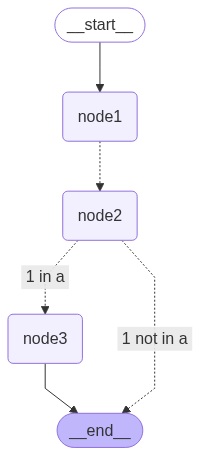

In [ ]:
from IPython.display import Image, display

display(Image(g.get_graph().draw_mermaid_png()))

In [4]:
g.invoke(
    input={
        'a': [['1'], ['2'], ['3']]
    }
)

2025-06-27 18:49:29.483 | INFO     | __main__:node1:16 - node1: {'a': [['1'], ['2'], ['3']]}
2025-06-27 18:49:29.485 | INFO     | __main__:node1_to_node2:23 - node1_to_node2: {'a': [['1'], ['2'], ['3'], ['node1 1'], ['node1 2']]}
2025-06-27 18:49:29.823 | INFO     | __main__:node2:37 - node2: {'b': ['1']}
2025-06-27 18:49:29.826 | INFO     | __main__:node2:37 - node2: {'b': ['2']}
2025-06-27 18:49:29.827 | INFO     | __main__:node2:37 - node2: {'b': ['3']}
2025-06-27 18:49:29.828 | INFO     | __main__:is_1_in_a:48 - is_1_in_a: {}
2025-06-27 18:49:29.831 | INFO     | __main__:node2:37 - node2: {'b': ['node1 1']}
2025-06-27 18:49:29.833 | INFO     | __main__:is_1_in_a:48 - is_1_in_a: {}
2025-06-27 18:49:29.834 | INFO     | __main__:node2:37 - node2: {'b': ['node1 2']}
2025-06-27 18:49:29.838 | INFO     | __main__:is_1_in_a:48 - is_1_in_a: {}
2025-06-27 18:49:29.842 | INFO     | __main__:is_1_in_a:48 - is_1_in_a: {}
2025-06-27 18:49:29.849 | INFO     | __main__:is_1_in_a:48 - is_1_in_a: {

KeyError: 'a'

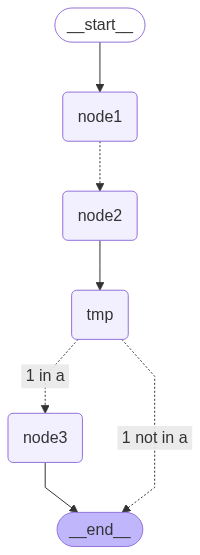

In [6]:
# 加上了 tmp 节点的情况
from IPython.display import Image, display

display(Image(g.get_graph().draw_mermaid_png()))

In [7]:
g.invoke(
    input={
        'a': [['1'], ['2'], ['3']]
    }
)

2025-06-27 18:51:00.495 | INFO     | __main__:node1:16 - node1: {'a': [['1'], ['2'], ['3']]}
2025-06-27 18:51:00.498 | INFO     | __main__:node1_to_node2:23 - node1_to_node2: {'a': [['1'], ['2'], ['3'], ['node1 1'], ['node1 2']]}
2025-06-27 18:51:00.504 | INFO     | __main__:node2:37 - node2: {'b': ['1']}
2025-06-27 18:51:00.508 | INFO     | __main__:node2:37 - node2: {'b': ['2']}
2025-06-27 18:51:00.509 | INFO     | __main__:node2:37 - node2: {'b': ['3']}
2025-06-27 18:51:00.509 | INFO     | __main__:node2:37 - node2: {'b': ['node1 1']}
2025-06-27 18:51:00.510 | INFO     | __main__:node2:37 - node2: {'b': ['node1 2']}
2025-06-27 18:51:00.551 | INFO     | __main__:is_1_in_a:48 - is_1_in_a: {'a': [['1', 1], ['2', 1], ['3', 1], ['node1 1', 1], ['node1 2', 1]]}
2025-06-27 18:51:00.555 | INFO     | __main__:node3:57 - node3: {'a': [['1', 1], ['2', 1], ['3', 1], ['node1 1', 1], ['node1 2', 1]]}


{'a': [['1', 1], ['2', 1], ['3', 1], ['node1 1', 1], ['node1 2', 1]]}

*2025.06.19*

在现在的实现中，存在这样一个问题: 无法获得、追踪递归过程中「某个图」的状态。这样就无法重建出搜索树

现在的实现逻辑是没有什么问题的: 如果生成了一个新问题，我们会在 Judge 子图的 call_new_rag 节点中生成一个新的 thread_id，并使用在 Judge 节点中生成的新问题递归调用一次 RAG with Judge。并使用这次 RAG with Judge 的结果更新当前检索到内容（拼接到尾部），使其是「知识完备的」

在 LangSmith 中，若「从图的某一个节点中对图发起递归调用」，则该调用的记录也就应当属于当前父记录下的一条，LangSmith 对这样情况的处理逻辑是对的。之前的问题是：这些递归过程中的调用记录是不可追踪的

LangSmith 对调用记录的处理的方式为：

1. 如果调用是从图外发起的，则对应图的调用记录将会在 LangSmith 中占据单独的一条记录
2. 如果调用是从图内部的某个节点发起的，则所有递归调用图的记录将会附属于最初调用的 LangSmith 记录下。层级结构和递归调用过程一致

现在的问题是：<font color='red'>如何获得、追踪递归过程中「某个图」的状态</font>

一个可以的解决方法为：

在需要递归调用图时，运行时配置重新配置一遍，不要使用 copy.copy() 

这样方法的原理还不了解，要说是因为「config 在不同的递归调用间共享」的话，经过试验发现。即使使用 copy.copy() config 中各个键值对的内存地址是不同的，和「重新配置」的行为是一致的

最大的可能是由于 LangGraph 框架内部的一些特性。但是 LangGraph 框架封装的太深了，不好调试明白

在 LangChain Community 讨论的连接在[这里](https://app.slack.com/client/T05P4BNF01J/C06PTQF6MCK)

In [1]:
# 下面是一些试验证明
import copy
import operator
from uuid import uuid4
from typing import TypedDict, Annotated, List
from loguru import logger as log

from langchain_core.runnables import RunnableConfig
from langgraph.graph import START, StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

当从图外部发起调用时，不同的调用在 LangSmith 中将会占用一条单独的记录

下面代码块对应的 LangSmith 记录链接在这里：

1. [第一次调用](https://smith.langchain.com/o/479009a7-c242-423d-948f-7742246e66a8/projects/p/5c002256-3cec-4d89-925c-99d6a8873056?timeModel=%7B%22duration%22%3A%2214d%22%7D&mode=graph&runtab=0&peek=29d4a3cc-130f-4e4e-96f7-4f7412d7b865&peeked_trace=29d4a3cc-130f-4e4e-96f7-4f7412d7b865)

2. [第二次调用](https://smith.langchain.com/o/479009a7-c242-423d-948f-7742246e66a8/projects/p/5c002256-3cec-4d89-925c-99d6a8873056?timeModel=%7B%22duration%22%3A%2214d%22%7D&mode=graph&runtab=2&peek=82a09870-a733-41c7-9a55-fc12e808a89a&peeked_trace=82a09870-a733-41c7-9a55-fc12e808a89a)

3. [第三次调用](https://smith.langchain.com/o/479009a7-c242-423d-948f-7742246e66a8/projects/p/5c002256-3cec-4d89-925c-99d6a8873056?timeModel=%7B%22duration%22%3A%2214d%22%7D&mode=graph&runtab=2&peek=4a052623-b96c-4e5e-a460-aa927c3ffbfb&peeked_trace=4a052623-b96c-4e5e-a460-aa927c3ffbfb)

In [4]:
# 定义一个简单的图
class SimpleState(TypedDict):
    a: int 


def node1(state: SimpleState, config: RunnableConfig) -> SimpleState:
    log.info("node1")

    return {'a': state['a'] + 1}


simple_wf = StateGraph(SimpleState)
simple_wf.add_node('node1', node1)
simple_wf.add_edge(START, 'node1')
simple_wf.add_edge('node1', END)

# 编译获得图
memory = MemorySaver()
simple_g = simple_wf.compile(checkpointer=memory)

# 定义运行时配置
config = {
    'configurable': {
        'thread_id': '1',
    }
}

In [5]:
for _ in range(3):
    # 运行图
    res = simple_g.invoke(
        input={'a': 0},
        config=config
    )

    config['configurable']['thread_id'] = str(uuid4())
    print(res)
    print(f'next thread_id: {config["configurable"]["thread_id"]}')

2025-06-26 10:02:05.202 | INFO     | __main__:node1:7 - node1
2025-06-26 10:02:05.210 | INFO     | __main__:node1:7 - node1
2025-06-26 10:02:05.216 | INFO     | __main__:node1:7 - node1


{'a': 1}
next thread_id: 2daf8820-15d8-4cfd-898c-09366c034d35
{'a': 1}
next thread_id: d042b35b-16b0-4cb6-a977-ccb8ffc7e2db
{'a': 1}
next thread_id: 9841a8b8-2357-40ea-afa1-8093708d5646


In [6]:
list(simple_g.get_state_history(config={'configurable': {'thread_id': '2daf8820-15d8-4cfd-898c-09366c034d35'}}))

[StateSnapshot(values={'a': 1}, next=(), config={'configurable': {'thread_id': '2daf8820-15d8-4cfd-898c-09366c034d35', 'checkpoint_ns': '', 'checkpoint_id': '1f052318-edbc-6c41-8001-4391bf515c6c'}}, metadata={'source': 'loop', 'writes': {'node1': {'a': 1}}, 'thread_id': '2daf8820-15d8-4cfd-898c-09366c034d35', 'step': 1, 'parents': {}}, created_at='2025-06-26T02:02:05.212985+00:00', parent_config={'configurable': {'thread_id': '2daf8820-15d8-4cfd-898c-09366c034d35', 'checkpoint_ns': '', 'checkpoint_id': '1f052318-edb5-6718-8000-2566dea6b9a9'}}, tasks=()),
 StateSnapshot(values={'a': 0}, next=('node1',), config={'configurable': {'thread_id': '2daf8820-15d8-4cfd-898c-09366c034d35', 'checkpoint_ns': '', 'checkpoint_id': '1f052318-edb5-6718-8000-2566dea6b9a9'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '2daf8820-15d8-4cfd-898c-09366c034d35', 'step': 0, 'parents': {}}, created_at='2025-06-26T02:02:05.209986+00:00', parent_config={'configurable': {'thread_id': '2daf8820-15d8-4

当调用行为是从图内部某个节点发起的时，所有递归调用图的记录将会附属于最初调用的 LangSmith 记录下，层级结构和递归调用过程一致。这是可以理解的，这样也符合实际的调用过程。之前的问题在于无法利用 thread_id 追踪递归过程中图的状态

现在的解决方法是：在需要递归调用图时，重新配置一遍运行时配置，不使用 copy.copy()

这样做可以使得递归过程中任何一个图的状态都可以通过 thread_id 检索得到。而 copy.copy() 不能达到同样的效果是令人困惑的，因为在下面的试验中可以看到：由「copy.copy()」和「重新配置」所得到的 config 及其中所有键值对中值的内存地址都是相互不一样的，config 在不同的递归调用过程中并没有「被共享」

排除了「copy.copy() 可能会造成 config 在不同图的调用中被共享的可能」后，最可能的原因是：LangGraph 框架内部的一些特性。在 LangChain Community 中，Vic 也认可这是由于 LangGraph 框架内部的一些特性导致的

从图内部的某个节点发起调用，使用 copy.copy() 配置递归调用图所需的 config 

下方代码块对应图调用记录的 LangSmith 链接在[这里](https://smith.langchain.com/o/479009a7-c242-423d-948f-7742246e66a8/projects/p/5c002256-3cec-4d89-925c-99d6a8873056?timeModel=%7B%22duration%22%3A%2214d%22%7D&mode=graph&runtab=2&peek=bf73a33b-67a0-4702-8f4a-2c32fb965c34&peeked_trace=7ed990f2-44f6-4060-a39b-8fc8128da1d6)。可以着重关注一下调用记录中的「Metadata」选项中的「langgraph_checkpoint_ns」键值对的值

In [11]:
# 定义一个会从节点内部发起（图）调用的图
class CallState(TypedDict):
    cur_depth: int
    all_thread_ids: Annotated[List[str], operator.add]


def node1(state: CallState, config: RunnableConfig) -> CallState:
    log.info("node1")
    log.info(f"Current thread_id: {config['configurable']['thread_id']}")

    # 输出当前图所接受的 config 及其内部所有键值对的内存地址
    log.info(f'id(config) = {id(config)}')
    log.info(f'id(config["configurable"]) = {id(config["configurable"])}')
    log.info(f'id(config["configurable]["thread_id"]) = {id(config["configurable"]["thread_id"])}')
    log.info(f'id(config["configurable"]["graph"]) = {id(config["configurable"]["graph"])}')

    return {'cur_depth': state['cur_depth'] + 1}

def node2(state: CallState, config: RunnableConfig) -> CallState:
    log.info("node2")

    state['all_thread_ids'].append('hello')

    next_thread_id = str(uuid4())
    # Approach 1
    # new_config = {
    #     'configurable': {
    #         'thread_id': next_thread_id,
    #         'graph': config['configurable']['graph']
    #     }
    # }
    # Approach 2
    new_config = {
        'configurable': copy.copy(config['configurable'])
    }
    new_config['configurable']['thread_id'] = next_thread_id
    
    g = config["configurable"]["graph"]
    log.info(f'current graph id = {id(g)}')

    g.invoke(
        input={'cur_depth': state['cur_depth']},
        config=new_config
    )

    return {'all_thread_ids': [next_thread_id]}

def router_by_rec_depth(state: CallState) -> str:
    log.info("router_by_rec_depth")
    if state['cur_depth'] > 3:
        return 'end'
    else:
        return 'continue'

# 定义图
call_wf = StateGraph(CallState)
call_wf.add_node('node1', node1)
call_wf.add_node('node2', node2)
call_wf.add_edge(START, 'node1')
call_wf.add_conditional_edges(
    'node1',
    router_by_rec_depth,
    {
        'continue': 'node2',
        'end': END
    }
)
call_wf.add_edge('node2', END)

# 编译获得图
memory = MemorySaver()
graph = call_wf.compile(checkpointer=memory)

# 定义运行时配置
config = {
    'configurable': {
        'thread_id': '1',
        'graph': graph
    }
}

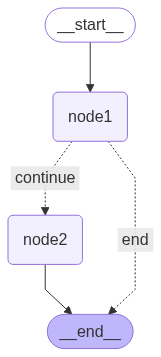

In [3]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke(
    input={'cur_depth': 0},
    config=config
)

2025-06-26 12:04:46.265 | INFO     | __main__:node1:8 - node1
2025-06-26 12:04:46.266 | INFO     | __main__:node1:9 - Current thread_id: 1
2025-06-26 12:04:46.267 | INFO     | __main__:node1:12 - id(config) = 2832026065984
2025-06-26 12:04:46.267 | INFO     | __main__:node1:13 - id(config["configurable"]) = 2832025996032
2025-06-26 12:04:46.267 | INFO     | __main__:node1:14 - id(config["configurable]["thread_id"]) = 140724748305728
2025-06-26 12:04:46.268 | INFO     | __main__:node1:15 - id(config["configurable"]["graph"]) = 2832025687856
2025-06-26 12:04:46.270 | INFO     | __main__:router_by_rec_depth:49 - router_by_rec_depth
2025-06-26 12:04:46.270 | INFO     | __main__:node2:20 - node2
2025-06-26 12:04:46.274 | INFO     | __main__:node2:39 - current graph id = 2832025687856
2025-06-26 12:04:46.281 | INFO     | __main__:node1:8 - node1
2025-06-26 12:04:46.282 | INFO     | __main__:node1:9 - Current thread_id: 4053ba61-5837-49c9-baf6-b92fb1e29072
2025-06-26 12:04:46.283 | INFO     |

{'cur_depth': 1,
 'all_thread_ids': ['hello', '4053ba61-5837-49c9-baf6-b92fb1e29072']}

当使用 copy.copy() 配置下次图调用所需的 config，上面的四次递归调用的过程中，图所接受的 config 及其内部所有键值对的内存地址如下表所示：

| thread_id | id(config) | id(config["configurable"]) | id(config["configurable"]\["thread_id"]) | id(config["configurable"]\["graph"]) |
| --- | --- | --- | --- | --- |
| 1 | 2832026065984 | 2832025996032 | 140724748305728 | 2832025687856 |
| 4053ba61-5837-49c9-baf6-b92fb1e29072 | 2832026002816 | 2832025935360 | 2832025712192 | 2832025687856 |
| 34fd3948-c32c-4d58-b289-a0149ae02588 | 2832026010688 | 2832026078720 | 2832025910960 | 2832025687856 |
| 3254f1ee-fa02-4df7-adc5-8283d3a51cd3 | 2832026177536 | 2832026181760 | 2832026142720 | 2832025687856 |

从上面的表格中可以看出，由 copy.copy() 所得到的 config 及其中所有键值对中值的内存地址都是相互不一样的，config 在不同的递归调用过程中并没有「被共享」

<font color='red'>但是刚刚第一次调用时，似乎 config 的内存地址是相同的？ 要之后多试验几次，当然是在一个另一个单独的 notebook 里</font>

下面的代码证明了：除了第一次图外的调用外，递归过程中的任何一个图的状态都是无法检索的

In [13]:
list(graph.get_state_history(config={'configurable': {'thread_id': '1'}}))

[StateSnapshot(values={'cur_depth': 1, 'all_thread_ids': ['hello', '4053ba61-5837-49c9-baf6-b92fb1e29072']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05242b-26c8-620a-8002-d19adf362252'}}, metadata={'source': 'loop', 'writes': {'node2': {'all_thread_ids': ['4053ba61-5837-49c9-baf6-b92fb1e29072']}}, 'thread_id': '1', 'step': 2, 'parents': {}}, created_at='2025-06-26T04:04:46.326017+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05242b-2640-6a83-8001-16a77849b9a1'}}, tasks=()),
 StateSnapshot(values={'cur_depth': 1, 'all_thread_ids': []}, next=('node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05242b-2640-6a83-8001-16a77849b9a1'}}, metadata={'source': 'loop', 'writes': {'node1': {'cur_depth': 1}}, 'thread_id': '1', 'step': 1, 'parents': {}}, created_at='2025-06-26T04:04:46.270528+00:00', parent_config={'configurable': {'thread_id': '1', 'che

In [14]:
list(graph.get_state_history(config={'configurable': {'thread_id': '4053ba61-5837-49c9-baf6-b92fb1e29072'}}))

[]

从图内部的某个节点发起调用，使用「重新定义 config」来配置递归调用图所需的 config 

下方代码块对应图调用记录的 LangSmith 链接在[这里](https://smith.langchain.com/o/479009a7-c242-423d-948f-7742246e66a8/projects/p/5c002256-3cec-4d89-925c-99d6a8873056?timeModel=%7B%22duration%22%3A%2214d%22%7D&mode=graph&runtab=2&peek=bb47d684-59cc-4feb-8342-a7f4148f41de&peeked_trace=28bcf9c3-e688-4908-bfa9-6bb70cc8d4ec)。可以着重关注一下调用记录中的「Metadata」选项中的「langgraph_checkpoint_ns」键值对的值，和使用 copy.copy() 时是不同的，这里的并没有那么多前置调用节点

In [5]:
# 定义一个会从节点内部发起（图）调用的图
class CallState(TypedDict):
    cur_depth: int
    all_thread_ids: Annotated[List[str], operator.add]


def node1(state: CallState, config: RunnableConfig) -> CallState:
    log.info("node1")
    log.info(f"Current thread_id: {config['configurable']['thread_id']}")

    # 输出当前图所接受的 config 及其内部所有键值对的内存地址
    log.info(f'id(config) = {id(config)}')
    log.info(f'id(config["configurable"]) = {id(config["configurable"])}')
    log.info(f'id(config["configurable]["thread_id"]) = {id(config["configurable"]["thread_id"])}')
    log.info(f'id(config["configurable"]["graph"]) = {id(config["configurable"]["graph"])}')

    return {'cur_depth': state['cur_depth'] + 1}

def node2(state: CallState, config: RunnableConfig) -> CallState:
    log.info("node2")

    state['all_thread_ids'].append('hello')

    next_thread_id = str(uuid4())
    # Approach 1
    new_config = {
        'configurable': {
            'thread_id': next_thread_id,
            'graph': config['configurable']['graph']
        }
    }
    # Approach 2
    # new_config = {
    #     'configurable': copy.copy(config['configurable'])
    # }
    # new_config['configurable']['thread_id'] = next_thread_id
    
    g = config["configurable"]["graph"]
    log.info(f'current graph id = {id(g)}')

    g.invoke(
        input={'cur_depth': state['cur_depth']},
        config=new_config
    )

    return {'all_thread_ids': [next_thread_id]}

def router_by_rec_depth(state: CallState) -> str:
    log.info("router_by_rec_depth")
    if state['cur_depth'] > 3:
        return 'end'
    else:
        return 'continue'

# 定义图
call_wf = StateGraph(CallState)
call_wf.add_node('node1', node1)
call_wf.add_node('node2', node2)
call_wf.add_edge(START, 'node1')
call_wf.add_conditional_edges(
    'node1',
    router_by_rec_depth,
    {
        'continue': 'node2',
        'end': END
    }
)
call_wf.add_edge('node2', END)

# 编译获得图
memory = MemorySaver()
graph = call_wf.compile(checkpointer=memory)

# 定义运行时配置
config = {
    'configurable': {
        'thread_id': '1',
        'graph': graph
    }
}

In [6]:
graph.invoke(
    input={'cur_depth': 0},
    config=config
)

2025-06-26 11:18:48.098 | INFO     | __main__:node1:8 - node1
2025-06-26 11:18:48.099 | INFO     | __main__:node1:9 - Current thread_id: 1
2025-06-26 11:18:48.100 | INFO     | __main__:node1:12 - id(config) = 2832025790848
2025-06-26 11:18:48.100 | INFO     | __main__:node1:13 - id(config["configurable"]) = 2832025774464
2025-06-26 11:18:48.100 | INFO     | __main__:node1:14 - id(config["configurable]["thread_id"]) = 140724748305728
2025-06-26 11:18:48.101 | INFO     | __main__:node1:15 - id(config["configurable"]["graph"]) = 2832025385440
2025-06-26 11:18:48.102 | INFO     | __main__:router_by_rec_depth:49 - router_by_rec_depth
2025-06-26 11:18:48.104 | INFO     | __main__:node2:20 - node2
2025-06-26 11:18:48.105 | INFO     | __main__:node2:39 - current graph id = 2832025385440
2025-06-26 11:18:48.111 | INFO     | __main__:node1:8 - node1
2025-06-26 11:18:48.112 | INFO     | __main__:node1:9 - Current thread_id: 8f941006-f26e-49ab-a90e-d0a3c82bfb79
2025-06-26 11:18:48.113 | INFO     |

{'cur_depth': 1,
 'all_thread_ids': ['hello', '8f941006-f26e-49ab-a90e-d0a3c82bfb79']}

当使用「重新定义 config」来配置下次图调用所需的 config，上面的四次递归调用的过程中，图所接受的 config 及其内部所有键值对的内存地址如下表所示：

| thread_id | id(config) | id(config["configurable"]) | id(config["configurable"]\["thread_id"]) | id(config["configurable"]\["graph"]) |
| --- | --- | --- | --- | --- |
| 1 | 2832025790848 | 2832025774464 | 140724748305728 | 2832025385440 |
| 8f941006-f26e-49ab-a90e-d0a3c82bfb79 | 2832025481536 | 2832025477696 | 2832025411280 | 2832025385440 |
| 3db61f11-6f40-47f9-968f-05e4746e4720 | 2832025801024 | 2832025800640 | 2832025315376 | 2832025385440 |
| 4c67166a-4d56-4529-b493-47e5eb41d0c8 | 2832025888768 | 2832025888384 | 2832025700512 | 2832025385440 |

从上面的表格中可以看出，由「重新定义 config」所得到的 config 及其中所有键值对中值的内存地址都是相互不一样的，config 在不同的递归调用过程中并没有「被共享」

下面也证明了任何递归过程中图的状态都可以通过对应的 thread_id 检索到

In [7]:
list(graph.get_state_history(config={'configurable': {'thread_id': '1'}}))

[StateSnapshot(values={'cur_depth': 1, 'all_thread_ids': ['hello', '8f941006-f26e-49ab-a90e-d0a3c82bfb79']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0523c4-66c3-6d0c-8002-65fea92988af'}}, metadata={'source': 'loop', 'writes': {'node2': {'all_thread_ids': ['8f941006-f26e-49ab-a90e-d0a3c82bfb79']}}, 'thread_id': '1', 'step': 2, 'parents': {}}, created_at='2025-06-26T03:18:48.149940+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0523c4-6655-6bc1-8001-faba55723ebd'}}, tasks=()),
 StateSnapshot(values={'cur_depth': 1, 'all_thread_ids': []}, next=('node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0523c4-6655-6bc1-8001-faba55723ebd'}}, metadata={'source': 'loop', 'writes': {'node1': {'cur_depth': 1}}, 'thread_id': '1', 'step': 1, 'parents': {}}, created_at='2025-06-26T03:18:48.104851+00:00', parent_config={'configurable': {'thread_id': '1', 'che

In [8]:
list(graph.get_state_history(config={'configurable': {'thread_id': '8f941006-f26e-49ab-a90e-d0a3c82bfb79'}}))

[StateSnapshot(values={'cur_depth': 2, 'all_thread_ids': ['hello', '3db61f11-6f40-47f9-968f-05e4746e4720']}, next=(), config={'configurable': {'thread_id': '8f941006-f26e-49ab-a90e-d0a3c82bfb79', 'checkpoint_ns': '', 'checkpoint_id': '1f0523c4-66be-6ef2-8002-e4bea0afa349'}}, metadata={'source': 'loop', 'writes': {'node2': {'all_thread_ids': ['3db61f11-6f40-47f9-968f-05e4746e4720']}}, 'thread_id': '1', 'langgraph_step': 2, 'langgraph_node': 'node2', 'langgraph_triggers': ['branch:node1:router_by_rec_depth:node2'], 'langgraph_path': ['__pregel_pull', 'node2'], 'langgraph_checkpoint_ns': 'node2:d4202726-dfe3-fe02-0814-68d896136a34', 'step': 2, 'parents': {}}, created_at='2025-06-26T03:18:48.147941+00:00', parent_config={'configurable': {'thread_id': '8f941006-f26e-49ab-a90e-d0a3c82bfb79', 'checkpoint_ns': '', 'checkpoint_id': '1f0523c4-6677-6e54-8001-afea4f1eb479'}}, tasks=()),
 StateSnapshot(values={'cur_depth': 2, 'all_thread_ids': []}, next=('node2',), config={'configurable': {'thread_

In [9]:
list(graph.get_state_history(config={'configurable': {'thread_id': '3db61f11-6f40-47f9-968f-05e4746e4720'}}))

[StateSnapshot(values={'cur_depth': 3, 'all_thread_ids': ['hello', '4c67166a-4d56-4529-b493-47e5eb41d0c8']}, next=(), config={'configurable': {'thread_id': '3db61f11-6f40-47f9-968f-05e4746e4720', 'checkpoint_ns': '', 'checkpoint_id': '1f0523c4-66b7-6a50-8002-921f705482a9'}}, metadata={'source': 'loop', 'writes': {'node2': {'all_thread_ids': ['4c67166a-4d56-4529-b493-47e5eb41d0c8']}}, 'thread_id': '1', 'langgraph_step': 2, 'langgraph_node': 'node2', 'langgraph_triggers': ['branch:node1:router_by_rec_depth:node2'], 'langgraph_path': ['__pregel_pull', 'node2'], 'langgraph_checkpoint_ns': 'node2:b4aac3ed-49ca-bd2a-7c0d-8881c2dcbb0b', 'step': 2, 'parents': {}}, created_at='2025-06-26T03:18:48.144955+00:00', parent_config={'configurable': {'thread_id': '3db61f11-6f40-47f9-968f-05e4746e4720', 'checkpoint_ns': '', 'checkpoint_id': '1f0523c4-6695-676a-8001-72b12342a32e'}}, tasks=()),
 StateSnapshot(values={'cur_depth': 3, 'all_thread_ids': []}, next=('node2',), config={'configurable': {'thread_

In [10]:
list(graph.get_state_history(config={'configurable': {'thread_id': '4c67166a-4d56-4529-b493-47e5eb41d0c8'}}))

[StateSnapshot(values={'cur_depth': 4, 'all_thread_ids': []}, next=(), config={'configurable': {'thread_id': '4c67166a-4d56-4529-b493-47e5eb41d0c8', 'checkpoint_ns': '', 'checkpoint_id': '1f0523c4-66b2-6c34-8001-d278996bbfa1'}}, metadata={'source': 'loop', 'writes': {'node1': {'cur_depth': 4}}, 'thread_id': '1', 'langgraph_step': 2, 'langgraph_node': 'node2', 'langgraph_triggers': ['branch:node1:router_by_rec_depth:node2'], 'langgraph_path': ['__pregel_pull', 'node2'], 'langgraph_checkpoint_ns': 'node2:66c94afb-2c66-d63c-4a2a-33a6e1410a24', 'step': 1, 'parents': {}}, created_at='2025-06-26T03:18:48.142955+00:00', parent_config={'configurable': {'thread_id': '4c67166a-4d56-4529-b493-47e5eb41d0c8', 'checkpoint_ns': '', 'checkpoint_id': '1f0523c4-66a1-6abc-8000-183993632a6f'}}, tasks=()),
 StateSnapshot(values={'cur_depth': 3, 'all_thread_ids': []}, next=('node1',), config={'configurable': {'thread_id': '4c67166a-4d56-4529-b493-47e5eb41d0c8', 'checkpoint_ns': '', 'checkpoint_id': '1f0523c

*2025.06.04*

Q1: 如果在循环中，每次调用图时都重新编译一次是否可以实现

当然，不够这种情况下，每次所调用的图是不一样的，其内存地址将是不同的

In [ ]:
from langgraph.graph import START, StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

import operator
from typing import TypedDict, List, Annotated

class MyGraphState(TypedDict):
    a: str
    b: Annotated[List[str], operator.add]
    c: Annotated[List[str], operator.add]


def node_1(state: MyGraphState) -> MyGraphState:
    state['a'] = 'hello'
    state['c'].append('2')
    state['c'][1] = '100'

    return {'a': 'world','b': ['2']}


wf = StateGraph(MyGraphState)
wf.add_node('node1', node_1)
wf.add_edge(START, "node1")
wf.add_edge("node1", END)

memory = MemorySaver()

g = wf.compile(checkpointer=memory)

In [ ]:
from uuid import uuid4

for _ in range(3):
    # 重新编译获得图
    memory = MemorySaver()
    g = wf.compile(checkpointer=memory)

    # 向图传入不同的 thread_id
    res = g.invoke(
        input={'b': ['1'], 'c': ['1']},
        # config=RunnableConfig(thread_id=str(uuid4()))
        # config={
        #     'configurable': {
        #         'thread_id': str(uuid4()),
        #     }
        # }
        config={
            'configurable': {
                'thread_id': '1',
            }
        }

    )
    print(res)

*2025.06.03*

在 LangGraph 中，不是可以通过传入不同的 thread_id 来实现不同的记忆吗

当然是可以的，之前的问题是「无法追踪递归过程中图的状态」。而当你存入不同的 thread_id 后，相当于用新的记忆重新调用了一次图（真重开），只不过你没办法追踪这次「重开」的过程而已

In [ ]:
from langgraph.graph import START, StateGraph, END
from langgraph.types import Send
from langchain_core.documents import Document
from typing import TypedDict, List, Annotated
import operator


# Define subgraph
class SubgraphState(TypedDict):
    similar_chunk: List[Document]
    bar: str

def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}

def subgraph_node_2(state: SubgraphState):
    state['similar_chunk'][0].page_content = 'hello again'
    return 

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph_builder.add_edge("subgraph_node_2", END)
subgraph = subgraph_builder.compile()

# Define parent graph
class ParentState(TypedDict):
    similar_chunks: List[Document]

def node_1(state: ParentState):
    # 在这里，即使我没有通过字典显示返回 similar_chunks 这个通道的更新
    # 但是我仍通过引用修改了这个通道的值
    state['similar_chunks'][0].page_content = 'hello world'

    return 

# node_1 和 node_2 之间通过 Send API 传递数据，因为这里父子图间并没有共享键
def node1_to_node2(state: ParentState):
    return [
        Send(
            'node_2',
            {
                'similar_chunk': [state['similar_chunks'][1]],
            }
        )
    ]

def node_3(state: ParentState):
    # 这里的 state['similar_chunks'] 仍然是父图的值
    state['similar_chunks'][0].page_content = 'hello world again'
    return


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_conditional_edges(
    'node_1',
    node1_to_node2,
    # ['node_2']
    ['node_2', 'node_3']  # sd1
)
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)
graph = builder.compile()

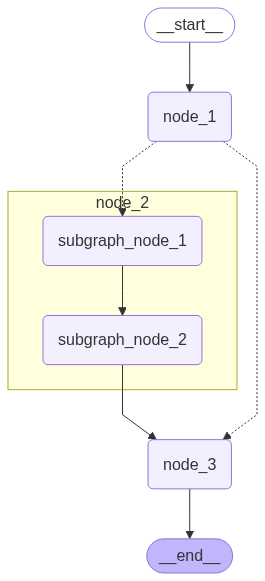

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

*2025.06.02*

Q1: 该怎么复制运行时配置呢？

copy config['configurable'] 这一个字典即可

In [2]:
import os
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI


load_dotenv()

llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-max-latest',
    temperature=0.0
)

In [16]:
run_config = {
    'configurable': {
        # 'vector_store': vector_store,
        'top_k': 3,
        'llm': llm,
        'thread_id': '1',
        'recursion_depth': 0,
        'graph': graph  # graph 的定义在下一个单元格中
    }
}

In [17]:
import copy

new_config1 = {
    'configurable': copy.copy(run_config['configurable'])
}

new_config2 = copy.copy(run_config)

In [18]:
id(run_config), id(new_config1), id(new_config2)

(1353020460416, 1353020460992, 1353020461312)

In [19]:
# 可以看到 copy 只是为嵌套对象的第一次新建了一个引用
# run_config['configurable'] 和 new_config2['configurable'] 指向的是「同一个对象」
id(run_config['configurable']), id(new_config1['configurable']), id(new_config2['configurable'])

(1353020519616, 1353020463616, 1353020519616)

In [21]:
# new_config1['configurable']['recursion_depth'] = new_config1['configurable']['recursion_depth'] + 1
new_config1['configurable']['recursion_depth'] += 1
new_config2['configurable']['recursion_depth'] += 100

run_config, new_config1, new_config2

({'configurable': {'top_k': 3,
   'llm': ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x0000013B04F42750>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x0000013B04F78980>, root_client=<openai.OpenAI object at 0x0000013B04911EB0>, root_async_client=<openai.AsyncOpenAI object at 0x0000013B04F427B0>, model_name='qwen-max-latest', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://dashscope.aliyuncs.com/compatible-mode/v1'),
   'thread_id': '1',
   'recursion_depth': 200,
   'graph': <langgraph.graph.state.CompiledStateGraph at 0x13b043366c0>}},
 {'configurable': {'top_k': 3,
   'llm': ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x0000013B04F42750>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x0000013B04F78980>, root_client=<openai.OpenAI object at 0x0000013B04911EB0>, root_async_client=<openai.AsyncOpenAI object at 0x00

*2025.06.02*

Q1: 若向父图的某个通道是可变对象，在父图中利用该通道的值调用子图，在子图中通过引用更改父图传递的值，父图中的值会改变吗？

是会改变的，利用可变对象的「引用」来改变值是很方便的。只要不将改变后的值通过键值对的形式返回，就不会触发这个通道的 reducer，从而对父图对应的通道造成影响

In [1]:
from langgraph.graph import START, StateGraph, END
from langgraph.types import Send
from langchain_core.documents import Document
from typing import TypedDict, List, Annotated
import operator


# Define subgraph
class SubgraphState(TypedDict):
    similar_chunk: List[Document]
    bar: str

def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}

def subgraph_node_2(state: SubgraphState):
    state['similar_chunk'][0].page_content = 'hello again'
    return 

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph_builder.add_edge("subgraph_node_2", END)
subgraph = subgraph_builder.compile()

# Define parent graph
class ParentState(TypedDict):
    similar_chunks: List[Document]

def node_1(state: ParentState):
    # 在这里，即使我没有通过字典显示返回 similar_chunks 这个通道的更新
    # 但是我仍通过引用修改了这个通道的值
    state['similar_chunks'][0].page_content = 'hello world'

    return 

# node_1 和 node_2 之间通过 Send API 传递数据，因为这里父子图间并没有共享键
def node1_to_node2(state: ParentState):
    return [
        Send(
            'node_2',
            {
                'similar_chunk': [state['similar_chunks'][1]],
            }
        )
    ]


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_conditional_edges(
    'node_1',
    node1_to_node2,
    ['node_2']
)
builder.add_edge("node_2", END)
graph = builder.compile()

In [5]:
doc1 = Document(
    page_content="I had chocalate chip pancakes and scrambled eggs for breakfast this morning.",
    metadata={"source": "tweet"},
)
doc2 = Document(
    page_content="The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
    metadata={"source": "news"},
)

doc3 = Document(
    page_content="Building an exciting new project with LangChain - come check it out!",
    metadata={"source": "tweet"},
)


docs = [doc1, doc2, doc3]

In [8]:
for chunk in graph.stream(
    input={'similar_chunks': docs},
    # stream_mode=['updates', 'values'],
    stream_mode='values',
    # subgraphs=True
):
    print(chunk)

{'similar_chunks': [Document(metadata={'source': 'tweet'}, page_content='hello world'), Document(metadata={'source': 'news'}, page_content='hello again'), Document(metadata={'source': 'tweet'}, page_content='Building an exciting new project with LangChain - come check it out!')]}


In [ ]:
# 可以发现，确实被改变了。通过引用改变值确实方便了一些，不必在为通道自定义 reducer

for doc in chunk['similar_chunks']:
    print(doc)

page_content='hello world' metadata={'source': 'tweet'}
page_content='hello again' metadata={'source': 'news'}
page_content='Building an exciting new project with LangChain - come check it out!' metadata={'source': 'tweet'}


*2025.06.01*

Q1: 看看 LangChain 检索器返回的 Document 对象是原始对象还是原始对象的 copy 或 deepcopy

返回的是原始 Document 对象的 deepcopy

至少 LangChain 中的 Milvus 集成是这样的，在其源码中可以发现，其是利用检索的内容重新构建了一个 Document 对象，以达到深复制的效果

In [3]:
import sys

# 需要把当前项目的根目录加到 sys.path 中，才能找到 modules 下的 Index 模块
sys.path.append(r'C:\Users\Lenovo\Desktop\RAG rebuild')

In [6]:
import os
from dotenv import load_dotenv
from loguru import logger as log

from modules.Index import Index
from NaiveRAG.workflow import get_naive_rag_workflow

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver

load_dotenv()

# 1. 定义嵌入模型、聊天模型、向量数据库
embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-max-latest',
    temperature=0.0
)

test1 = Index(
    embed_model=embed_model,
    data_path=r'C:\Users\Lenovo\Desktop\RAG rebuild\data',
    file_type_wanted={'.txt'},
    vector_store_name='test1'
)
test1.get_index_done()

2025-06-01 15:46:32.680 | INFO     | modules.Index:get_all_file_path:77 - 现在暂不支持处理 .pdf 类型的文件 C:\Users\Lenovo\Desktop\RAG rebuild\data\4. Tool calling.pdf
2025-06-01 15:46:32.680 | INFO     | modules.Index:get_all_file_path:77 - 现在暂不支持处理 .pdf 类型的文件 C:\Users\Lenovo\Desktop\RAG rebuild\data\6. LCEL.pdf
2025-06-01 15:46:32.680 | INFO     | modules.Index:get_all_file_path:77 - 现在暂不支持处理 .pdf 类型的文件 C:\Users\Lenovo\Desktop\RAG rebuild\data\Cognition_Engineering_zh.pdf
2025-06-01 15:46:32.680 | INFO     | modules.Index:get_all_file_path:77 - 现在暂不支持处理 .json 类型的文件 C:\Users\Lenovo\Desktop\RAG rebuild\data\hotpotqa_10.json
2025-06-01 15:46:32.680 | INFO     | modules.Index:get_all_file_path:79 - 已获取 0 份文件，忽略 4 份文件


In [ ]:
# 向定义的向量数据库中添加文档
from langchain_core.documents import Document

test1.vector_store.add_documents(
    documents=[
        Document(
            page_content="I had chocalate chip pancakes and scrambled eggs for breakfast this morning.",
            metadata={"source": "tweet"},
        )
    ],
    ids=['1']
)

['1']

In [ ]:
# 检索这个唯一的文档
res = test1.vector_store.similarity_search_with_score(query='I had chocalate chip pancakes and scrambled eggs for breakfast this morning.', k=1)

In [16]:
res

[(Document(metadata={'source': 'tweet', 'pk': '1'}, page_content='I had chocalate chip pancakes and scrambled eggs for breakfast this morning.'),
  0.0)]

In [17]:
doc = res[0][0]

In [19]:
tmp = doc
tmp.page_content = 'hello world'
id(doc), id(tmp)

(1518205953648, 1518205953648)

In [20]:
doc, tmp

(Document(metadata={'source': 'tweet', 'pk': '1'}, page_content='hello world'),
 Document(metadata={'source': 'tweet', 'pk': '1'}, page_content='hello world'))

In [ ]:
# 数据库中这个唯一的文档内容并没有改变，这样看 LangChain 向量数据库检索返回的应当是原始 Document 对象的 deepcopy
test1.vector_store.similarity_search_with_score(query='I had chocalate chip pancakes and scrambled eggs for breakfast this morning.', k=1)

[(Document(metadata={'source': 'tweet', 'pk': '1'}, page_content='I had chocalate chip pancakes and scrambled eggs for breakfast this morning.'),
  0.0)]

*2025.06.01*

Q1: LangChain 中的 Document 是否为可变对象

是可变对象。因此，如果你改变了某一个 Document 内容，那么该 Document 的所有引用都会被改变

因此，在之后的具体实现中，要注意这一点，当要改变 Document 对象的内容时要使用 copy

*2025.06.01*

Q1: 理解 python copy 模块中的 copy 和 deepcopy 

DeepSeek 的解释在[这里](https://chat.deepseek.com/a/chat/s/b4b7a5ea-9228-46d7-b8a9-08735ac8caf4)

1. copy 是浅拷贝，会为嵌套对象第一层所有的对象分别创建一个「新引用」，仅此而已，浅拷贝不会为其中任何一个对象创建副本

    因此，如果你要 copy 的对象内部都是「不可变对象」，这到没什么问题；而如果存在可变对象，则你对 copy 的返回值进行任何修改都会影响到源对象，因为 copy 只是创建了一个「新引用」而已

2. 而 deepcopy 则会递归的为嵌套对象的每一层对象都创建一个「完全独立的副本」，你对 deepcopy 的返回值进行任何修改都不会影响到源对象


In [5]:
from langchain_core.documents import Document

document_1 = Document(
    page_content="I had chocalate chip pancakes and scrambled eggs for breakfast this morning.",
    metadata={"source": "tweet"},
)

tmp = document_1
tmp.page_content = 'hello world'

In [6]:
id(document_1), id(tmp)

(2335022244608, 2335022244608)

In [8]:
document_1, tmp

(Document(metadata={'source': 'tweet'}, page_content='hello world'),
 Document(metadata={'source': 'tweet'}, page_content='hello world'))

In [9]:
import copy

tmp2 = copy.copy(document_1)
tmp2.page_content = 'hello again'

In [12]:
id(document_1), id(tmp), id(tmp2)

(2335022244608, 2335022244608, 2335021996688)

In [11]:
document_1, tmp, tmp2

(Document(metadata={'source': 'tweet'}, page_content='hello world'),
 Document(metadata={'source': 'tweet'}, page_content='hello world'),
 Document(metadata={'source': 'tweet'}, page_content='hello again'))

*2025.05.30*

Q1: 如果图中的一个通道被更新了，但在节点后没有返回，会在图的状态中体现出来吗？

不行，必须要将对通道的更新以「字典值」的方式返回才会生效

但是如果状态中某个通道是可变对象，就可以直接在某个节点中进行修改，修改后的状态会直接体现在图的状态中。前提是这个可变对象是有初始值的，这个初始值要么是在调用图时传入，要么是通过某个节点以字典值的方式返回更新得到的

In [24]:
from langgraph.graph import START, StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

import operator
from typing import TypedDict, List, Annotated

class MyGraphState(TypedDict):
    a: str
    b: Annotated[List[str], operator.add]
    c: Annotated[List[str], operator.add]


def node_1(state: MyGraphState) -> MyGraphState:
    state['a'] = 'hello'
    state['c'].append('2')
    state['c'][1] = '100'

    return {'a': 'world','b': ['2']}


wf = StateGraph(MyGraphState)
wf.add_node('node1', node_1)
wf.add_edge(START, "node1")
wf.add_edge("node1", END)

memory = MemorySaver()

g = wf.compile(checkpointer=memory)

In [25]:
a = g

id(a), id(g)

(2199502466864, 2199502466864)

In [ ]:
a_config = {
    'configurable': {
        'thread_id': '1',
        'graph': g
    }
}


for chunk in g.stream(
    input={'b': ['1'], 'c': ['1']},
    config=a_config,
    # stream_mode='updates'
    stream_mode='values'
    # stream_mode=['values', 'updates']
):
    print(chunk)

{'a': 'world', 'b': ['1', '2', '1'], 'c': ['1', '100', '1']}
{'a': 'world', 'b': ['1', '2', '1', '2'], 'c': ['1', '100', '1', '2']}


*2025.05.30*

学习 LangGraph 的流式输出

In [1]:
from langgraph.graph import START, StateGraph
from typing import TypedDict, List, Annotated
import operator


# Deffine sub sub graph
class SubSubgraphState(TypedDict):
    foo: str
    a: Annotated[List[int], operator.add]

def sub_subgraph_node_1(state: SubSubgraphState):
    return {'foo': state['foo'] + ' a', 'a': [1]}

def sub_subgraph_node_2(state: SubSubgraphState):
    return {'a': [2]}

sub_subgraph_builder = StateGraph(SubSubgraphState)
sub_subgraph_builder.add_node(sub_subgraph_node_1)
sub_subgraph_builder.add_node(sub_subgraph_node_2)
sub_subgraph_builder.add_edge(START, "sub_subgraph_node_1")
sub_subgraph_builder.add_edge("sub_subgraph_node_1", "sub_subgraph_node_2")
sub_subgraph = sub_subgraph_builder.compile()


# Define subgraph
class SubgraphState(TypedDict):
    foo: str  # note that this key is shared with the parent graph state
    bar: str

def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}

def subgraph_node_2(state: SubgraphState):
    return {"foo": state["foo"] + state["bar"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_node('subgraph_node_3', sub_subgraph)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph_builder.add_edge("subgraph_node_2", "subgraph_node_3")
subgraph = subgraph_builder.compile()

# Define parent graph
class ParentState(TypedDict):
    foo: str

def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}

builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

In [2]:
for chunk in graph.stream(
    {"foo": "foo"},
    # stream_mode="values",
    # stream_mode='updates',
    stream_mode=['values', 'updates'],
    # subgraphs=True, 
):
    print(chunk)

('values', {'foo': 'foo'})
('updates', {'node_1': {'foo': 'hi! foo'}})
('values', {'foo': 'hi! foo'})
('updates', {'node_2': {'foo': 'hi! foobar a'}})
('values', {'foo': 'hi! foobar a'})


*2025.05.26*

Q1: 在 langchain_milvus 中，使用 Milvus() 可以创建名字重复的 collection 吗？

langchain_milvus 不会创建一个名字相同的实例，具体分两种情况：

1. 如果这个重名的 collection 存在，但没有被加载到内存中，当你通过下面的代码试图创建 collection 时，langchain_milvus 的逻辑是「把对应的 collection 加载到内存中」

    ```python
    # 重新使用 ‘test1’ 为名字创建一个 collection
    tmp = Milvus(
        embedding_function=embed_model,
        collection_name="test1"
    )
    tmp_client = tmp.client

    print(tmp_client.list_collections())  # ['test1']

2. 如果这个重名的 collection 存在，并且已经被加载到内存中，则当你试图创建一个重名的 collection 时，langchain_milvus 的逻辑「什么也不干」，最终不过是：为重名的向量数据库创建了一个新的引用，多了一个连接到同一个数据库的 client 实例

In [19]:
from pymilvus.client.types import LoadState
a = vs1_client.get_load_state("test2")

In [20]:
type(a['state']), a['state']

(<enum 'LoadState'>, <LoadState: NotExist>)

In [22]:
a['state'] is LoadState.NotExist

True

In [1]:
import os
from dotenv import load_dotenv

from langchain_milvus import Milvus
from langchain_openai import OpenAIEmbeddings

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [2]:
# 在向量数据库里面创建一个名为 test1 的 collection
from langchain_core.documents import Document

vs1 = Milvus(
    embedding_function=embed_model,
    collection_name="test1"
)
vs1_client = vs1.client

print(vs1_client.list_collections())  # []

vs1.add_documents(
    documents= [
        Document(
            page_content="I had chocalate chip pancakes and scrambled eggs for breakfast this morning.",
            metadata={"source": "tweet"}
        )
    ],
    ids=["1"]
)

vs1_client.list_collections()  # ['test1']

[]


['test1']

In [3]:
# 把 collection test1 从当前内存中释放
print(vs1_client.get_load_state("test1"))

vs1_client.release_collection("test1")

print(vs1_client.get_load_state("test1"))

{'state': <LoadState: Loaded>}
{'state': <LoadState: NotLoad>}


In [4]:
# 重新使用 ‘test1’ 为名字创建一个 collection
tmp = Milvus(
    embedding_function=embed_model,
    collection_name="test1"
)
tmp_client = tmp.client

print(tmp_client.list_collections())  # ['test1']

['test1']


In [5]:
id(tmp_client), id(vs1_client)

(1642377484848, 1642375637584)

In [ ]:
# 从这里可以看到，当试图创建一个已经存在的 collection 时，langchain_milvus 的处理逻辑是「把对应名字的 collection 加载到内存中」
# 如果重名的 collection 已经在内存中了，则没有任何影响，不过是多了一个连接到同一个数据库的 client 实例
# 从下面那个问题中我们可以知道，client 实例并不绑定任何特定的 collection，而是与某个 Milvus 服务端（通常是一个数据库实例）绑定，client 可以操作这个服务端下的所有 collection（只要你知道 collection 的名字）

tmp2 = Milvus(
    embedding_function=embed_model,
    collection_name="test1"
)
tmp2_client = tmp2.client

print(tmp2_client.list_collections())  # ['test1']
id(tmp2_client), id(tmp_client)

['test1']


(1642378921360, 1642377484848)

*2025.05.26*

Q1: 在 langchain_milvus 中集成的 Vectorstore 中，为什么每个 Vectorstore 对应的 client 实例都不相同，但是它们之间还能够访问所有的 VectorStore（collection）

sub_q1: 为什么在 langchain_milvus 中集成的 Vectorstore 中，每个 Vectorstore 对应的 client 实例都不相同

sub_a1: 这是因为 LangChain 在封装时，当创建一个 vector store，就会调用一次 MilvusClient()，并且，如果不指定 url 参数，则默认使用 DEFAULT_MILVUS_CONNECTION（milvus.py 的 61 行）中的 url，这时不同的客户端实例所连接的将是同一个服务端。

总的来说，LangChain 封装的逻辑就是「一个向量数据库对应一个 client」。这种逻辑也是可以理解的，毕竟可能不会用那么多的向量数据库要创建，并且设置不同的 client 还可以对不同的向量数据库做一些个性化的配置，比如重试次数、最大时延等。

sub_q2: 在 Milvus 中，为什么不同的 client 可以操作所有 collection？

sub_a1: 这是因为在 Milvus 中，client 并不绑定任何特定的 collection，而是与某个 Milvus 服务端（通常是一个数据库实例）绑定，client 可以操作这个服务端下的所有 collection（只要你知道 collection 的名字）

可以将 client（客户端）理解为「通向同一服务端（数据库）的不同入口」

In [1]:
import os
from dotenv import load_dotenv

from langchain_milvus import Milvus
from langchain_openai import OpenAIEmbeddings

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [14]:
# 创建两个 vector store，并得到他们各自的 client
vs1 = Milvus(
    embedding_function=embed_model,
    collection_name="test1"
)

vs2 = Milvus(
    embedding_function=embed_model,
    collection_name="test2"
)

vs1_client = vs1.client
vs2_client = vs2.client

In [ ]:
# 可以看到 2 个 client 实际上指向了不同的 client 实例
print(id(vs1_client) == id(vs2_client))
id(vs1_client), id(vs2_client)

# 这是因为，在 LangChain_milvus 的封装中，在创建一个向量数据库时，会调用一次 MilvusClient（在 milvus.py 的 373 行）。并且，如果不指定 url 参数，则默认使用 DEFAULT_MILVUS_CONNECTION（milvus.py 的 61 行）中的 url，这时不同的客户端实例所连接的将是同一个服务端
# 所以，这导致了利用 langchain_milvus 创建的「不同向量数据库的 client 指向了不同的 MilvusClient 实例」

# 这也是可以理解的，一个向量数据库单独对应一个 client，可以单独对其设置一些参数，比如 重试次数、最大时延 等

False


(3012300373984, 3012300838656)

In [15]:
# 向两个数据库添加一些数据，使其具备有效负荷
from langchain_core.documents import Document

# 对于没有有效负载的向量数据库，Milvus 是暂时不会「承认」其存在的
print(vs1_client.list_collections(), vs2_client.list_collections())  # [] []

vs1.add_documents(
    documents= [
        Document(
            page_content="I had chocalate chip pancakes and scrambled eggs for breakfast this morning.",
            metadata={"source": "tweet"}
        )
    ],
    ids=["1"]
)

vs2.add_documents(
    documents=[
        Document(
            page_content="The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
            metadata={"source": "news"}
        )
    ],
    ids=["2"]
)

print(vs1_client.list_collections(), vs2_client.list_collections())  # ['test2', 'test1'] ['test1', 'test2']

[] []
['test1', 'test2'] ['test2', 'test1']


In [16]:
# 现在两个 vector store 都处于加载状态
vs1_client.get_load_state(collection_name="test1"), vs2_client.get_load_state(collection_name="test2")

({'state': <LoadState: Loaded>}, {'state': <LoadState: Loaded>})

In [17]:
# vs1 对应的 client 是 vs1_client，却可以使用 vs1_client 来操作 vs2
# 1. 使用 vs1_client 可以从内存中释放 vs2
vs1_client.release_collection(collection_name="test2")

In [18]:
# vs2 被从内存中释放了
vs1_client.get_load_state(collection_name="test1"), vs2_client.get_load_state(collection_name="test2")

({'state': <LoadState: Loaded>}, {'state': <LoadState: NotLoad>})

In [ ]:
# 2. 使用 vs1_client 可以重新添加 vs2 到内存中
vs2 = vs1_client.load_collection(collection_name="test2")

In [20]:
# vs2 被重新加载到了内存中
vs1_client.get_load_state(collection_name="test1"), vs2_client.get_load_state(collection_name="test2")

({'state': <LoadState: Loaded>}, {'state': <LoadState: Loaded>})

In [21]:
# 3. 使用 vs1_client 可以删除 vs2
vs1_client.drop_collection(collection_name="test2")  # drop 是删除 collection

In [ ]:
# vs2 被删除了
vs1_client.get_load_state(collection_name="test1"), vs2_client.get_load_state(collection_name="test2")

({'state': <LoadState: Loaded>}, {'state': <LoadState: NotExist>})

In [ ]:
vs1_client.list_collections(), vs2_client.list_collections()

(['test1'], ['test1'])

In [ ]:
# 这又是因为什么呢？为什么，vs1_client 是属于「向量数据库 vs1 的客户端」却可以操作 vs2 呢
# Qwen 的解释在这里：https://chat.qwen.ai/s/beecbcb9-c1bd-4216-8c53-ad485283c25a?fev=0.0.97

# Milvus 中 client 并不与特定的 collection 绑定，而是与某个 Milvus 服务端（通常是一个数据库实例）绑定
# client 能操作当前服务端下的「所有 collection」
# 可以将 client 理解为「通向同一个服务端（数据库）的多个入口」

*2025.05.22*

Q1: 测试 LangChian Milvue 的集成能否返回 client？


可以的，通过 vector_store.client 就可以得到当前 vector_store 所属的 client。但在实际使用中，并不需要显示的创建一个 vector store 来获得 client。

记得我们可以创建一个「虚空 vector store（collection）」吗？只要我们不向其中添加任何实例，这个 vector store（collection）就好像不存在一样，



并且，所有 vector_store 都在一个 client 下，这是由 Milvus 的参数 collection_args 决定的，封装时的默认参数是:

```
DEFAULT_MILVUS_CONNECTION = {
    "uri": "http://localhost:19530",
    # "token": "",
}
```


Q2: 如何切换不同的 collection，并将其作为当前 vector_store？（或者说，collection 和 v_s 间该怎么转换）

1. 在 Milvus 中，collection 是「一群嵌入向量的集合」。LangChain 中的 VectorStore 也是同样的概念

    具体来说，VectorStore 是封装了一定功能后的 collection

2. 只需要向 Milvus 中的 collection_name 参数传入你想要加载的 vector_store 的名称，你就可以把该 vector_store 加载出来

    默认情况下，加载一个新的向量数据库是不会丢失之前已经加载过的数据库的连接的（这样你在某个时间就有可能有多个向量数据库在内存中）。如果确定不需要之前的某个 vector store，可以将其 drop 掉，节省性能

    不过，LangChain 中似乎没有封装这个功能（即将某个向量数据库从内存中释放）。但是我们可以通过 client 来这么[自己实现](https://milvus.io/docs/zh/load-and-release.md)，毕竟 vector store 的本质还是 collection，并且我们可以通过 vector_store.client 来获得当前的 client

    在 attu 中，没有被 load 到内存中的 vector store（colleciton）旁边的点是白色的，被 load 到内存中的则是绿色

In [1]:
import os
from dotenv import load_dotenv

from langchain_milvus import Milvus
from langchain_openai import OpenAIEmbeddings

load_dotenv()

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [ ]:
from pymilvus import MilvusClient

client = MilvusClient()

In [4]:
# 创建一些 Document
from uuid import uuid4
from langchain_core.documents import Document

document_1 = Document(
    page_content="I had chocalate chip pancakes and scrambled eggs for breakfast this morning.",
    metadata={"source": "tweet"},
)

document_2 = Document(
    page_content="The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
    metadata={"source": "news"},
)

document_3 = Document(
    page_content="Building an exciting new project with LangChain - come check it out!",
    metadata={"source": "tweet"},
)

document_4 = Document(
    page_content="Robbers broke into the city bank and stole $1 million in cash.",
    metadata={"source": "news"},
)

document_5 = Document(
    page_content="Wow! That was an amazing movie. I can't wait to see it again.",
    metadata={"source": "tweet"},
)

document_6 = Document(
    page_content="Is the new iPhone worth the price? Read this review to find out.",
    metadata={"source": "website"},
)

document_7 = Document(
    page_content="The top 10 soccer players in the world right now.",
    metadata={"source": "website"},
)

document_8 = Document(
    page_content="LangGraph is the best framework for building stateful, agentic applications!",
    metadata={"source": "tweet"},
)

document_9 = Document(
    page_content="The stock market is down 500 points today due to fears of a recession.",
    metadata={"source": "news"},
)

document_10 = Document(
    page_content="I have a bad feeling I am going to get deleted :(",
    metadata={"source": "tweet"},
)

documents = [
    document_1,
    document_2,
    document_3,
    document_4,
    document_5,
    document_6,
    document_7,
    document_8,
    document_9,
    document_10,
]
uuids = [str(uuid4()) for _ in range(len(documents))]

In [5]:
# 创建一个 空 vector store 名为 test1
# 加上昨天创建的 LangChainCollection，现在这个 client 下有这样两个 collection，名字分别是 test1 和 LangChainCollection
vector_store_test1 = Milvus(
    embedding_function=embed_model,
    collection_name="test1",
)

In [6]:
# Milvus 中的 collection 可以理解为「一组嵌入向量的集合」
# LangChain 中的 VectorStore 也是同样的概念
# 只不过是 LangChain 中更进一步，把 Milvus 中有关 collection 的一些操作封装了一下
type(vector_store_test1)

langchain_milvus.vectorstores.milvus.Milvus

In [7]:
# 在一个向量数据库有实际负载（存在至少一个实例）时才会在 attu 或 client.list_collections() 中显示
document_for_test1 = Document(
    page_content="你好，世界！",
    metadata={"source": "Mine"},
)

# id 是这个向量实体的主键
# id 不同，Milvus 会将其视为不同的向量实体
vector_store_test1.add_documents([document_1, document_for_test1], ids=[uuids[0], str(uuid4())])

['584a9d8b-edb4-4c9d-a9b7-9f6b61a87b38',
 '646f7710-cc4f-4c38-9ceb-0219e52e8271']

In [8]:
# 获得当前 VectorStore 的 client
client_test1 = vector_store_test1.client

In [ ]:
# 从这里可以看到，在不改变 Milvus 参数中 connection_args={"uri": URI} 时，你创建的所有 vector_store（一定封装后的 collection） 都是属于同一个 client 的
# 这个 client 和 Docker 中的 Milvus 是通过 http://localhost:19530 进行通信

client.list_collections()

(['test1'], ['test1'])

In [15]:
# 在 LangChain 中，你可以通过像 Milvus 函数中传入不同的 collection_name 来加载之前创建的某个 vector store（collection）
# 如果当前 client 下没有这个 collection_name 的话，LangChain 中的 Milvus 会自动创建一个新的空 collection，直到你向其中至少添加一个嵌入向量实体（也就是说有实际负载）后才会实际显示出来
vector_store_langchaincollection1 = Milvus(
    embedding_function=embed_model,
    collection_name="LangChainCollection1"
)

In [ ]:
# 现在创建了一个新的空 collection，名字为 test2
vector_store_test2 = Milvus(
    embedding_function=embed_model,
    collection_name="test2",
)

In [ ]:
type(vector_store_test2)

langchain_milvus.vectorstores.milvus.Milvus

In [ ]:
# 因为没有向其中添加任何嵌入向量实体，所以在 client.list_collections() 中是看不到这个 collection 的
client.list_collections()

['LangChainCollection', 'test1']

In [ ]:
# 这里可能需要加载一下名为 LangChainCollection 的 collection
vector_store_langchaincollection.get_pks("text LIKE 'LangGraph%'")

['2b39e068-03d1-4b47-805c-5ceae0148884']

In [ ]:
# 通过元数据筛查来搜索数据
vector_store_langchaincollection.search_by_metadata(
    expr="pk == '2b39e068-03d1-4b47-805c-5ceae0148884'",  # 过滤条件
    fields=["text", "pk"]  # 需要返回的字段
)

[Document(metadata={'text': 'LangGraph is the best framework for building stateful, agentic applications!', 'pk': '2b39e068-03d1-4b47-805c-5ceae0148884'}, page_content='LangGraph is the best framework for building stateful, agentic applications!')]

In [28]:
vector_store_langchaincollection.get_pks("text LIKE 'I%'")

['4ea2eb66-bb34-4109-81cc-6f91c601898a',
 '5a65818d-fa29-495d-be6f-14dc01facad7',
 'e2551956-619d-4a96-8e81-ab746e78c3de']

In [ ]:
# 这里可以看到，即使你加载了一个新的 vector store，之前向量数据库的连接也没有断
vector_store_test1.get_pks("text LIKE 'I%'")

['dad76f1c-6179-4e87-8277-19919784dffc']

In [35]:
vector_store_test1.search_by_metadata(
    expr="pk == '3b8b4a25-e215-409b-a6b5-490bbf1883f9'",
    fields=["text", "pk", "source"]
)

[Document(metadata={'text': '你好，世界！', 'pk': '3b8b4a25-e215-409b-a6b5-490bbf1883f9', 'source': 'Mine'}, page_content='你好，世界！')]

In [44]:
# 通过 client 将 vector store 从内存中释放出来
# 参考文档：https://milvus.io/docs/zh/load-and-release.md
client.release_collection(
    collection_name="test1"
)

In [ ]:
# 查看当前 collection 是否被 load 到了内存中
client.get_load_state(
    collection_name="test1"
)

{'state': <LoadState: NotLoad>}

In [51]:
for collection in ["test1", "LangChainCollection", "test2"]:
    print(
        client.get_load_state(collection_name=collection)
    )

{'state': <LoadState: NotLoad>}
{'state': <LoadState: Loaded>}
{'state': <LoadState: NotExist>}


In [52]:
type(client)

pymilvus.milvus_client.milvus_client.MilvusClient